# Script for analysis of insertion patterns of transposons


In [1]:
import pandas as pd
import hicstraw
import pyBigWig
import matplotlib
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import euclidean_distances

from collections import Counter
import pickle

# Load in transposon data

Detection of Transposons in genome:

repeat masker from UCSC:

https://genome.ucsc.edu/cgi-bin/hgTrackUi?g=rmsk


https://genome.ucsc.edu/cgi-bin/hgTables?hgta_doMainPage=1&hgta_group=varRep&hgta_track=rmsk&hgta_table=rmsk&hgsid=1409663405_4aL7oZASpQ7rZ6grjKWGJNHJPUAe&source=post_page-----2b32f6b67364--------------------------------


uses data from repeatmasker:
https://www.repeatmasker.org/genomicDatasets/RMGenomicDatasets.html


#Alternative names of chromosomes:
https://genome.ucsc.edu/FAQ/FAQdownloads.html#downloadAlt

"The chr_alt chromosomes, such as chr5_KI270794v1_alt, are alternative sequences that differ from the reference genome currently available..."

"The chr_fix chromosomes, such as chr1_KN538361v1_fix, are fix patches currently available for the mm10, hg19, and hg38 assemblies that represent changes to the existing sequence..."


"ChrUn contains clone contigs that cannot be confidently placed on a specific chromosome..."


"ChrN_random: ...data related to sequence that is known to be in a particular chromosome, but could not be reliably ordered within the current sequence..."

"What is chromosome M (chrM)? "Mitochondrial DNA.

etc...



Annotation of Lines https://www.repeatmasker.org/faq.html:
Since LINE copies tend to be 5' truncated, full-length models of the detailed subfamily structure apparent in the well-represented and fast-evolving 3' end are difficult to obtain. Rather than comparing the query to a large number of full-length (6-8 kb) consensus sequences that are identical except for the very 3' end, we often fragment LINE models into domains (e.g. 5' end, ORF2-region, and 3' end) which are transparently merged in the RepeatMasker annotation as if the matching was done to a full-length consensus. Our nomenclature and fragmentation thus create a many-to-one relationship with Repbase full-length entries. 


https://www.animalgenome.org/bioinfo/resources/manuals/RepeatMasker.html

In [2]:
#repeat masker files
fields_sel=["genoName","genoStart","genoEnd","repName","repClass","repFamily"]
rmd_3=pd.read_csv("Transposon_analysis_1/hg19_all_fields_repeat_masker",sep="\t",header = 0,usecols=fields_sel)



In [3]:
rmd_3 #[rmd_3["repFamily"]=="DNA"]

genoName  genoStart   genoEnd     repName repClass  \
0                         chr1   16777160  16777470       AluSp     SINE   
1                         chr1   25165800  25166089        AluY     SINE   
2                         chr1   33553606  33554646         L2b     LINE   
3                         chr1   50330063  50332153      L1PA10     LINE   
4                         chr1   58720067  58720973       L1PA2     LINE   
...                        ...        ...       ...         ...      ...   
5481336  chr21_gl000210_random      25378     25875      MER74B      LTR   
5481337  chr21_gl000210_random      26437     26596        MIRc     SINE   
5481338  chr21_gl000210_random      26881     27022        MIRc     SINE   
5481339  chr21_gl000210_random      27296     27447  HAL1-2a_MD     LINE   
5481340  chr21_gl000210_random      27468     27682  HAL1-2a_MD     LINE   

        repFamily  
0             Alu  
1             Alu  
2              L2  
3              L1  
4              L1  
...           ...  
5481336      ERVL  
5481337       MIR  
5481338       MIR  
5481339        L1  
5481340        L1  

[5481341 rows x 6 columns]

In [4]:
#load de-novo insertions
#fields_sel_de_novo=["genoName","genoStart","genoEnd"]

#rmd_3=pd.read_csv("Transposon_analysis_1/L1_neo_pos.txt",sep="\t",header = None, names=fields_sel_de_novo)

#rmd_3["repName"]="L1"

#rmd_3

In [5]:
#Names of sub-families
unique_v3 = [rmd_3[col_name].unique() for col_name in rmd_3.columns]

for i in unique_v3[3]:
    print(i)

AluSp
AluY
L2b
L1PA10
L1PA2
L1MB7
ERVL-E-int
L2a
L1ME1
L1PA7
L1PA3
AluSq2
HSMAR2
MLT1J
MIRb
THE1B
AluSx1
MER58A
LTR12C
MIR3
L1ME2
L3
AluSc
L2
AluJb
L1MEc
Charlie1b
AluSx
MIRc
MER21C
AluSx4
L4
L1MA9
AT_rich
L2c
L1MB3
THE1B-int
MER58B
AluJr
MamRep1527
MIR
THE1D
SVA_D
FRAM
AluSg
LTR47B
L1PA8A
AluJo
MER6B
LTR76
L1PA6
LTR85c
L1M2
Mam_R4
HAL1
L1PA14
AluSz
L1MA10
L1M1
(CA)n
L1ME3
L1PBa
L1PA15-16
MLT2B4
MER21A
MLT1F2
L1M4
AluSc8
Arthur1
L1MDa
MLT1M
LTR24C
MER65D
Charlie25
MLT1B
HERVH-int
MER58D
L1MC4
L1ME4a
Tigger3a
L1MB8
MER20
(CAAAA)n
MER52-int
HERVK-int
LTR7B
MLT1H
LTR37A
(TA)n
LTR38B
MER39
MLT1A0
MER11C
L1MC
LTR7C
MER5B
AluSz6
MER53
AluSx3
SVA_F
MLT1L
GA-rich
L1M3
MER41B
Tigger1
(GAA)n
L1MC1
MLT1I
L1PA5
L1PA4
LTR33
MER33
L1MC3
FLAM_C
AluJr4
L1M5
Harlequin-int
L1PA15
LTR16A
L1MA1
MER41-int
L1PA17
L1PB4
L1M4b
L1PB1
L1PA13
L1MB1
HERVI-int
MLT1E1A
MLT1C
MER82
MamGypLTR1b
L1MA7
LTR85a
L1MB2
L1PA8
MLT2A1
MLT1J1-int
L1P1
LTR16A1
MER31-int
LTR1B
(TG)n
THE1A-int
MLT1D
HERVL32-int
L1MA3
ERVL-B4-int


# Load subset of repeat masker data, sub-family positions, on each chromosome

## Functions

In [35]:
#function to select repetitive elements
def sel_rep_element_on_chr(rmd_1,chr_list,elements_name):
    rmd_list=[]
    for i in range(len(chr_list)):
        rmd_chrx=rmd_1[rmd_1[0]==chr_list[i]]
        if elements_name!=None:
            rmd_chrx_sel=rmd_chrx[rmd_chrx.iloc[:,3].str.startswith(elements_name)]
            rmd_list.append(rmd_chrx_sel)
        if elements_name==None:
            rmd_list.append(rmd_chrx)
    return rmd_list

def sel_rep_element_on_chr_2(rmd_1,chr_list,elements_name,chr_col_name,element_col_name):
    rmd_list=[]
    for i in range(len(chr_list)):
        rmd_chrx=rmd_1[rmd_1[chr_col_name]==chr_list[i]]
        if elements_name!=None:
            rmd_chrx_sel=rmd_chrx[rmd_chrx[element_col_name].str.fullmatch(elements_name)]
            rmd_list.append(rmd_chrx_sel)
        if elements_name==None:
            rmd_list.append(rmd_chrx)
    return rmd_list


##################
##################

#get positions and length of elements
def positions_elements_2_b(rmd_input):
    #rmd_input: repeat masker file with positions from only one chr
    #get position middle of element on chr:
    pos=[]
    len_element=[]
    for i in range(len(rmd_input)):
        len_1=rmd_input[i:i+1]["genoEnd"].to_numpy()[0]-rmd_input[i:i+1]["genoStart"].to_numpy()[0]
        pos_1=rmd_input[i:i+1]["genoStart"].to_numpy()[0] + 0.5*len_1
        
        pos.append(pos_1)
        len_element.append(len_1)
    return np.asarray(pos), np.asarray(len_element)

#get positions and lengths of elements and pariwise distances for each entry in chr_list, and same for random positions
def get_pos_dist_2(chr_list,rmd_list):
    #list of positions
    pos_x_list=[]
    #list of lengths
    len_x_list=[]
    #list of uniformly distributed positions
    pos_rd_x_list=[]

    #list of pairwise distances in each chromosome
    dist_x_list=[]
    #list of pairwise distances from uniformly distributed elements
    dist_rd_x_list=[]
    for i in range(len(chr_list)):
        #print(chr_list[i])
        positions_elements_x,lenghts_elements_x=positions_elements_2_b(rmd_list[i])
        pos_x_list.append(positions_elements_x)
        len_x_list.append(lenghts_elements_x)
        
        '''dist_x = np.empty((len(positions_elements_x),len(positions_elements_x)))
        for i in range(len(positions_elements_x)):
            dist_x[i, :] = ((positions_elements_x.reshape(-1,1)-positions_elements_x.reshape(-1,1)[i])**2).sum(axis=1)**0.5
            
        dist_x=dist_x[np.triu_indices(len(positions_elements_x),k=1)]'''
        #return D
        dist_x=scipy.spatial.distance.pdist(positions_elements_x.reshape(-1,1),metric='euclidean')
        #dist_x=euclidean_distances(positions_elements_x.reshape(-1,1),positions_elements_x.reshape(-1,1))[np.triu_indices(len(positions_elements_x),k=1)]
        dist_x_list.append(np.asarray(dist_x) )

        #uniformly distributed positions in intervall [min_pos, max_pos], number =  number of elements on chr. from rep. masker subset
        positions_random_x=np.random.choice(np.arange(np.min(positions_elements_x),np.max(positions_elements_x),step=0.5),size=len(positions_elements_x))
        '''dist_rd_x = np.empty((len(positions_random_x),len(positions_random_x)))
        for i in range(len(positions_random_x)):
            dist_rd_x[i, :] = ((positions_random_x.reshape(-1,1)-positions_random_x.reshape(-1,1)[i])**2).sum(axis=1)**0.5
            
        dist_rd_x=dist_rd_x[np.triu_indices(len(positions_random_x),k=1)]'''
        pos_rd_x_list.append(positions_random_x)
        dist_rd_x=scipy.spatial.distance.pdist(positions_random_x.reshape(-1,1),metric='euclidean')
        #dist_rd_x=euclidean_distances(positions_random_x.reshape(-1,1),positions_random_x.reshape(-1,1))[np.triu_indices(len(positions_random_x),k=1)]

        dist_rd_x_list.append(np.asarray(dist_rd_x))
    return pos_x_list,len_x_list, pos_rd_x_list, dist_x_list, dist_rd_x_list

## Load data for transposons and control elements

In [36]:
#split read-in into chromosomes
#no chrY to compare to HeLa cells
chr_list_3=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16",
         "chr17","chr18","chr19","chr20","chr21","chr22","chrX"
         ]
#select the sub-family for analysis
element_sel_3="L1ME1" #"MamRep1527"  #"MamRep1527" #"L1ME1" #"AluSp"



In [37]:
#annotation for sub-family elements, split into chromosomes
rmd_list_3= sel_rep_element_on_chr_2(rmd_1=rmd_3,chr_list=chr_list_3,elements_name=element_sel_3,chr_col_name="genoName",element_col_name="repName")

In [38]:
rmd_list_3

[       genoName  genoStart    genoEnd repName repClass repFamily
 8          chr1  117440426  117440514   L1ME1     LINE        L1
 9          chr1  117440494  117441457   L1ME1     LINE        L1
 62         chr1  114294558  114295009   L1ME1     LINE        L1
 63         chr1  116391804  116391994   L1ME1     LINE        L1
 103        chr1  216004377  216007947   L1ME1     LINE        L1
 ...         ...        ...        ...     ...      ...       ...
 431113     chr1  247939643  247940146   L1ME1     LINE        L1
 431117     chr1  247941299  247941531   L1ME1     LINE        L1
 431120     chr1  247943689  247943971   L1ME1     LINE        L1
 431122     chr1  247944179  247944276   L1ME1     LINE        L1
 432651     chr1  249126262  249126531   L1ME1     LINE        L1
 
 [2527 rows x 6 columns],
        genoName  genoStart    genoEnd repName repClass repFamily
 432872     chr2    4194280    4195111   L1ME1     LINE        L1
 432949     chr2  191889374  191889503   L1ME1  

In [39]:
#get total number of elements
len_rmd_list_3=0
for i in range(len(rmd_list_3)):
    len_rmd_list_3=len_rmd_list_3+len(rmd_list_3[i])
print("Total number of elements loaded:",len_rmd_list_3)

Total number of elements loaded: 31377


In [40]:
#get centre position and lengths of elements and control elements placed randomly from uniform distribution
pos_x_list_3,len_x_list_3, pos_rd_x_list_3, dist_x_list_3, dist_rd_x_list_3 = get_pos_dist_2(chr_list=chr_list_3,rmd_list=rmd_list_3)

# Probability density of pairwise distances from uniformly distributed positions

Pairwise distance of x from 2 points on a 1D domain of lenth L:

First point has to be within L-x from boundary, as distance x would not fit in 1D domain with length L otherwise.
prob first point ~ (L-x)/L

Probability to find second point such that pairwise distance is x, is ~1/L, as each point is equally likely.
prob second point ~1/L

Multiply and add normalization 1/N:

p= (L-x)/L^2 * 1/N

Integration has to be one-> N=2

p= 2*(L-x)/L^2

In [41]:
def distr_1(L,x):
    return 2/L**2 * (L-x) 

Integration of pdf= 1.0


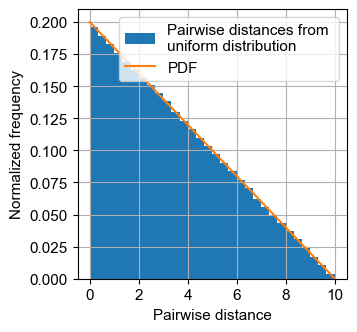

In [42]:
#test distribution
#uniformly distributed points on 1D line
interval_test=np.arange(0,10,step=0.001) #np.arange(0,1000,step=0.1)
random_pos_test=np.random.choice(interval_test,size=5000)

#resulting pairwise distances
dist_random_pos_test=scipy.spatial.distance.pdist(random_pos_test.reshape(-1,1),metric='euclidean')


#integration
int2=scipy.integrate.trapezoid(distr_1(np.max(interval_test),interval_test),interval_test)

print("Integration of pdf=",int2)

fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)
hist_dist_1=ax1.hist(dist_random_pos_test,bins=30,label="Pairwise distances from \nuniform distribution",density=True)
ax1.errorbar(interval_test,distr_1(np.max(interval_test),interval_test),label="PDF")


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
plt.xlabel("Pairwise distance",fontname = "Arial",fontsize=11)
plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
#plt.yscale("log")
#plt.xscale("log")
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/pairwise_distances_uniform_points_log_1.png",format="png",bbox_inches="tight",dpi=300)

 Mean and Std of distribution:

Mean: L/3

Std: L/sqrt(18)

In [43]:
print("Mean samples:",np.mean(dist_random_pos_test), "Mean Pdf: ",np.max(interval_test)/3)
print("Std samples:",np.std(dist_random_pos_test), "Std Pdf: ",np.max(interval_test)/np.sqrt(18))

Mean samples: 3.3387522329265833 Mean Pdf:  3.333
Std samples: 2.3603792296548174 Std Pdf:  2.3567869016947633


# Pairwise distances 

## Functions

In [45]:
#plot pairwise distances
def pairwise_dist_hist_1(chr_list,dist_x_list,dist_rd_x_list):
    
    for i in range(len(chr_list[:])):
        print(chr_list[i])
        dist_x=dist_x_list[i]


        dist_rd_x=dist_rd_x_list[i]



        fig=plt.figure(figsize=(3.5,3.5))
        ax1 = fig.add_subplot(111)


        hist_dist_b_3=ax1.hist([dist_x,dist_rd_x],bins=40,label=["Rep. elements","Uniform insertions"],density=True,color=["tab:orange","tab:blue"],cumulative=False,histtype="bar")

        #distribution
        L_sel=np.max(dist_x) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
        ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="PDF uniform insertions",color="black")


        print("Mean dist: ", np.mean(dist_x))
        print("Std dist: ", np.std(dist_x))
        print("Median dist: ", np.median(dist_x))
        print("Min dist: ", np.min(dist_x),"Max dist: ",np.max(dist_x))

        plt.yticks(fontname = "Arial",fontsize=11) 
        plt.xticks(fontname = "Arial",fontsize=11) 
        plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
        plt.xlabel("Pairwise distance [nt]",fontname = "Arial",fontsize=11)
        #plt.xscale("log")
        plt.legend(prop={'family': 'Arial','size': 11})
        plt.grid()
        ax1.set_aspect(1./ax1.get_data_ratio())

        #plt.savefig("Transposon_analysis_1/figures/hist_L1_chr1_1.pdf",format="pdf",bbox_inches="tight")
        plt.show()
        
#plot pairwise distances with logarithmic scaling        
def pairwise_dist_hist_2(chr_list,dist_x_list,dist_rd_x_list):
    #logarithmic visualization as clustering on much smaller distances then max pairwise distance

    for i in range(len(chr_list[:])):
        print(chr_list[i])
        #logarithmic spacing of bins
        den_input=np.geomspace(1,np.max(dist_x_list[i]),num=50)

        fig=plt.figure(figsize=(3.5,3.5))
        ax1 = fig.add_subplot(111)

        dist_x=dist_x_list[i]
        ax1.hist(dist_x,bins=den_input,label="Rep. elements",density=True,color="tab:orange")

        L_sel=np.max(dist_x) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
        ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="PDF uniform insertions",color="black")


        plt.yticks(fontname = "Arial",fontsize=11) 
        plt.xticks(fontname = "Arial",fontsize=11) 
        plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
        plt.xlabel("Pairwise distance [nt]",fontname = "Arial",fontsize=11)
        plt.xscale("log")
        plt.yscale("log")
        #plt.xlim(1,np.max(dist_x_list[i]))
        #plt.xlim(1,1000)
        #print(np.max(dist_x_list[i]))
        plt.legend(prop={'family': 'Arial','size': 11})
        plt.grid()
        ax1.set_aspect(1./ax1.get_data_ratio())
        #plt.savefig("Transposon_analysis_1/figures/log_hist_L1_chr1_1.pdf",format="pdf",bbox_inches="tight")
        plt.show()       

#plot pairwise distances with logarithmic scaling
#dont plot pdf
def pairwise_dist_hist_3(chr_list,dist_x_list,dist_rd_x_list):
    #logarithmic visualization as clustering on much smaller distances then max pairwise distance

    for i in range(len(chr_list[:])):
        print(chr_list[i])
        #logarithmic spacing of bins
        den_input=np.geomspace(1,np.max(dist_x_list[i]),num=50)

        fig=plt.figure(figsize=(3.5,3.5))
        ax1 = fig.add_subplot(111)

        dist_x=dist_x_list[i]
        ax1.hist(dist_x,bins=den_input,label="Rep. elements",density=True,color="tab:orange",cumulative=True,histtype="step")

        #L_sel=np.max(dist_x) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
        #ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="PDF hom. positions",color="black")


        plt.yticks(fontname = "Arial",fontsize=11) 
        plt.xticks(fontname = "Arial",fontsize=11) 
        plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
        plt.xlabel("Pairwise distance [nt]",fontname = "Arial",fontsize=11)
        plt.xscale("log")
        #plt.yscale("log")
        #plt.xlim(1,np.max(dist_x_list[i]))
        #plt.xlim(1,1000)
        #print(np.max(dist_x_list[i]))
        plt.legend(prop={'family': 'Arial','size': 11})
        plt.grid()
        ax1.set_aspect(1./ax1.get_data_ratio())
        #plt.savefig("Transposon_analysis_1/figures/log_hist_L1_chr1_1.pdf",format="pdf",bbox_inches="tight")
        plt.show()      
        
        
#############
#############
#get all pairwise distances from all chrs, option to normalies with max distance
def all_normalized_dist(chr_list,dist_x_list,norm=True):    
    dist_x_list_all_norm_1=[]
    dist_x_list_all_norm=[]



    #append all pairwise distances normalized with max distace        
    for i in range(len(chr_list[:])):
        #print(chr_list[i])

        if norm==True:
            dist_x_list_all_norm_1.append(dist_x_list[i]/np.max(dist_x_list[i]))
        if norm==False:
            dist_x_list_all_norm_1.append(dist_x_list[i])
 
    #flatten list    
    for i in dist_x_list_all_norm_1:
        for j in i:
            dist_x_list_all_norm.append(j)

    dist_x_list_all_norm=np.asarray(dist_x_list_all_norm)

    return dist_x_list_all_norm

#histogram of pariwise distances all chrs
#logarithmic visualization as clustering on much smaller distances then max pairwise distance
#visualize mean pdf
#normalization: weighted average
def pairwise_dist_hist_all_3(dist_x_list,dist_x_list_all_norm,pdfs_1_x,pdfs_1,norm=True,label_rep="Rep. element",label_hom="PDF uniform insertions",save=None):
    dist_x_list_all_norm_rs=dist_x_list_all_norm #*10**8
    if norm==True:
        den_input=np.geomspace(1,np.max(dist_x_list_all_norm_rs),num=50)/10**8
    if norm==False:
        den_input=np.geomspace(1,np.max(dist_x_list_all_norm_rs),num=50)
        
    fig=plt.figure(figsize=(3.5,3.5))
    ax1 = fig.add_subplot(111)


    ax1.hist(dist_x_list_all_norm_rs,bins=den_input,label=label_rep,density=True,color="tab:orange")
    
    #pdfs_1_mean=np.mean(pdfs_1,axis=0)
    
    weights_pdf = [len(sub_list) for sub_list in dist_x_list] #for weighted average, some chromosomes contribute more
    pdfs_1_mean=np.average(pdfs_1,weights=weights_pdf,axis=0)
    
    #pdfs_1_std=np.std(pdfs_1,axis=0)
    int_pdfs_mean=scipy.integrate.trapezoid(pdfs_1_mean,pdfs_1_x)
    print(int_pdfs_mean)
    #rs_factor=1/int_pdfs_mean
    ax1.errorbar(pdfs_1_x,pdfs_1_mean,label=label_hom,color="black")
    #ax1.fill_between(pdfs_1_x, pdfs_1_mean + pdfs_1_std, pdfs_1_mean - pdfs_1_std, alpha = 0.3,color="black")
    
    plt.yticks(fontname = "Arial",fontsize=11) 
    plt.xticks(fontname = "Arial",fontsize=11) 
    plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
    plt.xlabel("Pairwise distance [nt]",fontname = "Arial",fontsize=11)
    plt.xscale("log")
    plt.yscale("log")
    #plt.xlim(1,np.max(dist_x_list[i]))
    #plt.xlim(1,1000)
    #print(np.max(dist_x_list[i]))
    plt.legend(prop={'family': 'Arial','size': 11},loc="lower center")
    plt.grid()
    ax1.set_aspect(1./ax1.get_data_ratio())
    if save==None:
        plt.show()
        
    if save!=None:
        plt.savefig(save,format="pdf",bbox_inches="tight")


#set ticks  in log scale
def set_ticks(value, pos):
    return f"$10^{{{int(np.log10(value))}}}$"


#get list of pdfs from hom distribution for dist_x_list entries
#need to use same x range for all distibutions to compare, need to set negative values of distr_1 to zero
def list_of_pdfs_hom_distr(chr_list,dist_x_list):
    pdf=[]
    L_max=max(max(sublist) for sublist in dist_x_list)# L_max to set same x range for all distributions
    pdf_x_e= np.linspace(0,L_max,100)#x range to use for all distributions
    for i in range(len(chr_list)):
        L_max_e=np.max(dist_x_list[i]) #L_max for normalization of distr
        pdf_e=distr_1(L_max_e,pdf_x_e)
        pdf_e[pdf_e < 0] = 0 #distribution goes to zero for negative values
        pdf.append(pdf_e)
    return np.asarray(pdf) ,  pdf_x_e


# Plot pairwise distances in histogram

chr1
Mean dist:  84746696.10581304
Std dist:  60374461.499493
Median dist:  73897620.0
Min dist:  92.0 Max dist:  248684521.5


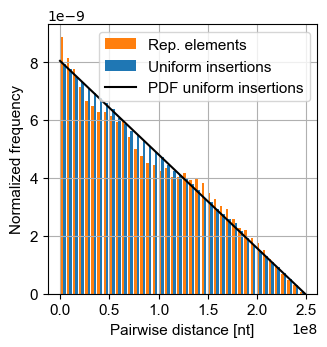

chr2
Mean dist:  81517425.88349704
Std dist:  57797223.850317836
Median dist:  71643817.0
Min dist:  61.0 Max dist:  242832144.5


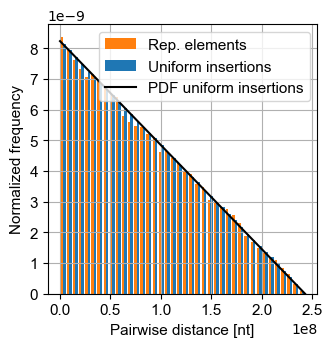

chr3
Mean dist:  66273347.855609275
Std dist:  47046317.7151757
Median dist:  58251699.5
Min dist:  71.0 Max dist:  197441565.5


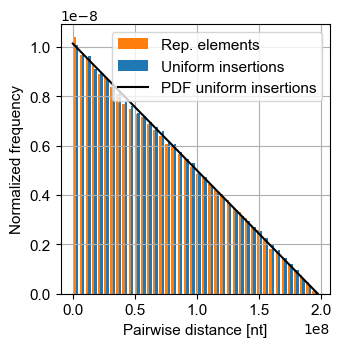

chr4
Mean dist:  65148164.2259174
Std dist:  46114634.452991754
Median dist:  57599107.5
Min dist:  45.0 Max dist:  190442011.5


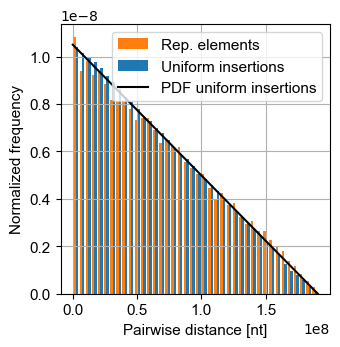

chr5
Mean dist:  60907009.57992001
Std dist:  43260961.076613516
Median dist:  53469723.75
Min dist:  81.0 Max dist:  180834458.0


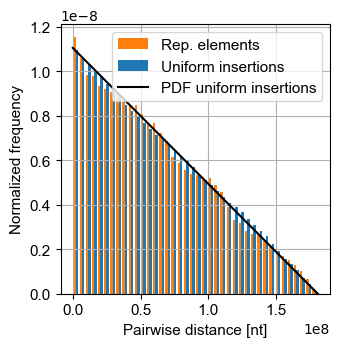

chr6
Mean dist:  58797738.29372217
Std dist:  41818930.011315614
Median dist:  51773868.0
Min dist:  48.0 Max dist:  170593769.5


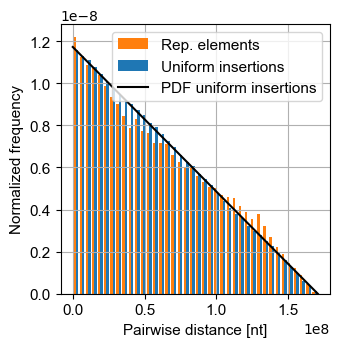

chr7
Mean dist:  53213606.09422209
Std dist:  37696005.551004514
Median dist:  46371230.25
Min dist:  31.5 Max dist:  158927709.5


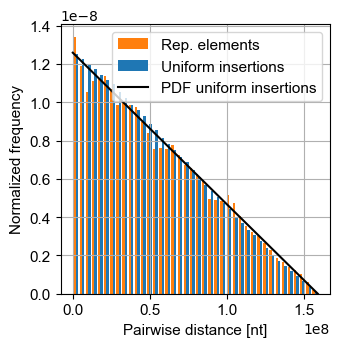

chr8
Mean dist:  47878436.94832093
Std dist:  33883704.76974756
Median dist:  42157053.5
Min dist:  65.5 Max dist:  146094127.5


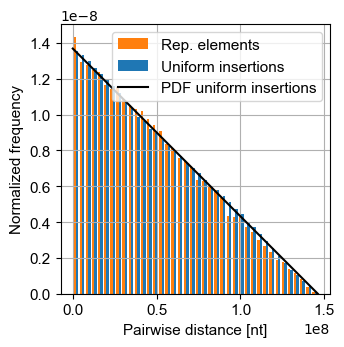

chr9
Mean dist:  48895742.76212948
Std dist:  35878063.55172956
Median dist:  42264351.5
Min dist:  81.5 Max dist:  140812540.5


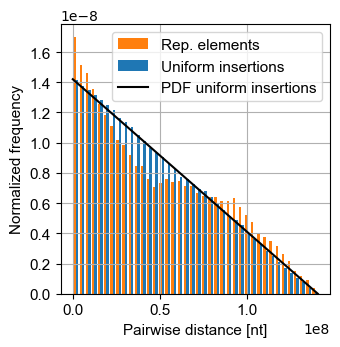

chr10
Mean dist:  46454906.589991294
Std dist:  32956450.726937942
Median dist:  41297915.0
Min dist:  69.0 Max dist:  135171313.5


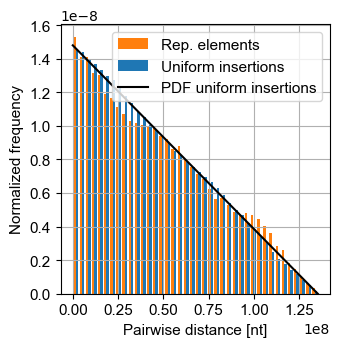

chr11
Mean dist:  47226140.57910699
Std dist:  33607667.40790475
Median dist:  41624203.0
Min dist:  30.5 Max dist:  134430984.0


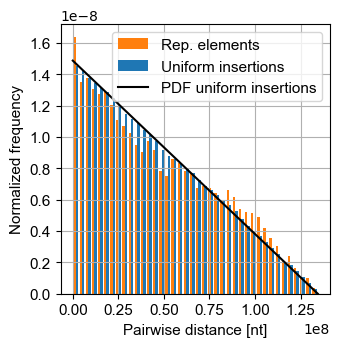

chr12
Mean dist:  45427470.55937938
Std dist:  32132233.99652228
Median dist:  40132007.75
Min dist:  59.5 Max dist:  133631433.5


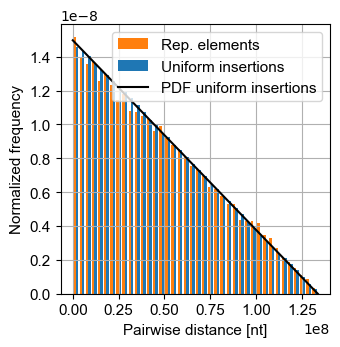

chr13
Mean dist:  32230486.240290657
Std dist:  23006274.048903234
Median dist:  28095868.5
Min dist:  94.5 Max dist:  95091533.0


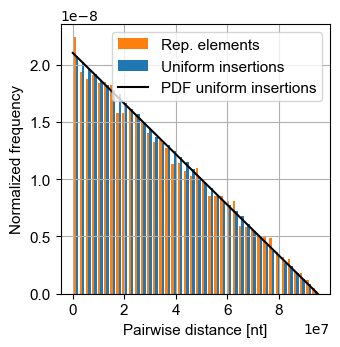

chr14
Mean dist:  28453146.510577876
Std dist:  20226861.61256493
Median dist:  25228991.0
Min dist:  39.5 Max dist:  88160718.5


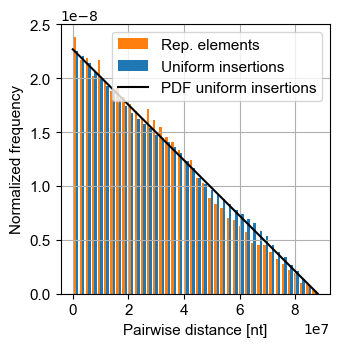

chr15
Mean dist:  28484742.930720564
Std dist:  20182999.1553835
Median dist:  25236563.25
Min dist:  129.5 Max dist:  82204974.5


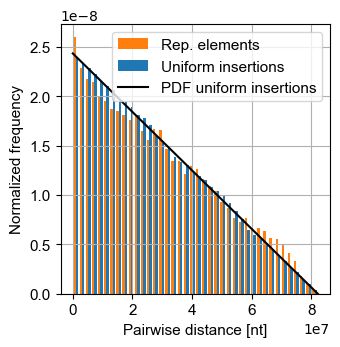

chr16
Mean dist:  30557665.9226468
Std dist:  22227904.62224659
Median dist:  26637579.5
Min dist:  58.0 Max dist:  89542869.5


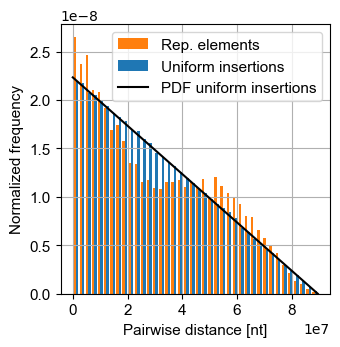

chr17
Mean dist:  29186913.098863635
Std dist:  20766771.20895117
Median dist:  25736725.5
Min dist:  50.0 Max dist:  81155876.0


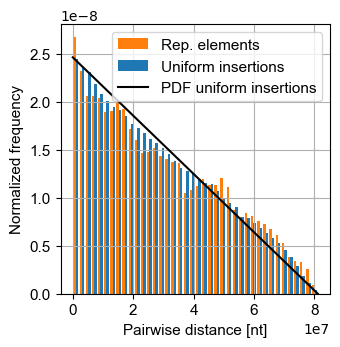

chr18
Mean dist:  25919839.096728023
Std dist:  18404479.53300394
Median dist:  22925086.0
Min dist:  78.0 Max dist:  77530807.0


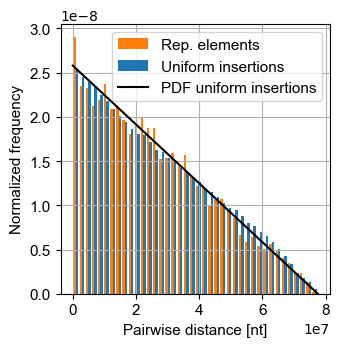

chr19
Mean dist:  17710625.348620676
Std dist:  13036830.384229535
Median dist:  15535861.0
Min dist:  65.0 Max dist:  56029556.0


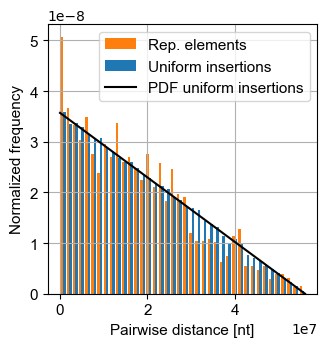

chr20
Mean dist:  22103046.430606965
Std dist:  15660015.454075374
Median dist:  19398492.0
Min dist:  44.0 Max dist:  62841066.5


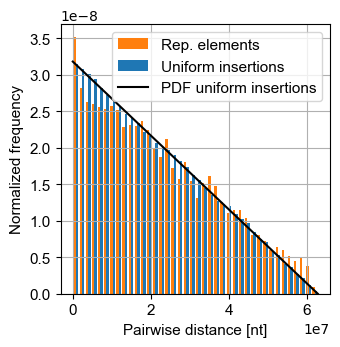

chr21
Mean dist:  13063702.736255411
Std dist:  9328651.944594104
Median dist:  11574754.0
Min dist:  82.0 Max dist:  38372599.0


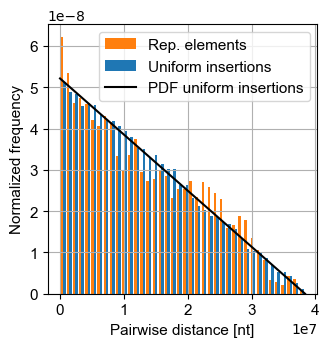

chr22
Mean dist:  12256943.934216468
Std dist:  8888895.416722188
Median dist:  10770016.0
Min dist:  135.0 Max dist:  34978023.0


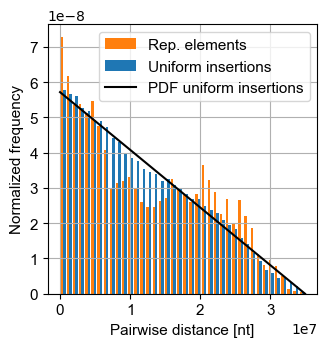

chrX
Mean dist:  51834341.26831347
Std dist:  36785872.235962644
Median dist:  45108311.75
Min dist:  49.0 Max dist:  154812205.5


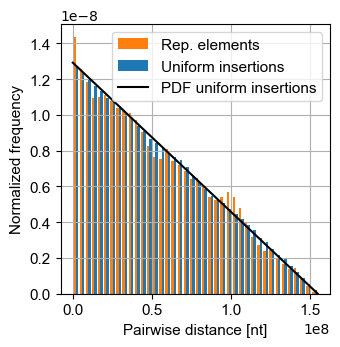

In [46]:
#pairwise distances in histogram compared to random insertions and pdf
pairwise_dist_hist_1(chr_list=chr_list_3,dist_x_list=dist_x_list_3,dist_rd_x_list=dist_rd_x_list_3)

chr1


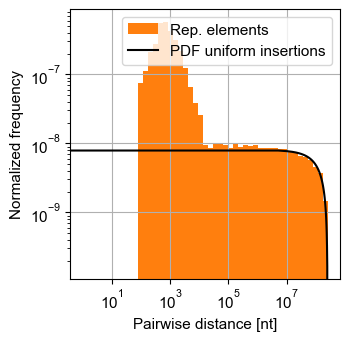

chr2


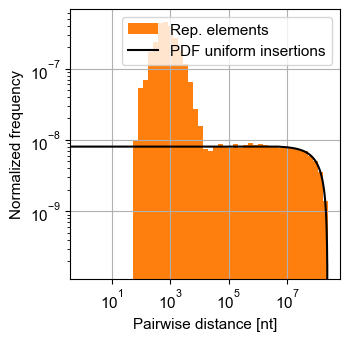

chr3


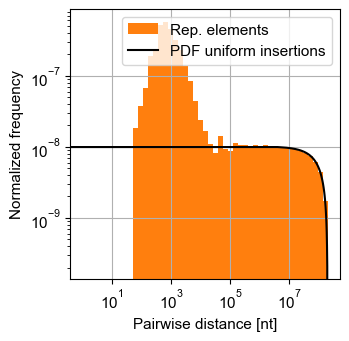

chr4


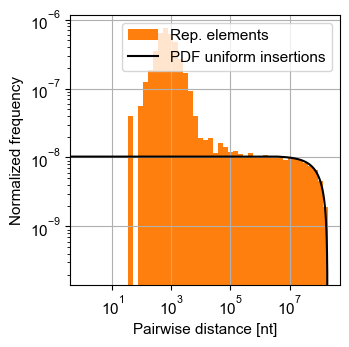

chr5


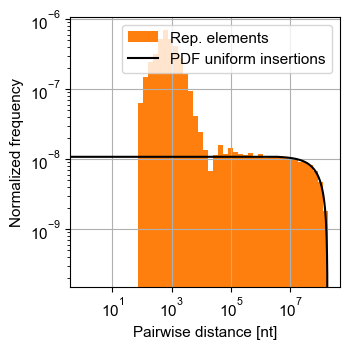

chr6


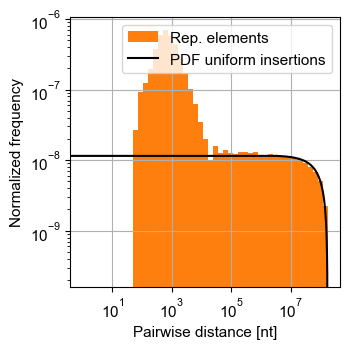

chr7


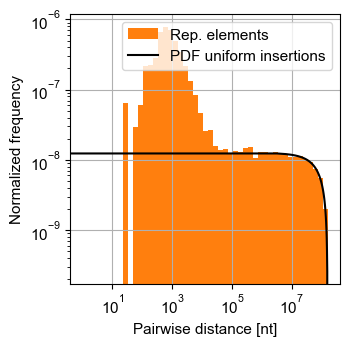

chr8


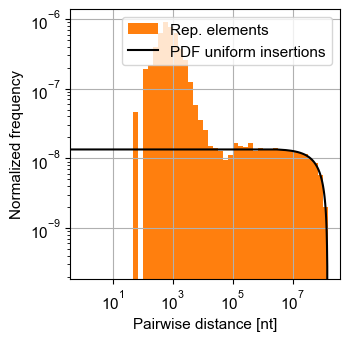

chr9


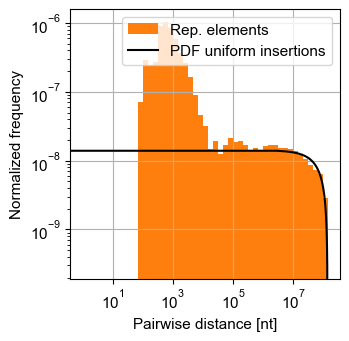

chr10


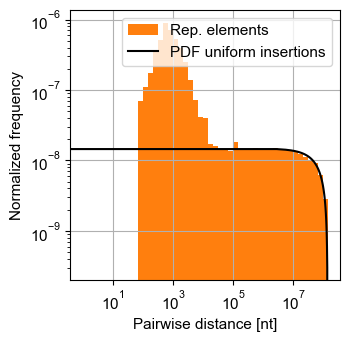

chr11


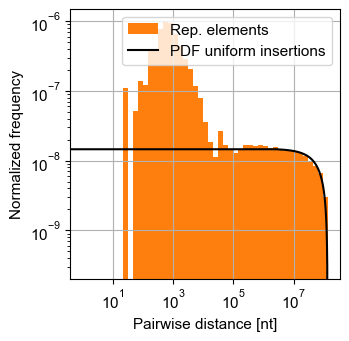

chr12


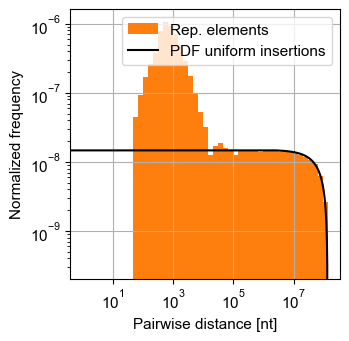

chr13


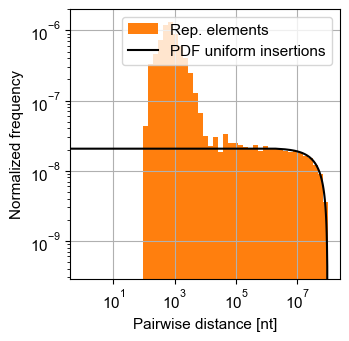

chr14


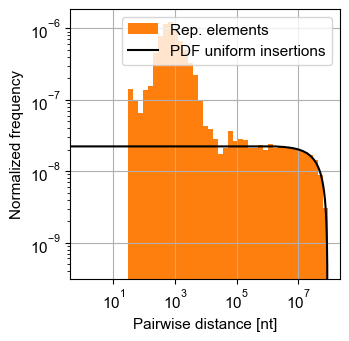

chr15


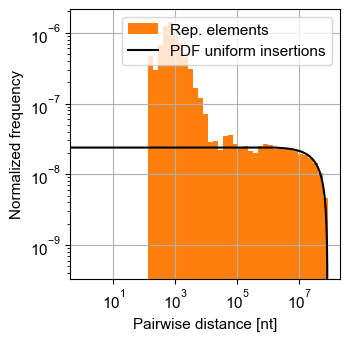

chr16


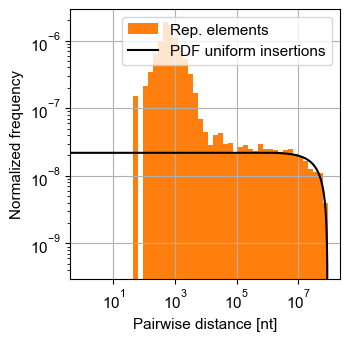

chr17


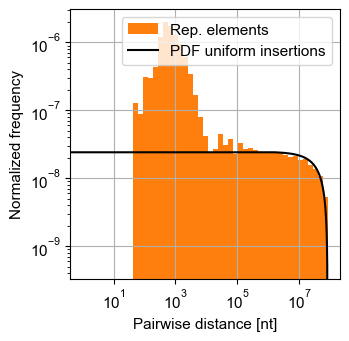

chr18


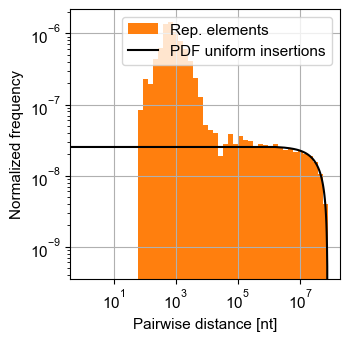

chr19


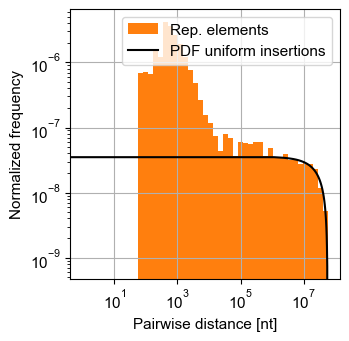

chr20


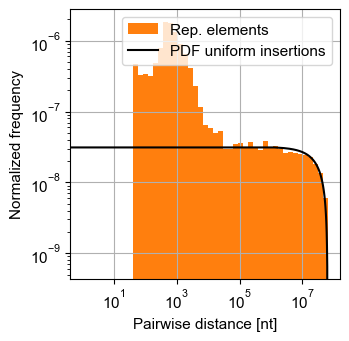

chr21


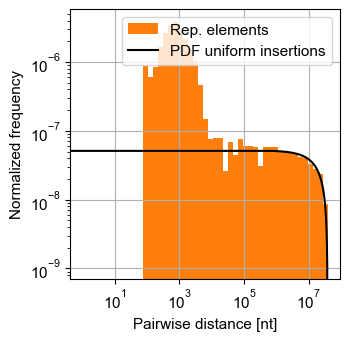

chr22


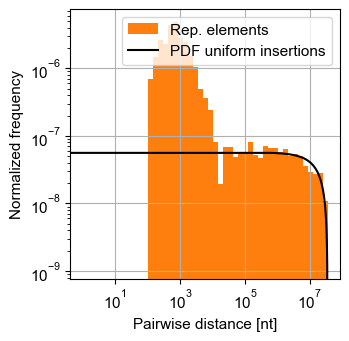

chrX


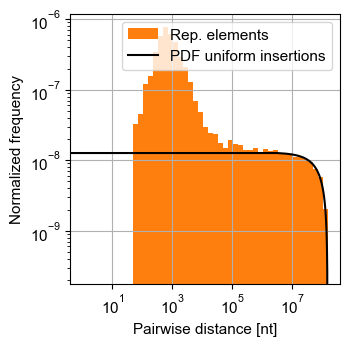

In [47]:
#pariwise distances and pdf using log scale
pairwise_dist_hist_2(chr_list=chr_list_3,dist_x_list=dist_x_list_3,dist_rd_x_list=dist_rd_x_list_3)

In [48]:
#pairwise distances for all chromosomes
dist_x_list_all_no_norm_3=all_normalized_dist(chr_list=chr_list_3,dist_x_list=dist_x_list_3,norm=False)

pdfs_3,pdfs_3_x=list_of_pdfs_hom_distr(chr_list=chr_list_3,dist_x_list=dist_x_list_3)

In [49]:
print("Mean dist: ", np.mean(dist_x_list_all_no_norm_3))
print("Std dist: ", np.std(dist_x_list_all_no_norm_3))
print("Median dist: ", np.median(dist_x_list_all_no_norm_3))
print("Min dist: ", np.min(dist_x_list_all_no_norm_3),"Max dist: ",np.max(dist_x_list_all_no_norm_3))

Mean dist:  59659166.26123063
Std dist:  47849055.58542286
Median dist:  48288875.0
Min dist:  30.5 Max dist:  248684521.5


1.0000462371506225


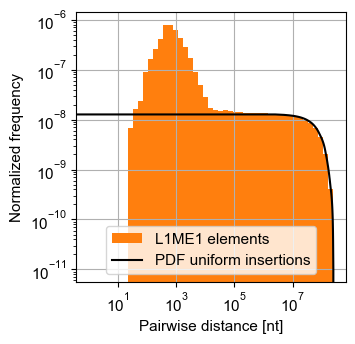

In [50]:
#averaged, normalizes pairwise distances and pdf using log scale
#name_save="Transposon_analysis_1/figures/h_hist_L1MB3_all_chr_2.pdf"
name_save=None

pairwise_dist_hist_all_3(dist_x_list=dist_x_list_3,dist_x_list_all_norm=dist_x_list_all_no_norm_3,pdfs_1_x=pdfs_3_x,pdfs_1=pdfs_3,norm=False,label_rep="L1ME1 elements",label_hom="PDF uniform insertions",save=name_save)



# DB Scan cluster detection

## Functions

In [6]:
#DBSCAN algorithm
#! crashes for high number of points due to memory 
def DB_scan_1(eps,min_samples,input_):

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(input_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    #print(n_clusters_)

    #get particles per cluster 
    counter_labels=Counter(labels)
    

    counter_labels=dict(counter_labels)

    counter_numbers=[]

    for key, value in counter_labels.items():
        #en=counter_labels{i}
        if key !=-1:
            counter_numbers.append(value)
    counter_numbers=np.asarray(counter_numbers)
    
    #percentage of points in clusters:
    try: #if noise present
        perc_in_cluster=1-counter_labels[-1]/len(input_)
    except: #if no noise present, all points part of clusters
        perc_in_cluster=1

    #get mean particle number, get mean only if clusters detected, else append 0    
    if n_clusters_>0:
        mean_cluster_number=np.mean(counter_numbers)
    else:    
        mean_cluster_number=0

    return n_clusters_,mean_cluster_number,perc_in_cluster

#apply DBSCAN to dataset split by chromosomes
#get number of clusters, fraction of elements in clusters for transposons and random insertions
def DB_scan_appl_1(eps_1,min_samples_1,chr_list,pos_x_list,pos_rd_x_list): 
    n_clusters_1=[]
    n_clusters_rd_1=[]

    mean_cluster_number_1=[]
    mean_cluster_number_rd_1=[]

    perc_in_cluster_1=[]
    perc_in_cluster_rd_1=[]

    #eps_1=10000
    #min_samples_1=2

    for i in range(len(chr_list[:])):
        n_clusters_1_e,mean_cluster_number_1_e,perc_in_cluster_1_e=DB_scan_1(eps=eps_1,min_samples=min_samples_1,input_=pos_x_list[i].reshape(-1,1))

        n_clusters_1.append(n_clusters_1_e)
        perc_in_cluster_1.append(perc_in_cluster_1_e)

        #if no cluster detected, dont append zero average particle number in cluster
        #if mean_cluster_number_1_e>0:
         #   mean_cluster_number_1.append(mean_cluster_number_1_e)
        #append even for zero average particle number
        mean_cluster_number_1.append(mean_cluster_number_1_e)


        ########################################

        n_clusters_rd_1_e,mean_cluster_number_rd_1_e,perc_in_cluster_rd_1_e=DB_scan_1(eps=eps_1,min_samples=min_samples_1,input_=pos_rd_x_list[i].reshape(-1,1))

        n_clusters_rd_1.append(n_clusters_rd_1_e)
        perc_in_cluster_rd_1.append(perc_in_cluster_rd_1_e)

        #if no cluster detected, dont append zero average particle number in cluster
        #if mean_cluster_number_rd_1_e>0:
         #   mean_cluster_number_rd_1.append(mean_cluster_number_rd_1_e)    
        #append even for zero average particle number
        mean_cluster_number_rd_1.append(mean_cluster_number_rd_1_e)

    n_clusters_1=np.asarray(n_clusters_1)
    n_clusters_rd_1=np.asarray(n_clusters_rd_1)

    mean_cluster_number_1=np.asarray(mean_cluster_number_1)
    mean_cluster_number_rd_1=np.asarray(mean_cluster_number_rd_1)

    perc_in_cluster_1=np.asarray(perc_in_cluster_1)
    perc_in_cluster_rd_1=np.asarray(perc_in_cluster_rd_1)


    #non zero entries
    mean_cluster_number_1_nz=mean_cluster_number_1[np.nonzero(mean_cluster_number_1)]
    mean_cluster_number_rd_1_nz=mean_cluster_number_rd_1[np.nonzero(mean_cluster_number_rd_1)]
    
    return n_clusters_1, n_clusters_rd_1, mean_cluster_number_1, mean_cluster_number_rd_1, mean_cluster_number_1_nz, mean_cluster_number_rd_1_nz,perc_in_cluster_1,perc_in_cluster_rd_1

#apply DBSCAN to dataset split by chromosomes
#calculate centres of mass and extend of cluster coordinates
def DB_scan_appl_2(eps,min_samples,chr_list,pos_x_list,pos_rd_x_list): 
    n_clusters_1=[]
    n_clusters_rd_1=[]

    mean_cluster_number_1=[]
    mean_cluster_number_rd_1=[]

    perc_in_cluster_1=[]
    perc_in_cluster_rd_1=[]

    #eps_1=10000
    #min_samples_1=2
    cluster_centers_all=[]
    cluster_ext_all=[]
    for i in range(len(chr_list[:])):
        
        input_=pos_x_list[i].reshape(-1,1)
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(input_)
        
        # Get cluster labels
        cluster_labels = db.labels_

        # Get core sample indices
        core_indices = db.core_sample_indices_

        # Calculate cluster centers (mean of core samples)
        cluster_centers=[]
        m_d_max=[]
        for l in np.unique(cluster_labels): #select indices for clusters that are not noise
            if l !=-1:
                centre_e=input_[cluster_labels==l].mean(axis=0)
                cluster_centers.append(centre_e[0])
                m_d=scipy.spatial.distance.pdist(input_[cluster_labels==l].reshape(-1,1),metric='euclidean')
                m_d_max.append(np.max(m_d))

        
        cluster_centers_all.append(cluster_centers)
        cluster_ext_all.append(m_d_max)
                               
                               
    return cluster_centers_all,  cluster_ext_all

#############
#############

#apply DBSCAN to dataset split by chromosomes
#apply DB scan, get data points not in clusters (noise) and centres of data points with different ranges of points in them
#get extension of clusters from start of first element to end of last element
def DB_scan_appl_7b(dataset, point_sizes, eps, min_samples,points_in_clusters):
    
    
    ####
    ###
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(dataset)

    #Get labels and number of occurences (= number of points in cluster), including noise points with label = 0
    unique_labels2, counts2 = np.unique(labels, return_counts=True)
    unique_labels=[]
    counts=[]
    #print(unique_labels2,counts2)
    #filter out counts and label for noise points 
    for i in range(len(unique_labels2)):
        if unique_labels2[i]!=-1:
            unique_labels.append(unique_labels2[i])
            counts.append(counts2[i])
            
    #get centres of cluster masked by label (each cluster has unique label)
    #cluster_centers = [dataset[labels == label].mean(axis=0)[0] for label in unique_labels]
    #get sizes of clusters
    #get end points of all points in cluster (i.e. middle plus extension/2) and then get max value
    cluster_max=[ np.asarray([dataset[labels == label]+point_sizes[labels == label]/2])[0].max(axis=0)[0] for label in unique_labels]
    #print(cluster_max)
    #print(np.asarray([dataset[labels == label]+point_sizes[labels == label]/2 for label in unique_labels])[0] )
    #same for middle minus extension/2
    cluster_min=[ np.asarray([dataset[labels == label]-point_sizes[labels == label]/2])[0].min(axis=0)[0] for label in unique_labels]
        
    cluster_sizes = np.asarray(cluster_max)-np.asarray(cluster_min)
    
    cluster_centers= cluster_sizes/2 + np.asarray(cluster_min)
    
    #get subset of cluster centres wich have cluster number in specific range
    centres_clusters_by_range=[]
    sizes_clusters_by_range=[]
    for i in range(len(points_in_clusters)):
        
        centers = [center for center, count in zip(cluster_centers, counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        #print(centers)
        centres_clusters_by_range.append(centers)
        
        ####
        sizes = [ size for size, count in zip(cluster_sizes,counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        sizes_clusters_by_range.append(sizes)
    #get noise points
    outliers = dataset[labels == -1]
    outlier_sizes=point_sizes[labels == -1]

    return outliers, outlier_sizes,centres_clusters_by_range, sizes_clusters_by_range


#apply DB_scan_appl_7b to data partitioned by chromosomes
def DB_scan_appl_8(eps,min_samples,chr_list,pos_x_list,pos_rd_x_list,len_x_list,points_in_clusters):
    centres_clusters_by_range_all_chr=[]
    sizes_clusters_by_range_all_chr=[]
    centres_clusters_by_range_rd_all_chr=[]
    sizes_clusters_by_range_rd_all_chr=[]
    
    noise_all_chr=[]
    noise_size_all_chr=[]
    noise_all_chr_rd=[]
    noise_size_chr_rd=[]
    for i in range(len(chr_list)):
        #both positions and random positions use same point lengths
        outliers,outlier_sizes, centres_clusters_by_range, sizes_clusters_by_range=DB_scan_appl_7b(dataset=pos_x_list[i].reshape(-1,1),point_sizes=len_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)
        outliers_rd,outlier_rd_sizes, centres_clusters_by_range_rd, sizes_clusters_by_range_rd=DB_scan_appl_7b(dataset=pos_rd_x_list[i].reshape(-1,1),point_sizes=len_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)

        centres_clusters_by_range_all_chr.append(centres_clusters_by_range)
        sizes_clusters_by_range_all_chr.append(sizes_clusters_by_range)
        noise_all_chr.append(outliers)
        noise_size_all_chr.append(outlier_sizes)
        
        centres_clusters_by_range_rd_all_chr.append(centres_clusters_by_range_rd)
        sizes_clusters_by_range_rd_all_chr.append(sizes_clusters_by_range_rd)
        noise_all_chr_rd.append(outliers_rd)
        noise_size_chr_rd.append(outlier_rd_sizes)
        
    return centres_clusters_by_range_all_chr,sizes_clusters_by_range_all_chr,noise_all_chr,noise_size_all_chr,centres_clusters_by_range_rd_all_chr,sizes_clusters_by_range_rd_all_chr,noise_all_chr_rd,noise_size_chr_rd



In [22]:
#test DB scan
outliers, outlier_sizes,centres_clusters_by_range, sizes_clusters_by_range=DB_scan_appl_7b(dataset=np.asarray([5,6,200,300,302,303]).reshape(-1, 1), point_sizes=np.asarray([1,4,100,1,2,4]).reshape(-1, 1), eps=3, min_samples=2,points_in_clusters=[[2,3],[3,5]])

print("###")
print(outliers)
print(outlier_sizes)
print(centres_clusters_by_range)
print(sizes_clusters_by_range)

###
[[200]]
[[100]]
[[6.0], [302.25]]
[[4.0], [5.5]]


# Cluster detection 

In [23]:
#DB scan paramters, eps_3 captures peak in L1ME1 pariwise distances, min_samples_3: typically >= Dim+1  
eps_3=10**4
min_samples_3=2

n_clusters_3, n_clusters_rd_3, mean_cluster_number_3, mean_cluster_number_rd_3, mean_cluster_number_3_nz, mean_cluster_number_rd_3_nz,perc_in_cluster_3,perc_in_cluster_rd_3=DB_scan_appl_1(eps_1=eps_3,min_samples_1=2,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3)

In [24]:
cluster_centers_all_3,  cluster_ext_all_3=DB_scan_appl_2(eps=eps_3,min_samples=min_samples_3,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3)

print("max cluster extension:",np.max([item for sublist in cluster_ext_all_3 for item in sublist]))
print("mmin cluster extension:",np.min([item for sublist in cluster_ext_all_3 for item in sublist]))

print("mean cluster extension:",np.mean([item for sublist in cluster_ext_all_3 for item in sublist]))

print("std cluster extension:",np.std([item for sublist in cluster_ext_all_3 for item in sublist]))
print("total number of clusters:",np.sum(n_clusters_3))

max cluster extension: 31420.5
mmin cluster extension: 71.0
mean cluster extension: 3085.570990237099
std cluster extension: 3394.162607371834
total number of clusters: 7170


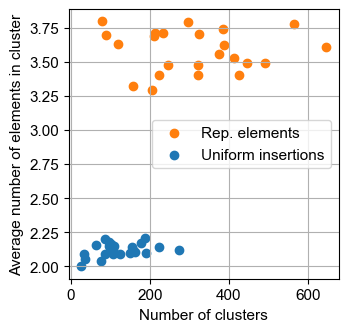

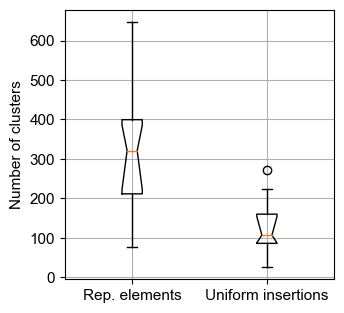

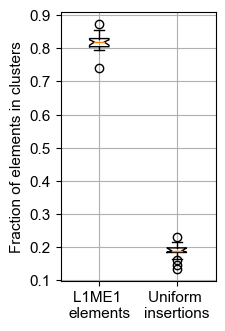

mean cluster number: 3.5787975446014237
mean rd cluster number: 2.1210894803533695


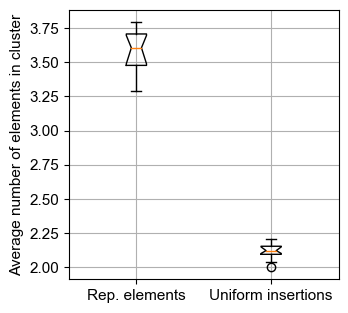

In [25]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

ax1.scatter(n_clusters_3,mean_cluster_number_3,label="Rep. elements",color="tab:orange")
ax1.scatter(n_clusters_rd_3,mean_cluster_number_rd_3,label="Uniform insertions",color="tab:blue")

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Average number of elements in cluster",fontname = "Arial",fontsize=11)
plt.xlabel("Number of clusters",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
plt.show()


######################
######################
fliers=True

fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

ax1.boxplot([n_clusters_3,n_clusters_rd_3],labels=["Rep. elements","Uniform insertions"],showfliers=fliers,notch=True,bootstrap=10000)

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Number of clusters",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_3/figures/num_clusters_e4_3_3.pdf",format="pdf",bbox_inches="tight")
plt.show()

####################
####################


#fig=plt.figure(figsize=(3.5,3.5))
fig=plt.figure(figsize=(2,3.5))
ax1 = fig.add_subplot(111)

ax1.boxplot([perc_in_cluster_3,perc_in_cluster_rd_3],labels=["L1ME1 \nelements","Uniform \ninsertions"],showfliers=fliers,notch=True,widths=0.25,bootstrap=10000)

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Fraction of elements in clusters",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
#ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_AluSq2_frac_in_clusters_e4_2_2.pdf",format="pdf",bbox_inches="tight")

plt.show()

###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

ax1.boxplot([mean_cluster_number_3,mean_cluster_number_rd_3],labels=["Rep. elements","Uniform insertions"],showfliers=fliers,notch=True,bootstrap=10000)
print("mean cluster number:",np.mean(mean_cluster_number_3))
print("mean rd cluster number:",np.mean(mean_cluster_number_rd_3))
#print("max cluster number:",np.max(mean_cluster_number_3))
#print("max rd cluster number:",np.max(mean_cluster_number_rd_3))

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Average number of elements in cluster",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_3/figures/avg_num_in_clusters_e4_3_3.pdf",format="pdf",bbox_inches="tight")

plt.show()

In [26]:
#stat sign. for clusters 2-4 elem.
t_frac, p_value_frac=scipy.stats.mannwhitneyu(x=perc_in_cluster_3,y=perc_in_cluster_rd_3,alternative="two-sided")
print("Fraction of elements in clusters:",p_value_frac)

Fraction of elements in clusters: 6.6368856429973785e-09


# Chromatin accessibility using ENCODE/openChrom data
### https://www.encodeproject.org/annotations/ENCSR236YNV/



### http://genome.ucsc.edu/cgi-bin/hgTrackUi?db=hg19&g=wgEncodeOpenChromSynth
validated, OC Code = 1:

        Black: Regions identified as peaks by both the DNaseI HS assay and FAIRE assay. Peaks for DNaseI HS have DNase peak calling p-values < 0.05 (-log10(p-value) > 1.3) and peaks for FAIRE have FAIRE peak calling p-values < 0.1 (-log10(p-value) > 1.0). 


Open Chromatin, OC Code = 2 or 3:

        Blue (high significance): Regions not identified as peaks in both DNaseI HS and FAIRE, but for which the combination of peak calling p-values from these assays using Fisher's combined probability test results in a p-value < 0.01 (-log10(p-value) > 2).


DNase, OC Code = 2:

        Green (low significance): Regions identified by DNaseI HS as peaks (DNase peak calling p-value < 0.05 (-log10(p-value) > 1.3)) and not identified by FAIRE as peaks (FAIRE peak calling p-value < 0.1 (-log10(p-value) > 1.0)), and with a Fisher's combined DNaseI HS and FAIRE p-value >= 0.01 (-log10(p-value) <= 2).
        Blue (high significance): see Open Chromatin above.


FAIRE, OC Code = 3:

        Dark Red (low significance): Regions identified by FAIRE as peaks (FAIRE peak calling p-value < 0.1 (-log10(p-value) > 1.0)) and not identified by DNaseI HS as peaks (DNase peak calling p-value < 0.05 (-log10(p-value) > 1.3)), and with a Fisher's combined DNaseI HS and FAIRE p-value >= 0.01 (-log10(p-value) <= 2).
        Blue (high significance): see Open Chromatin above.


ChIP-seq, OC Code = 4:

        Pink: Regions identified by ChIP-seq as peaks (at least one of the peak calling p-values for the three ChIP experiments are < 0.05 (-log10(p-value) > 1.3)) indicating binding sites for one or more of RNA Pol II, CTCF, and c-Myc described here and not identified by DNaseI HS or FAIRE as peaks. Peaks for ChIP-seq have p-values < 0.05 (-log10(p-value) > 1.3). For RNA Pol II, only sites that overlap annotated transcription start sites by the UCSC Genes track are considered. 

All signal values, -log10(p-values), and the OC Code are displayed on the detail page for each element and are available in the corresponding bed file. 

# Functions

In [16]:
#get centre position from dataframe
def positions_elements_3(peak_input,chr_sel_name,chr_sel,chr_start,chr_stop):
    #peak_input: narrow peak file with positions from only one chr
    #get position middle of element on chr:
    pos=[]
    input_=peak_input[peak_input[chr_sel_name]==chr_sel]
    for i in range(len(input_)):
        pos_1=input_[i:i+1][chr_start].to_numpy()[0] + 0.5*(input_[i:i+1][chr_stop].to_numpy()[0]-input_[i:i+1][chr_start].to_numpy()[0])
        
        pos.append(pos_1)
    return np.asarray(pos)

#check if position in pos_1_input has position in pos_2_input within a distance dist
def check_if_pos_1_in_range_pos_2_V1(chr_input,pos_1_input,pos_2_input,dist):
    fraction_in_range=[]
    for i in range(len(chr_input)): #select chr
        fraction_in_range_e=[]
        for j in range(len(pos_1_input[i])): #select point on chr
            #k=0
            #s=0
            
            if np.min( np.abs(pos_1_input[i][j]-pos_2_input[i]) ) <=dist: #get all distances from point on chr to all points on same chr in pos_2
                fraction_in_range_e.append(1)
            else:
                fraction_in_range_e.append(0)
        fraction_in_range.append(fraction_in_range_e)

        
    return fraction_in_range

# Read in open chromatin data

In [8]:
#read in open chromatin dataset
Chr_acc_peaks=pd.read_csv("Transposon_analysis_1/DNAse_I_ENCFF001UZS/HelaS3_OC.bed",sep="\t",header = None)

Chr_acc_peaks.columns = ["chrom","chromStart","chromEnd","name","score","strand","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"]

In [9]:
Chr_acc_peaks[:]

chrom  chromStart  chromEnd             name  score strand         6  \
0        chr1       10066     10205      FAIREOnly_1   1000      .     10066   
1        chr1       91424     91492       ChIPOnly_1   1000      .     91424   
2        chr1      104923    105070       ChIPOnly_2   1000      .    104923   
3        chr1      237670    237859       ChIPOnly_3   1000      .    237670   
4        chr1      251235    251368       ChIPOnly_4   1000      .    251235   
...       ...         ...       ...              ...    ...    ...       ...   
258213  chr21    48081488  48081897  OpenChrom_11606   1000      .  48081488   
258214  chr21    48082398  48082558  DNaseOnly_77095   1000      .  48082398   
258215  chr21    48082935  48083351  DNaseOnly_77096   1000      .  48082935   
258216  chr21    48087873  48088015  DNaseOnly_77097   1000      .  48087873   
258217  chr21    48088111  48088281  DNaseOnly_77098   1000      .  48088111   

               7          8     9  ...    11      12    13      14   15  \
0          10205    153,0,0  1.34  ...  0.00  0.0176  2.11  0.0000  0.0   
1          91492  255,0,255  0.00  ...  0.00  0.0005  0.00  0.0000  0.0   
2         105070  255,0,255  0.00  ...  0.00  0.0017  0.00  0.0000  0.0   
3         237859  255,0,255  0.00  ...  0.00  0.0017  0.00  0.0000  0.0   
4         251368  255,0,255  0.00  ...  0.00  0.0011  0.00  0.0029  0.0   
...          ...        ...   ...  ...   ...     ...   ...     ...  ...   
258213  48081897    0,0,255  2.15  ...  3.05  0.0053  0.00  0.0078  0.0   
258214  48082558    0,153,0  0.82  ...  1.46  0.0024  0.00  0.0064  0.0   
258215  48083351    0,153,0  0.97  ...  1.65  0.0080  0.00  0.0146  0.0   
258216  48088015    0,153,0  0.74  ...  1.35  0.0057  0.00  0.0129  0.0   
258217  48088281    0,153,0  0.74  ...  1.36  0.0050  0.00  0.0038  0.0   

            16    17      18   19  20  
0       0.0175  0.00  0.0140  0.0   3  
1       0.0958  1.60  0.0013  0.0   4  
2       0.3310  4.55  0.0000  0.0   4  
3       0.3424  4.68  0.0042  0.0   4  
4       0.2762  3.88  0.0000  0.0   4  
...        ...   ...     ...  ...  ..  
258213  0.0064  0.00  0.0000  0.0   2  
258214  0.0064  0.00  0.0137  0.0   2  
258215  0.0619  1.14  0.0102  0.0   2  
258216  0.0056  0.00  0.0079  0.0   2  
258217  0.0025  0.00  0.0139  0.0   2  

[258218 rows x 21 columns]

In [10]:
#select which regions to include

#Chr_acc_peaks_sel1=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("Valid")]
#Chr_acc_peaks_sel1=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("OpenChrom")]
#Chr_acc_peaks_sel1=Chr_acc_peaks

Chr_acc_peaks_sel1_p1=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("Valid")]
Chr_acc_peaks_sel1_p2=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("OpenChrom")]
Chr_acc_peaks_sel1=pd.concat([Chr_acc_peaks_sel1_p1,Chr_acc_peaks_sel1_p2])

In [11]:
Chr_acc_peaks_sel1

chrom  chromStart  chromEnd             name  score strand         6  \
7        chr1      713850    714460          Valid_1   1000      .    713850   
13       chr1      761903    763244          Valid_2   1000      .    761903   
30       chr1      841391    842575          Valid_3   1000      .    841391   
32       chr1      845956    847166          Valid_4   1000      .    845956   
37       chr1      853094    853481          Valid_5   1000      .    853094   
...       ...         ...       ...              ...    ...    ...       ...   
258047  chr21    47415122  47416071  OpenChrom_11602   1000      .  47415122   
258115  chr21    47604142  47605091  OpenChrom_11603   1000      .  47604142   
258118  chr21    47611090  47611527  OpenChrom_11604   1000      .  47611090   
258203  chr21    48023077  48023411  OpenChrom_11605   1000      .  48023077   
258213  chr21    48081488  48081897  OpenChrom_11606   1000      .  48081488   

               7        8      9  ...     11      12    13      14     15  \
7         714460    0,0,0   8.19  ...   8.29  0.0126  1.26  0.1502   7.06   
13        763244    0,0,0  15.95  ...  16.00  0.0142  1.52  0.2604  12.10   
30        842575    0,0,0   9.85  ...   9.42  0.0162  1.86  0.0530   2.61   
32        847166    0,0,0   4.64  ...   4.16  0.0149  1.64  0.0171   0.00   
37        853481    0,0,0   1.76  ...   1.59  0.0110  1.01  0.0284   1.46   
...          ...      ...    ...  ...    ...     ...   ...     ...    ...   
258047  47416071  0,0,255   2.77  ...   3.75  0.0078  0.00  0.0040   0.00   
258115  47605091  0,0,255   4.32  ...   4.51  0.0105  0.94  0.0225   0.00   
258118  47611527  0,0,255   2.59  ...   3.55  0.0069  0.00  0.0097   0.00   
258203  48023411  0,0,255   2.20  ...   3.11  0.0104  0.00  0.0111   0.00   
258213  48081897  0,0,255   2.15  ...   3.05  0.0053  0.00  0.0078   0.00   

            16    17      18    19  20  
7       0.1080  1.76  0.0274  0.00   1  
13      0.1122  1.82  0.0704  2.93   1  
30      0.0155  0.00  0.0523  0.00   1  
32      0.0546  0.00  0.0249  0.00   1  
37      0.0239  0.00  0.0101  0.00   1  
...        ...   ...     ...   ...  ..  
258047  0.0116  0.00  0.0068  0.00   2  
258115  0.0108  0.00  0.0092  0.00   2  
258118  0.0184  0.00  0.0362  0.00   2  
258203  0.0385  0.00  0.0013  0.00   2  
258213  0.0064  0.00  0.0000  0.00   2  

[65564 rows x 21 columns]

mean peak length: 683.2452260386798
median peak length: 491.0
min peak length: 30
max peak length: 13988


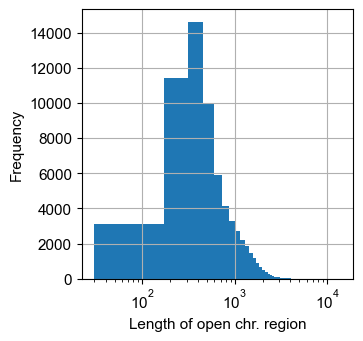

In [12]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)
peak_len_1=Chr_acc_peaks_sel1[:]["chromEnd"] -Chr_acc_peaks_sel1[:]["chromStart"]
plt.hist(peak_len_1,bins=100)
plt.grid()
plt.xscale("log")
plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Frequency",fontname = "Arial",fontsize=11)
plt.xlabel("Length of open chr. region",fontname = "Arial",fontsize=11)

print("mean peak length:",np.mean(peak_len_1))
print("median peak length:",np.median(peak_len_1))

print("min peak length:",np.min(peak_len_1))
print("max peak length:",np.max(peak_len_1))

# Check if clusters or elements are in proximity to open chr regions

## This method does not take the length of the clusters or elements into account, but the centre positions

In [17]:
#get centres of open chr regions, split by chrom.
Chr_acc_peaks_all_chrs=[]
for i in range(len(chr_list_3)):
    Chr_acc_peaks_all_chrs.append(positions_elements_3(peak_input=Chr_acc_peaks_sel1,chr_sel_name="chrom",chr_sel=chr_list_3[i],chr_start="chromStart",chr_stop="chromEnd"))
    
    

In [34]:
#check proximity for elements

#elements
#fraction of input_1 elements in proximity to input_2 elements
#fraction_in_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_1_input=Chr_acc_peaks_all_chrs,pos_2_input=pos_x_list_3,dist=10000)

#fraction of input_2 elements in proximity to input_1 elements  #cluster_centers_all_3, pos_x_list_3
fraction_in_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=pos_x_list_3,dist=1000)

In [35]:
#check proximity for clusters


#use cluster centres

#fraction of input_1 elements in proximity to input_2 elements
#fraction_in_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_1_input=Chr_acc_peaks_all_chrs,pos_2_input=pos_x_list_3,dist=10000)

#fraction of input_2 elements in proximity to input_1 elements  #cluster_centers_all_3, pos_x_list_3
fraction_in_range_cluster_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=cluster_centers_all_3,dist=1000)

In [36]:
#check proximity for uniformly distributed elements

#rd position
#fraction of input_1 elements in proximity to input_2 elements
#fraction_in_range_2_rd=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_1_input=Chr_acc_peaks_all_chrs,pos_2_input=pos_rd_x_list_3,dist=10000)

#fraction of input_2 elements in proximity to input_1 elements
fraction_in_range_2_rd=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=pos_rd_x_list_3,dist=1000)

In [37]:
#get mean of proximity from all chroms.

fraction_in_range_2_mean=[]
for i in range(len(fraction_in_range_2)):
    fraction_in_range_2_mean.append(np.mean(fraction_in_range_2[i]))
    
    
fraction_in_range_cluster_2_mean=[]
for i in range(len(fraction_in_range_cluster_2)):
    fraction_in_range_cluster_2_mean.append(np.mean(fraction_in_range_cluster_2[i]))
    
fraction_in_range_2_rd_mean=[]
for i in range(len(fraction_in_range_2_rd)):
    fraction_in_range_2_rd_mean.append(np.mean(fraction_in_range_2_rd[i]))
    


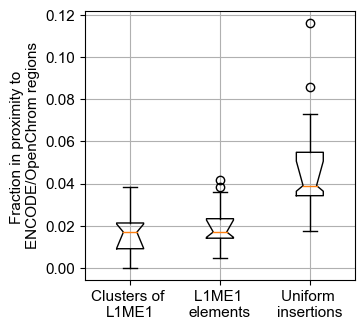

In [38]:
###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

#ax1.boxplot([fraction_in_range_2_mean,fraction_in_range_2_rd_mean],labels=["Rep. elements","Hom. positions"],showfliers=True,notch=True,bootstrap=1000)


ax1.boxplot([fraction_in_range_cluster_2_mean,fraction_in_range_2_mean,fraction_in_range_2_rd_mean],labels=["Clusters of \nL1ME1","L1ME1 \nelements","Uniform \ninsertions"],showfliers=True,notch=True,bootstrap=10000)


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_1.pdf",format="pdf",bbox_inches="tight")
#plt.show()

In [39]:
#verify that same number of transposons and random elements are used
print(len(pos_rd_x_list_3[10]))
print(len(pos_x_list_3[10]))

1354
1354


# Check proximity of TE clusters to open chrom by number of cluster elements

## i.e: are clusters with more elements more/less often in proximity to open chrom?

In [40]:
#DBSCAN parameters
eps_3b=1e4
min_samples_3b=2

#clusters are split into classes that contain a number of points given in the following list:
points_in_clusters_3b=[[2,5],[5,10000000]]


centres_clusters_by_range_all_chr_3,sizes_clusters_by_range_all_chr_3,noise_all_chr_3,noise_size_all_chr_3,centres_clusters_by_range_rd_all_chr_3,sizes_clusters_by_range_rd_all_chr_3,noise_all_chr_rd_3,noise_size_chr_rd_3=DB_scan_appl_8(eps=eps_3b,min_samples=min_samples_3b,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3,len_x_list=len_x_list_3,points_in_clusters=points_in_clusters_3b)



In [41]:
#select range interval and split data by chromosomes

dist_for_prox=1000
range_sel_u=0
clusters_in_range_cluster_element_range_1=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=[sublist[range_sel_u] for sublist in centres_clusters_by_range_all_chr_3],dist=dist_for_prox)



range_sel_u=1
clusters_in_range_cluster_element_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=[sublist[range_sel_u] for sublist in centres_clusters_by_range_all_chr_3],dist=dist_for_prox)


noise_in_range_1=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=noise_all_chr_3,dist=dist_for_prox)

In [42]:
#get mean of proximity from all chroms.

clusters_in_range_cluster_element_range_1_mean=[]
for i in range(len(clusters_in_range_cluster_element_range_1)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(clusters_in_range_cluster_element_range_1[i])>0:
        clusters_in_range_cluster_element_range_1_mean.append(np.mean(clusters_in_range_cluster_element_range_1[i]))
    
    
clusters_in_range_cluster_element_range_2_mean=[]
for i in range(len(clusters_in_range_cluster_element_range_2)):
    if len(clusters_in_range_cluster_element_range_2[i])>0:
        clusters_in_range_cluster_element_range_2_mean.append(np.mean(clusters_in_range_cluster_element_range_2[i]))
    
noise_in_range_1_mean=[]
for i in range(len(noise_in_range_1)):
    if len(noise_in_range_1[i])>0:
        noise_in_range_1_mean.append(np.mean(noise_in_range_1[i]))    

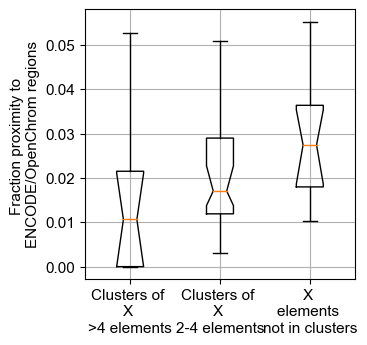

In [43]:
###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([clusters_in_range_cluster_element_range_2_mean,clusters_in_range_cluster_element_range_1_mean,noise_in_range_1_mean],labels=["Clusters of \nX \n>4 elements","Clusters of \nX \n2-4 elements","X \nelements \nnot in clusters"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_1.pdf",format="pdf",bbox_inches="tight")
#plt.show()

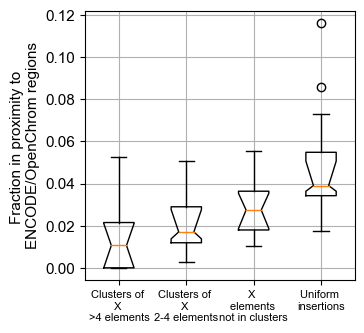

In [44]:
###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([clusters_in_range_cluster_element_range_2_mean,clusters_in_range_cluster_element_range_1_mean,noise_in_range_1_mean,fraction_in_range_2_rd_mean],labels=["Clusters of \nX \n>4 elements","Clusters of \nX \n2-4 elements","X \nelements \nnot in clusters","Uniform \ninsertions"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=8) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_2.pdf",format="pdf",bbox_inches="tight")
#plt.show()

In [45]:
#print number of clusters on each chrom. for all cluster sizes 
cl_num=[clusters_in_range_cluster_element_range_2,clusters_in_range_cluster_element_range_1,noise_in_range_1,fraction_in_range_2_rd]

for i in range(len(cl_num)):
    print("############")
    print("cluster size",i)
    
    for j in range(len(cl_num[i])):
        print("elements in",chr_list_3[j],":",len(cl_num[i][j]))
        
    print(np.sum(np.sum(cl_num[i])))

############
cluster size 0
elements in chr1 : 146
elements in chr2 : 159
elements in chr3 : 102
elements in chr4 : 90
elements in chr5 : 94
elements in chr6 : 95
elements in chr7 : 95
elements in chr8 : 75
elements in chr9 : 68
elements in chr10 : 92
elements in chr11 : 78
elements in chr12 : 86
elements in chr13 : 61
elements in chr14 : 65
elements in chr15 : 47
elements in chr16 : 37
elements in chr17 : 53
elements in chr18 : 55
elements in chr19 : 30
elements in chr20 : 33
elements in chr21 : 23
elements in chr22 : 19
elements in chrX : 87
19
############
cluster size 1
elements in chr1 : 418
elements in chr2 : 488
elements in chr3 : 390
elements in chr4 : 337
elements in chr5 : 352
elements in chr6 : 317
elements in chr7 : 290
elements in chr8 : 248
elements in chr9 : 253
elements in chr10 : 295
elements in chr11 : 218
elements in chr12 : 238
elements in chr13 : 186
elements in chr14 : 167
elements in chr15 : 176
elements in chr16 : 169
elements in chr17 : 158
elements in chr18 : 

/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


# Check for overlap with full legth of transposons/clusters and open chromatin regions

## This method takes the length of clusters or elements into account when calculating overlap with open chromatin

## Functions

In [7]:

#create df from chr_list, pos_list and len_list with id, chrom, start, stop, columns
def df_for_rd_positions_V1(chr_list, pos_rd_x_list, len_x_list):
    #create df for random elements with same length on same chr as elements on chr 
    col_create=["REGION_ID","CHROM","START","STOP"]
    df_rd_list=[]

    for i in range(len(chr_list)):
        #get chr
        chr_sel_list=[]
        rd_start_list=[]
        rd_stop_list=[]
        rd_id_list=[]
        count_1=0
    
        chr_sel=chr_list[i]
        for j in range(len(pos_rd_x_list[i])):
            #get pos
            start_sel=int(np.round(pos_rd_x_list[i][j]-len_x_list[i][j]/2 ,0))
            stop_sel=int(np.round(pos_rd_x_list[i][j]+len_x_list[i][j]/2 ,0))
            
            chr_sel_list.append(chr_sel)
            rd_start_list.append(start_sel)
            rd_stop_list.append(stop_sel)
            rd_id_list.append(count_1)
            count_1=count_1+1
            
        all_data={col_create[0]:rd_id_list,
             col_create[1]:chr_sel_list,
             col_create[2]:rd_start_list,
             col_create[3]:rd_stop_list}  
    
        df_rd=pd.DataFrame(all_data)
        df_rd_list.append(df_rd)
    return df_rd_list


#create df with cluster id, chrom, start and stop
#for chromosome and each detected cluster list for specified range of points (e.g. all cluster with 2-4 and all with >4 points) 
def df_for_cluster_positions_V1(chr_list,centres_clusters_by_range_all_chr,sizes_clusters_by_range_all_chr):
    #create df for random elements with same length on same chr as elements on chr 
    col_create=["REGION_ID","CHROM","START","STOP"]
    df_rd_list=[]

    for i in range(len(chr_list)): #chromosomes
        #get chr
 
        
    
        chr_sel=chr_list[i]
        df_rd_cluster_list=[]
        for j in range(len(centres_clusters_by_range_all_chr[i])): #cluster sizes
            count_1=0
            chr_sel_list=[]
            rd_start_list=[]
            rd_stop_list=[]
            rd_id_list=[]
            all_data={}
            for k in range(len(centres_clusters_by_range_all_chr[i][j])): #entries for each cluster size
                
                start_sel=int(np.round(centres_clusters_by_range_all_chr[i][j][k]-sizes_clusters_by_range_all_chr[i][j][k]/2 ,0))
                stop_sel=int(np.round(centres_clusters_by_range_all_chr[i][j][k]+sizes_clusters_by_range_all_chr[i][j][k]/2 ,0))

                chr_sel_list.append(chr_sel)
                rd_start_list.append(start_sel)
                rd_stop_list.append(stop_sel)
                rd_id_list.append(count_1)
                count_1=count_1+1

                all_data={col_create[0]:rd_id_list,
                     col_create[1]:chr_sel_list,
                     col_create[2]:rd_start_list,
                     col_create[3]:rd_stop_list}  
    
            df_rd=pd.DataFrame(all_data)
            df_rd_cluster_list.append(df_rd)
        df_rd_list.append(df_rd_cluster_list)
    return df_rd_list 
    
    
#https://stackoverflow.com/questions/16691524/calculating-the-overlap-distance-of-two-1d-line-segments
def calc_overlap(min1, max1, min2, max2):
    return max(0, min(max1, max2) - max(min1, min2))

#overlap for arrays
def calc_overlap_V2(max1, max2, min1, min2):
    result = np.maximum(0, np.minimum(max1, max2) - np.maximum(min1, min2))
    return result
#overlap for arrays, with distance separation if no overlap
def calc_overlap_V3(max1, max2, min1, min2):
    result = np.minimum(max1, max2) - np.maximum(min1, min2)
    return result

#check for each element in df1 if at least on element in df2 overlaps it (on the same chr)
def check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1, df2, chr_name_1,start_name_1,stop_name_1, chr_name_2,start_name_2,stop_name_2,min_dist=0):
    
    bool_overlap_entries=[] #if at least one element in df2 overlaps element i in df1
    
    for i in range(len(df1)):
        #get chr, start and stop of entry in df1
        chr_sel=df1.iloc[i][chr_name_1]
        start_sel=df1.iloc[i][start_name_1]
        stop_sel=df1.iloc[i][stop_name_1]
        
        #select sub dataframe on df2 with same chr
        df2_sel_chr=df2[df2[chr_name_2]==chr_sel]
        
        
        ###
        #get arrays of all start and stop points on chr
        start_sel_df2=df2_sel_chr.iloc[:][start_name_2].to_numpy()
        stop_sel_df2=df2_sel_chr.iloc[:][stop_name_2].to_numpy()
        
        overlap_array=calc_overlap_V3(min1=start_sel,max1=stop_sel,min2=start_sel_df2,max2=stop_sel_df2)
        ###
        bool_overlap_e=0
        if any(x > min_dist for x in overlap_array):
            bool_overlap_e=1
        
        
        '''#check if element in df2 on same chr overlaps selected element in df1
        bool_overlap_e=0
        for j in range(len(df2_sel_chr)):
            start_sel_df2=df2_sel_chr.iloc[j][start_name_2]
            stop_sel_df2=df2_sel_chr.iloc[j][stop_name_2]
            #print(start_sel,stop_sel,"#",start_sel_df2,stop_sel_df2)
            
            overlap=calc_overlap(min1=start_sel,max1=stop_sel,min2=start_sel_df2,max2=stop_sel_df2)
            if overlap>0:
                bool_overlap_e=1
                break'''

        bool_overlap_entries.append(bool_overlap_e) 
        print(i,"/",len(df1)-1)
    return bool_overlap_entries

## Prepare data for overlap analysis

In [47]:
#create a data frame with random, hom. distr. points (have same lengths as transposons)
df_rd_pos_3=df_for_rd_positions_V1(chr_list=chr_list_3, pos_rd_x_list=pos_rd_x_list_3, len_x_list=len_x_list_3)

print("mean length of rd insertions:",np.mean([i for j in len_x_list_3 for i in j]))

#create a data frame for cluster positions split by chr and by number of points in cluster
df_cluster_pos_3=df_for_cluster_positions_V1(chr_list=chr_list_3,centres_clusters_by_range_all_chr=centres_clusters_by_range_all_chr_3,sizes_clusters_by_range_all_chr=sizes_clusters_by_range_all_chr_3)

#create a data frame for points not in clusters (same funtion as for rd points)
df_no_cluster_pos_3=df_for_rd_positions_V1(chr_list=chr_list_3, pos_rd_x_list=noise_all_chr_3, len_x_list=noise_size_all_chr_3)

print("mean length of transposons def. as noise points:",np.mean([i for j in noise_size_all_chr_3 for i in j]))

#create a data frame for random cluster positions split by chr and by number of points in cluster
df_cluster_pos_rd_3=df_for_cluster_positions_V1(chr_list=chr_list_3,centres_clusters_by_range_all_chr=centres_clusters_by_range_rd_all_chr_3,sizes_clusters_by_range_all_chr=sizes_clusters_by_range_rd_all_chr_3)


#create a data frame for random points not in clusters
df_no_cluster_pos_rd_3=df_for_rd_positions_V1(chr_list=chr_list_3, pos_rd_x_list=noise_all_chr_rd_3, len_x_list=noise_size_chr_rd_3)

print("mean length of random insertions def. as noise points:",np.mean([i for j in noise_size_chr_rd_3 for i in j]))

mean length of rd insertions: 480.5730630716767
mean length of transposons def. as noise points: 463.0964927586809
mean length of random insertions def. as noise points: 479.8017265166148


In [48]:
#lengths of transposon clusters
length_cluster_1=[]
for i in range(len(sizes_clusters_by_range_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_all_chr_3[i][0])):
        length_cluster_1.append(sizes_clusters_by_range_all_chr_3[i][0][j])
 
print("mean length clusters 2-4:",np.mean(length_cluster_1))

length_cluster_2=[]
for i in range(len(sizes_clusters_by_range_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_all_chr_3[i][1])):
        length_cluster_2.append(sizes_clusters_by_range_all_chr_3[i][1][j])
 
print("mean length clusters >4:",np.mean(length_cluster_2))

length_cluster_all=np.concatenate((length_cluster_1,length_cluster_2))
print("mean+std length all clusters:",np.mean(length_cluster_all),",",np.std(length_cluster_all))
print("max, min length all clusters:",np.max(length_cluster_all),",",np.min(length_cluster_all))

mean length clusters 2-4: 2492.9958029197082
mean length clusters >4: 7102.226035502958
mean+std length all clusters: 3579.41129707113 , 3461.7441694688323
max, min length all clusters: 31645.0 , 117.0


In [49]:
#lengths of clusters of hom. distr. points
length_rd_cluster_1=[]
for i in range(len(sizes_clusters_by_range_rd_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_rd_all_chr_3[i][0])):
        length_rd_cluster_1.append(sizes_clusters_by_range_rd_all_chr_3[i][0][j])
 
print("mean length clusters 2-4:",np.mean(length_rd_cluster_1))

length_rd_cluster_2=[]
for i in range(len(sizes_clusters_by_range_rd_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_rd_all_chr_3[i][1])):
        length_rd_cluster_2.append(sizes_clusters_by_range_rd_all_chr_3[i][1][j])
 
print("mean length clusters >4:",np.mean(length_rd_cluster_2))

length_rd_cluster_all=np.concatenate((length_rd_cluster_1,length_rd_cluster_2))
print("mean+std length all clusters:",np.mean(length_rd_cluster_all),",",np.std(length_rd_cluster_all))
print("max, min length all clusters:",np.max(length_rd_cluster_all),",",np.min(length_rd_cluster_all))

mean length clusters 2-4: 6019.537956722242
mean length clusters >4: 27480.5
mean+std length all clusters: 6034.753101736973 , 3607.766261799968
max, min length all clusters: 32556.0 , 212.0


# Calculate overlap

In [50]:
#maximum separation between closet points of regions
max_sep_regions=0 #-1000

In [51]:
%%time
#overlap of clusters with open chromatin
mean_overlap_clusters=[]
for i in range(len(chr_list_3)):
    mean_overlap_clusters_e=[]
    for j in range(len(df_cluster_pos_3[i])):
        overlap_clusters_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_3[i][j], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
        mean_overlap_clusters_e.append(overlap_clusters_open_chr_e)
    mean_overlap_clusters.append(mean_overlap_clusters_e)

0 / 417
1 / 417
2 / 417
3 / 417
4 / 417
5 / 417
6 / 417
7 / 417
8 / 417
9 / 417
10 / 417
11 / 417
12 / 417
13 / 417
14 / 417
15 / 417
16 / 417
17 / 417
18 / 417
19 / 417
20 / 417
21 / 417
22 / 417
23 / 417
24 / 417
25 / 417
26 / 417
27 / 417
28 / 417
29 / 417
30 / 417
31 / 417
32 / 417
33 / 417
34 / 417
35 / 417
36 / 417
37 / 417
38 / 417
39 / 417
40 / 417
41 / 417
42 / 417
43 / 417
44 / 417
45 / 417
46 / 417
47 / 417
48 / 417
49 / 417
50 / 417
51 / 417
52 / 417
53 / 417
54 / 417
55 / 417
56 / 417
57 / 417
58 / 417
59 / 417
60 / 417
61 / 417
62 / 417
63 / 417
64 / 417
65 / 417
66 / 417
67 / 417
68 / 417
69 / 417
70 / 417
71 / 417
72 / 417
73 / 417
74 / 417
75 / 417
76 / 417
77 / 417
78 / 417
79 / 417
80 / 417
81 / 417
82 / 417
83 / 417
84 / 417
85 / 417
86 / 417
87 / 417
88 / 417
89 / 417
90 / 417
91 / 417
92 / 417
93 / 417
94 / 417
95 / 417
96 / 417
97 / 417
98 / 417
99 / 417
100 / 417
101 / 417
102 / 417
103 / 417
104 / 417
105 / 417
106 / 417
107 / 417
108 / 417
109 / 417
110 / 417


364 / 487
365 / 487
366 / 487
367 / 487
368 / 487
369 / 487
370 / 487
371 / 487
372 / 487
373 / 487
374 / 487
375 / 487
376 / 487
377 / 487
378 / 487
379 / 487
380 / 487
381 / 487
382 / 487
383 / 487
384 / 487
385 / 487
386 / 487
387 / 487
388 / 487
389 / 487
390 / 487
391 / 487
392 / 487
393 / 487
394 / 487
395 / 487
396 / 487
397 / 487
398 / 487
399 / 487
400 / 487
401 / 487
402 / 487
403 / 487
404 / 487
405 / 487
406 / 487
407 / 487
408 / 487
409 / 487
410 / 487
411 / 487
412 / 487
413 / 487
414 / 487
415 / 487
416 / 487
417 / 487
418 / 487
419 / 487
420 / 487
421 / 487
422 / 487
423 / 487
424 / 487
425 / 487
426 / 487
427 / 487
428 / 487
429 / 487
430 / 487
431 / 487
432 / 487
433 / 487
434 / 487
435 / 487
436 / 487
437 / 487
438 / 487
439 / 487
440 / 487
441 / 487
442 / 487
443 / 487
444 / 487
445 / 487
446 / 487
447 / 487
448 / 487
449 / 487
450 / 487
451 / 487
452 / 487
453 / 487
454 / 487
455 / 487
456 / 487
457 / 487
458 / 487
459 / 487
460 / 487
461 / 487
462 / 487
463 / 487


141 / 336
142 / 336
143 / 336
144 / 336
145 / 336
146 / 336
147 / 336
148 / 336
149 / 336
150 / 336
151 / 336
152 / 336
153 / 336
154 / 336
155 / 336
156 / 336
157 / 336
158 / 336
159 / 336
160 / 336
161 / 336
162 / 336
163 / 336
164 / 336
165 / 336
166 / 336
167 / 336
168 / 336
169 / 336
170 / 336
171 / 336
172 / 336
173 / 336
174 / 336
175 / 336
176 / 336
177 / 336
178 / 336
179 / 336
180 / 336
181 / 336
182 / 336
183 / 336
184 / 336
185 / 336
186 / 336
187 / 336
188 / 336
189 / 336
190 / 336
191 / 336
192 / 336
193 / 336
194 / 336
195 / 336
196 / 336
197 / 336
198 / 336
199 / 336
200 / 336
201 / 336
202 / 336
203 / 336
204 / 336
205 / 336
206 / 336
207 / 336
208 / 336
209 / 336
210 / 336
211 / 336
212 / 336
213 / 336
214 / 336
215 / 336
216 / 336
217 / 336
218 / 336
219 / 336
220 / 336
221 / 336
222 / 336
223 / 336
224 / 336
225 / 336
226 / 336
227 / 336
228 / 336
229 / 336
230 / 336
231 / 336
232 / 336
233 / 336
234 / 336
235 / 336
236 / 336
237 / 336
238 / 336
239 / 336
240 / 336


235 / 316
236 / 316
237 / 316
238 / 316
239 / 316
240 / 316
241 / 316
242 / 316
243 / 316
244 / 316
245 / 316
246 / 316
247 / 316
248 / 316
249 / 316
250 / 316
251 / 316
252 / 316
253 / 316
254 / 316
255 / 316
256 / 316
257 / 316
258 / 316
259 / 316
260 / 316
261 / 316
262 / 316
263 / 316
264 / 316
265 / 316
266 / 316
267 / 316
268 / 316
269 / 316
270 / 316
271 / 316
272 / 316
273 / 316
274 / 316
275 / 316
276 / 316
277 / 316
278 / 316
279 / 316
280 / 316
281 / 316
282 / 316
283 / 316
284 / 316
285 / 316
286 / 316
287 / 316
288 / 316
289 / 316
290 / 316
291 / 316
292 / 316
293 / 316
294 / 316
295 / 316
296 / 316
297 / 316
298 / 316
299 / 316
300 / 316
301 / 316
302 / 316
303 / 316
304 / 316
305 / 316
306 / 316
307 / 316
308 / 316
309 / 316
310 / 316
311 / 316
312 / 316
313 / 316
314 / 316
315 / 316
316 / 316
0 / 94
1 / 94
2 / 94
3 / 94
4 / 94
5 / 94
6 / 94
7 / 94
8 / 94
9 / 94
10 / 94
11 / 94
12 / 94
13 / 94
14 / 94
15 / 94
16 / 94
17 / 94
18 / 94
19 / 94
20 / 94
21 / 94
22 / 94
23 / 9

71 / 252
72 / 252
73 / 252
74 / 252
75 / 252
76 / 252
77 / 252
78 / 252
79 / 252
80 / 252
81 / 252
82 / 252
83 / 252
84 / 252
85 / 252
86 / 252
87 / 252
88 / 252
89 / 252
90 / 252
91 / 252
92 / 252
93 / 252
94 / 252
95 / 252
96 / 252
97 / 252
98 / 252
99 / 252
100 / 252
101 / 252
102 / 252
103 / 252
104 / 252
105 / 252
106 / 252
107 / 252
108 / 252
109 / 252
110 / 252
111 / 252
112 / 252
113 / 252
114 / 252
115 / 252
116 / 252
117 / 252
118 / 252
119 / 252
120 / 252
121 / 252
122 / 252
123 / 252
124 / 252
125 / 252
126 / 252
127 / 252
128 / 252
129 / 252
130 / 252
131 / 252
132 / 252
133 / 252
134 / 252
135 / 252
136 / 252
137 / 252
138 / 252
139 / 252
140 / 252
141 / 252
142 / 252
143 / 252
144 / 252
145 / 252
146 / 252
147 / 252
148 / 252
149 / 252
150 / 252
151 / 252
152 / 252
153 / 252
154 / 252
155 / 252
156 / 252
157 / 252
158 / 252
159 / 252
160 / 252
161 / 252
162 / 252
163 / 252
164 / 252
165 / 252
166 / 252
167 / 252
168 / 252
169 / 252
170 / 252
171 / 252
172 / 252
173 / 252

37 / 237
38 / 237
39 / 237
40 / 237
41 / 237
42 / 237
43 / 237
44 / 237
45 / 237
46 / 237
47 / 237
48 / 237
49 / 237
50 / 237
51 / 237
52 / 237
53 / 237
54 / 237
55 / 237
56 / 237
57 / 237
58 / 237
59 / 237
60 / 237
61 / 237
62 / 237
63 / 237
64 / 237
65 / 237
66 / 237
67 / 237
68 / 237
69 / 237
70 / 237
71 / 237
72 / 237
73 / 237
74 / 237
75 / 237
76 / 237
77 / 237
78 / 237
79 / 237
80 / 237
81 / 237
82 / 237
83 / 237
84 / 237
85 / 237
86 / 237
87 / 237
88 / 237
89 / 237
90 / 237
91 / 237
92 / 237
93 / 237
94 / 237
95 / 237
96 / 237
97 / 237
98 / 237
99 / 237
100 / 237
101 / 237
102 / 237
103 / 237
104 / 237
105 / 237
106 / 237
107 / 237
108 / 237
109 / 237
110 / 237
111 / 237
112 / 237
113 / 237
114 / 237
115 / 237
116 / 237
117 / 237
118 / 237
119 / 237
120 / 237
121 / 237
122 / 237
123 / 237
124 / 237
125 / 237
126 / 237
127 / 237
128 / 237
129 / 237
130 / 237
131 / 237
132 / 237
133 / 237
134 / 237
135 / 237
136 / 237
137 / 237
138 / 237
139 / 237
140 / 237
141 / 237
142 / 237
143

151 / 175
152 / 175
153 / 175
154 / 175
155 / 175
156 / 175
157 / 175
158 / 175
159 / 175
160 / 175
161 / 175
162 / 175
163 / 175
164 / 175
165 / 175
166 / 175
167 / 175
168 / 175
169 / 175
170 / 175
171 / 175
172 / 175
173 / 175
174 / 175
175 / 175
0 / 46
1 / 46
2 / 46
3 / 46
4 / 46
5 / 46
6 / 46
7 / 46
8 / 46
9 / 46
10 / 46
11 / 46
12 / 46
13 / 46
14 / 46
15 / 46
16 / 46
17 / 46
18 / 46
19 / 46
20 / 46
21 / 46
22 / 46
23 / 46
24 / 46
25 / 46
26 / 46
27 / 46
28 / 46
29 / 46
30 / 46
31 / 46
32 / 46
33 / 46
34 / 46
35 / 46
36 / 46
37 / 46
38 / 46
39 / 46
40 / 46
41 / 46
42 / 46
43 / 46
44 / 46
45 / 46
46 / 46
0 / 168
1 / 168
2 / 168
3 / 168
4 / 168
5 / 168
6 / 168
7 / 168
8 / 168
9 / 168
10 / 168
11 / 168
12 / 168
13 / 168
14 / 168
15 / 168
16 / 168
17 / 168
18 / 168
19 / 168
20 / 168
21 / 168
22 / 168
23 / 168
24 / 168
25 / 168
26 / 168
27 / 168
28 / 168
29 / 168
30 / 168
31 / 168
32 / 168
33 / 168
34 / 168
35 / 168
36 / 168
37 / 168
38 / 168
39 / 168
40 / 168
41 / 168
42 / 168
43 / 16

8 / 65
9 / 65
10 / 65
11 / 65
12 / 65
13 / 65
14 / 65
15 / 65
16 / 65
17 / 65
18 / 65
19 / 65
20 / 65
21 / 65
22 / 65
23 / 65
24 / 65
25 / 65
26 / 65
27 / 65
28 / 65
29 / 65
30 / 65
31 / 65
32 / 65
33 / 65
34 / 65
35 / 65
36 / 65
37 / 65
38 / 65
39 / 65
40 / 65
41 / 65
42 / 65
43 / 65
44 / 65
45 / 65
46 / 65
47 / 65
48 / 65
49 / 65
50 / 65
51 / 65
52 / 65
53 / 65
54 / 65
55 / 65
56 / 65
57 / 65
58 / 65
59 / 65
60 / 65
61 / 65
62 / 65
63 / 65
64 / 65
65 / 65
0 / 22
1 / 22
2 / 22
3 / 22
4 / 22
5 / 22
6 / 22
7 / 22
8 / 22
9 / 22
10 / 22
11 / 22
12 / 22
13 / 22
14 / 22
15 / 22
16 / 22
17 / 22
18 / 22
19 / 22
20 / 22
21 / 22
22 / 22
0 / 58
1 / 58
2 / 58
3 / 58
4 / 58
5 / 58
6 / 58
7 / 58
8 / 58
9 / 58
10 / 58
11 / 58
12 / 58
13 / 58
14 / 58
15 / 58
16 / 58
17 / 58
18 / 58
19 / 58
20 / 58
21 / 58
22 / 58
23 / 58
24 / 58
25 / 58
26 / 58
27 / 58
28 / 58
29 / 58
30 / 58
31 / 58
32 / 58
33 / 58
34 / 58
35 / 58
36 / 58
37 / 58
38 / 58
39 / 58
40 / 58
41 / 58
42 / 58
43 / 58
44 / 58
45 / 58
46 / 5

In [52]:
%%time
#overlap of random clusters with open chromatin
mean_overlap_rd_clusters=[]
for i in range(len(chr_list_3)):
    mean_overlap_rd_clusters_e=[]
    for j in range(len(df_cluster_pos_rd_3[i])):
        overlap_clusters_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_rd_3[i][j], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
        mean_overlap_rd_clusters_e.append(overlap_clusters_open_chr_e)
    mean_overlap_rd_clusters.append(mean_overlap_rd_clusters_e)

0 / 221
1 / 221
2 / 221
3 / 221
4 / 221
5 / 221
6 / 221
7 / 221
8 / 221
9 / 221
10 / 221
11 / 221
12 / 221
13 / 221
14 / 221
15 / 221
16 / 221
17 / 221
18 / 221
19 / 221
20 / 221
21 / 221
22 / 221
23 / 221
24 / 221
25 / 221
26 / 221
27 / 221
28 / 221
29 / 221
30 / 221
31 / 221
32 / 221
33 / 221
34 / 221
35 / 221
36 / 221
37 / 221
38 / 221
39 / 221
40 / 221
41 / 221
42 / 221
43 / 221
44 / 221
45 / 221
46 / 221
47 / 221
48 / 221
49 / 221
50 / 221
51 / 221
52 / 221
53 / 221
54 / 221
55 / 221
56 / 221
57 / 221
58 / 221
59 / 221
60 / 221
61 / 221
62 / 221
63 / 221
64 / 221
65 / 221
66 / 221
67 / 221
68 / 221
69 / 221
70 / 221
71 / 221
72 / 221
73 / 221
74 / 221
75 / 221
76 / 221
77 / 221
78 / 221
79 / 221
80 / 221
81 / 221
82 / 221
83 / 221
84 / 221
85 / 221
86 / 221
87 / 221
88 / 221
89 / 221
90 / 221
91 / 221
92 / 221
93 / 221
94 / 221
95 / 221
96 / 221
97 / 221
98 / 221
99 / 221
100 / 221
101 / 221
102 / 221
103 / 221
104 / 221
105 / 221
106 / 221
107 / 221
108 / 221
109 / 221
110 / 221


50 / 190
51 / 190
52 / 190
53 / 190
54 / 190
55 / 190
56 / 190
57 / 190
58 / 190
59 / 190
60 / 190
61 / 190
62 / 190
63 / 190
64 / 190
65 / 190
66 / 190
67 / 190
68 / 190
69 / 190
70 / 190
71 / 190
72 / 190
73 / 190
74 / 190
75 / 190
76 / 190
77 / 190
78 / 190
79 / 190
80 / 190
81 / 190
82 / 190
83 / 190
84 / 190
85 / 190
86 / 190
87 / 190
88 / 190
89 / 190
90 / 190
91 / 190
92 / 190
93 / 190
94 / 190
95 / 190
96 / 190
97 / 190
98 / 190
99 / 190
100 / 190
101 / 190
102 / 190
103 / 190
104 / 190
105 / 190
106 / 190
107 / 190
108 / 190
109 / 190
110 / 190
111 / 190
112 / 190
113 / 190
114 / 190
115 / 190
116 / 190
117 / 190
118 / 190
119 / 190
120 / 190
121 / 190
122 / 190
123 / 190
124 / 190
125 / 190
126 / 190
127 / 190
128 / 190
129 / 190
130 / 190
131 / 190
132 / 190
133 / 190
134 / 190
135 / 190
136 / 190
137 / 190
138 / 190
139 / 190
140 / 190
141 / 190
142 / 190
143 / 190
144 / 190
145 / 190
146 / 190
147 / 190
148 / 190
149 / 190
150 / 190
151 / 190
152 / 190
153 / 190
154 / 190


101 / 105
102 / 105
103 / 105
104 / 105
105 / 105
0 / 107
1 / 107
2 / 107
3 / 107
4 / 107
5 / 107
6 / 107
7 / 107
8 / 107
9 / 107
10 / 107
11 / 107
12 / 107
13 / 107
14 / 107
15 / 107
16 / 107
17 / 107
18 / 107
19 / 107
20 / 107
21 / 107
22 / 107
23 / 107
24 / 107
25 / 107
26 / 107
27 / 107
28 / 107
29 / 107
30 / 107
31 / 107
32 / 107
33 / 107
34 / 107
35 / 107
36 / 107
37 / 107
38 / 107
39 / 107
40 / 107
41 / 107
42 / 107
43 / 107
44 / 107
45 / 107
46 / 107
47 / 107
48 / 107
49 / 107
50 / 107
51 / 107
52 / 107
53 / 107
54 / 107
55 / 107
56 / 107
57 / 107
58 / 107
59 / 107
60 / 107
61 / 107
62 / 107
63 / 107
64 / 107
65 / 107
66 / 107
67 / 107
68 / 107
69 / 107
70 / 107
71 / 107
72 / 107
73 / 107
74 / 107
75 / 107
76 / 107
77 / 107
78 / 107
79 / 107
80 / 107
81 / 107
82 / 107
83 / 107
84 / 107
85 / 107
86 / 107
87 / 107
88 / 107
89 / 107
90 / 107
91 / 107
92 / 107
93 / 107
94 / 107
95 / 107
96 / 107
97 / 107
98 / 107
99 / 107
100 / 107
101 / 107
102 / 107
103 / 107
104 / 107
105 / 107


In [53]:
#get mean overlap percentages in each chromosome for 2-4 points and >4 points in clusters

min_num_points_cond=10
mean_overlap_clusters_range_1_mean=[]
for i in range(len(mean_overlap_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_clusters[i][0])>min_num_points_cond:
        mean_overlap_clusters_range_1_mean.append(np.mean(mean_overlap_clusters[i][0]))
    
mean_overlap_clusters_range_2_mean=[]
for i in range(len(mean_overlap_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_clusters[i][1])>min_num_points_cond:
        mean_overlap_clusters_range_2_mean.append(np.mean(mean_overlap_clusters[i][1]))
        
mean_overlap_cluster_range_all_mean=[]
for i in range(len(mean_overlap_clusters)):
    concat_overlap=np.concatenate((mean_overlap_clusters[i][0],mean_overlap_clusters[i][1]))
    if len(concat_overlap)>min_num_points_cond:
        mean_overlap_cluster_range_all_mean.append(np.mean(concat_overlap))
    
 
mean_overlap_rd_clusters_range_1_mean=[]
for i in range(len(mean_overlap_rd_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_rd_clusters[i][0])>min_num_points_cond:
        mean_overlap_rd_clusters_range_1_mean.append(np.mean(mean_overlap_rd_clusters[i][0]))
    
mean_overlap_rd_clusters_range_2_mean=[]
for i in range(len(mean_overlap_rd_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_rd_clusters[i][1])>min_num_points_cond:
        mean_overlap_rd_clusters_range_2_mean.append(np.mean(mean_overlap_rd_clusters[i][1]))

        
mean_overlap_rd_cluster_range_all_mean=[]
for i in range(len(mean_overlap_rd_clusters)):
    concat_overlap=np.concatenate((mean_overlap_rd_clusters[i][0],mean_overlap_rd_clusters[i][1]))
    if len(concat_overlap)>min_num_points_cond:
        mean_overlap_rd_cluster_range_all_mean.append(np.mean(concat_overlap))

In [54]:
%%time
#overlap all transposon positions or random positions with open chr
mean_overlap_tr_1=[]
mean_overlap_rd_1=[]
for i in range(len(chr_list_3)):
    overlap_tr_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=rmd_list_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="genoName",start_name_1="genoStart",stop_name_1="genoEnd", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    overlap_rd_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_rd_pos_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    
    mean_overlap_tr_1.append(overlap_tr_open_chr_e)
    mean_overlap_rd_1.append(overlap_rd_open_chr_e)
    

0 / 2526
1 / 2526
2 / 2526
3 / 2526
4 / 2526
5 / 2526
6 / 2526
7 / 2526
8 / 2526
9 / 2526
10 / 2526
11 / 2526
12 / 2526
13 / 2526
14 / 2526
15 / 2526
16 / 2526
17 / 2526
18 / 2526
19 / 2526
20 / 2526
21 / 2526
22 / 2526
23 / 2526
24 / 2526
25 / 2526
26 / 2526
27 / 2526
28 / 2526
29 / 2526
30 / 2526
31 / 2526
32 / 2526
33 / 2526
34 / 2526
35 / 2526
36 / 2526
37 / 2526
38 / 2526
39 / 2526
40 / 2526
41 / 2526
42 / 2526
43 / 2526
44 / 2526
45 / 2526
46 / 2526
47 / 2526
48 / 2526
49 / 2526
50 / 2526
51 / 2526
52 / 2526
53 / 2526
54 / 2526
55 / 2526
56 / 2526
57 / 2526
58 / 2526
59 / 2526
60 / 2526
61 / 2526
62 / 2526
63 / 2526
64 / 2526
65 / 2526
66 / 2526
67 / 2526
68 / 2526
69 / 2526
70 / 2526
71 / 2526
72 / 2526
73 / 2526
74 / 2526
75 / 2526
76 / 2526
77 / 2526
78 / 2526
79 / 2526
80 / 2526
81 / 2526
82 / 2526
83 / 2526
84 / 2526
85 / 2526
86 / 2526
87 / 2526
88 / 2526
89 / 2526
90 / 2526
91 / 2526
92 / 2526
93 / 2526
94 / 2526
95 / 2526
96 / 2526
97 / 2526
98 / 2526
99 / 2526
100 / 2526

774 / 2526
775 / 2526
776 / 2526
777 / 2526
778 / 2526
779 / 2526
780 / 2526
781 / 2526
782 / 2526
783 / 2526
784 / 2526
785 / 2526
786 / 2526
787 / 2526
788 / 2526
789 / 2526
790 / 2526
791 / 2526
792 / 2526
793 / 2526
794 / 2526
795 / 2526
796 / 2526
797 / 2526
798 / 2526
799 / 2526
800 / 2526
801 / 2526
802 / 2526
803 / 2526
804 / 2526
805 / 2526
806 / 2526
807 / 2526
808 / 2526
809 / 2526
810 / 2526
811 / 2526
812 / 2526
813 / 2526
814 / 2526
815 / 2526
816 / 2526
817 / 2526
818 / 2526
819 / 2526
820 / 2526
821 / 2526
822 / 2526
823 / 2526
824 / 2526
825 / 2526
826 / 2526
827 / 2526
828 / 2526
829 / 2526
830 / 2526
831 / 2526
832 / 2526
833 / 2526
834 / 2526
835 / 2526
836 / 2526
837 / 2526
838 / 2526
839 / 2526
840 / 2526
841 / 2526
842 / 2526
843 / 2526
844 / 2526
845 / 2526
846 / 2526
847 / 2526
848 / 2526
849 / 2526
850 / 2526
851 / 2526
852 / 2526
853 / 2526
854 / 2526
855 / 2526
856 / 2526
857 / 2526
858 / 2526
859 / 2526
860 / 2526
861 / 2526
862 / 2526
863 / 2526
864 / 2526

1478 / 2526
1479 / 2526
1480 / 2526
1481 / 2526
1482 / 2526
1483 / 2526
1484 / 2526
1485 / 2526
1486 / 2526
1487 / 2526
1488 / 2526
1489 / 2526
1490 / 2526
1491 / 2526
1492 / 2526
1493 / 2526
1494 / 2526
1495 / 2526
1496 / 2526
1497 / 2526
1498 / 2526
1499 / 2526
1500 / 2526
1501 / 2526
1502 / 2526
1503 / 2526
1504 / 2526
1505 / 2526
1506 / 2526
1507 / 2526
1508 / 2526
1509 / 2526
1510 / 2526
1511 / 2526
1512 / 2526
1513 / 2526
1514 / 2526
1515 / 2526
1516 / 2526
1517 / 2526
1518 / 2526
1519 / 2526
1520 / 2526
1521 / 2526
1522 / 2526
1523 / 2526
1524 / 2526
1525 / 2526
1526 / 2526
1527 / 2526
1528 / 2526
1529 / 2526
1530 / 2526
1531 / 2526
1532 / 2526
1533 / 2526
1534 / 2526
1535 / 2526
1536 / 2526
1537 / 2526
1538 / 2526
1539 / 2526
1540 / 2526
1541 / 2526
1542 / 2526
1543 / 2526
1544 / 2526
1545 / 2526
1546 / 2526
1547 / 2526
1548 / 2526
1549 / 2526
1550 / 2526
1551 / 2526
1552 / 2526
1553 / 2526
1554 / 2526
1555 / 2526
1556 / 2526
1557 / 2526
1558 / 2526
1559 / 2526
1560 / 2526
1561

2173 / 2526
2174 / 2526
2175 / 2526
2176 / 2526
2177 / 2526
2178 / 2526
2179 / 2526
2180 / 2526
2181 / 2526
2182 / 2526
2183 / 2526
2184 / 2526
2185 / 2526
2186 / 2526
2187 / 2526
2188 / 2526
2189 / 2526
2190 / 2526
2191 / 2526
2192 / 2526
2193 / 2526
2194 / 2526
2195 / 2526
2196 / 2526
2197 / 2526
2198 / 2526
2199 / 2526
2200 / 2526
2201 / 2526
2202 / 2526
2203 / 2526
2204 / 2526
2205 / 2526
2206 / 2526
2207 / 2526
2208 / 2526
2209 / 2526
2210 / 2526
2211 / 2526
2212 / 2526
2213 / 2526
2214 / 2526
2215 / 2526
2216 / 2526
2217 / 2526
2218 / 2526
2219 / 2526
2220 / 2526
2221 / 2526
2222 / 2526
2223 / 2526
2224 / 2526
2225 / 2526
2226 / 2526
2227 / 2526
2228 / 2526
2229 / 2526
2230 / 2526
2231 / 2526
2232 / 2526
2233 / 2526
2234 / 2526
2235 / 2526
2236 / 2526
2237 / 2526
2238 / 2526
2239 / 2526
2240 / 2526
2241 / 2526
2242 / 2526
2243 / 2526
2244 / 2526
2245 / 2526
2246 / 2526
2247 / 2526
2248 / 2526
2249 / 2526
2250 / 2526
2251 / 2526
2252 / 2526
2253 / 2526
2254 / 2526
2255 / 2526
2256

397 / 2526
398 / 2526
399 / 2526
400 / 2526
401 / 2526
402 / 2526
403 / 2526
404 / 2526
405 / 2526
406 / 2526
407 / 2526
408 / 2526
409 / 2526
410 / 2526
411 / 2526
412 / 2526
413 / 2526
414 / 2526
415 / 2526
416 / 2526
417 / 2526
418 / 2526
419 / 2526
420 / 2526
421 / 2526
422 / 2526
423 / 2526
424 / 2526
425 / 2526
426 / 2526
427 / 2526
428 / 2526
429 / 2526
430 / 2526
431 / 2526
432 / 2526
433 / 2526
434 / 2526
435 / 2526
436 / 2526
437 / 2526
438 / 2526
439 / 2526
440 / 2526
441 / 2526
442 / 2526
443 / 2526
444 / 2526
445 / 2526
446 / 2526
447 / 2526
448 / 2526
449 / 2526
450 / 2526
451 / 2526
452 / 2526
453 / 2526
454 / 2526
455 / 2526
456 / 2526
457 / 2526
458 / 2526
459 / 2526
460 / 2526
461 / 2526
462 / 2526
463 / 2526
464 / 2526
465 / 2526
466 / 2526
467 / 2526
468 / 2526
469 / 2526
470 / 2526
471 / 2526
472 / 2526
473 / 2526
474 / 2526
475 / 2526
476 / 2526
477 / 2526
478 / 2526
479 / 2526
480 / 2526
481 / 2526
482 / 2526
483 / 2526
484 / 2526
485 / 2526
486 / 2526
487 / 2526

1136 / 2526
1137 / 2526
1138 / 2526
1139 / 2526
1140 / 2526
1141 / 2526
1142 / 2526
1143 / 2526
1144 / 2526
1145 / 2526
1146 / 2526
1147 / 2526
1148 / 2526
1149 / 2526
1150 / 2526
1151 / 2526
1152 / 2526
1153 / 2526
1154 / 2526
1155 / 2526
1156 / 2526
1157 / 2526
1158 / 2526
1159 / 2526
1160 / 2526
1161 / 2526
1162 / 2526
1163 / 2526
1164 / 2526
1165 / 2526
1166 / 2526
1167 / 2526
1168 / 2526
1169 / 2526
1170 / 2526
1171 / 2526
1172 / 2526
1173 / 2526
1174 / 2526
1175 / 2526
1176 / 2526
1177 / 2526
1178 / 2526
1179 / 2526
1180 / 2526
1181 / 2526
1182 / 2526
1183 / 2526
1184 / 2526
1185 / 2526
1186 / 2526
1187 / 2526
1188 / 2526
1189 / 2526
1190 / 2526
1191 / 2526
1192 / 2526
1193 / 2526
1194 / 2526
1195 / 2526
1196 / 2526
1197 / 2526
1198 / 2526
1199 / 2526
1200 / 2526
1201 / 2526
1202 / 2526
1203 / 2526
1204 / 2526
1205 / 2526
1206 / 2526
1207 / 2526
1208 / 2526
1209 / 2526
1210 / 2526
1211 / 2526
1212 / 2526
1213 / 2526
1214 / 2526
1215 / 2526
1216 / 2526
1217 / 2526
1218 / 2526
1219

1823 / 2526
1824 / 2526
1825 / 2526
1826 / 2526
1827 / 2526
1828 / 2526
1829 / 2526
1830 / 2526
1831 / 2526
1832 / 2526
1833 / 2526
1834 / 2526
1835 / 2526
1836 / 2526
1837 / 2526
1838 / 2526
1839 / 2526
1840 / 2526
1841 / 2526
1842 / 2526
1843 / 2526
1844 / 2526
1845 / 2526
1846 / 2526
1847 / 2526
1848 / 2526
1849 / 2526
1850 / 2526
1851 / 2526
1852 / 2526
1853 / 2526
1854 / 2526
1855 / 2526
1856 / 2526
1857 / 2526
1858 / 2526
1859 / 2526
1860 / 2526
1861 / 2526
1862 / 2526
1863 / 2526
1864 / 2526
1865 / 2526
1866 / 2526
1867 / 2526
1868 / 2526
1869 / 2526
1870 / 2526
1871 / 2526
1872 / 2526
1873 / 2526
1874 / 2526
1875 / 2526
1876 / 2526
1877 / 2526
1878 / 2526
1879 / 2526
1880 / 2526
1881 / 2526
1882 / 2526
1883 / 2526
1884 / 2526
1885 / 2526
1886 / 2526
1887 / 2526
1888 / 2526
1889 / 2526
1890 / 2526
1891 / 2526
1892 / 2526
1893 / 2526
1894 / 2526
1895 / 2526
1896 / 2526
1897 / 2526
1898 / 2526
1899 / 2526
1900 / 2526
1901 / 2526
1902 / 2526
1903 / 2526
1904 / 2526
1905 / 2526
1906

6 / 2826
7 / 2826
8 / 2826
9 / 2826
10 / 2826
11 / 2826
12 / 2826
13 / 2826
14 / 2826
15 / 2826
16 / 2826
17 / 2826
18 / 2826
19 / 2826
20 / 2826
21 / 2826
22 / 2826
23 / 2826
24 / 2826
25 / 2826
26 / 2826
27 / 2826
28 / 2826
29 / 2826
30 / 2826
31 / 2826
32 / 2826
33 / 2826
34 / 2826
35 / 2826
36 / 2826
37 / 2826
38 / 2826
39 / 2826
40 / 2826
41 / 2826
42 / 2826
43 / 2826
44 / 2826
45 / 2826
46 / 2826
47 / 2826
48 / 2826
49 / 2826
50 / 2826
51 / 2826
52 / 2826
53 / 2826
54 / 2826
55 / 2826
56 / 2826
57 / 2826
58 / 2826
59 / 2826
60 / 2826
61 / 2826
62 / 2826
63 / 2826
64 / 2826
65 / 2826
66 / 2826
67 / 2826
68 / 2826
69 / 2826
70 / 2826
71 / 2826
72 / 2826
73 / 2826
74 / 2826
75 / 2826
76 / 2826
77 / 2826
78 / 2826
79 / 2826
80 / 2826
81 / 2826
82 / 2826
83 / 2826
84 / 2826
85 / 2826
86 / 2826
87 / 2826
88 / 2826
89 / 2826
90 / 2826
91 / 2826
92 / 2826
93 / 2826
94 / 2826
95 / 2826
96 / 2826
97 / 2826
98 / 2826
99 / 2826
100 / 2826
101 / 2826
102 / 2826
103 / 2826
104 / 2826
105 / 282

812 / 2826
813 / 2826
814 / 2826
815 / 2826
816 / 2826
817 / 2826
818 / 2826
819 / 2826
820 / 2826
821 / 2826
822 / 2826
823 / 2826
824 / 2826
825 / 2826
826 / 2826
827 / 2826
828 / 2826
829 / 2826
830 / 2826
831 / 2826
832 / 2826
833 / 2826
834 / 2826
835 / 2826
836 / 2826
837 / 2826
838 / 2826
839 / 2826
840 / 2826
841 / 2826
842 / 2826
843 / 2826
844 / 2826
845 / 2826
846 / 2826
847 / 2826
848 / 2826
849 / 2826
850 / 2826
851 / 2826
852 / 2826
853 / 2826
854 / 2826
855 / 2826
856 / 2826
857 / 2826
858 / 2826
859 / 2826
860 / 2826
861 / 2826
862 / 2826
863 / 2826
864 / 2826
865 / 2826
866 / 2826
867 / 2826
868 / 2826
869 / 2826
870 / 2826
871 / 2826
872 / 2826
873 / 2826
874 / 2826
875 / 2826
876 / 2826
877 / 2826
878 / 2826
879 / 2826
880 / 2826
881 / 2826
882 / 2826
883 / 2826
884 / 2826
885 / 2826
886 / 2826
887 / 2826
888 / 2826
889 / 2826
890 / 2826
891 / 2826
892 / 2826
893 / 2826
894 / 2826
895 / 2826
896 / 2826
897 / 2826
898 / 2826
899 / 2826
900 / 2826
901 / 2826
902 / 2826

1518 / 2826
1519 / 2826
1520 / 2826
1521 / 2826
1522 / 2826
1523 / 2826
1524 / 2826
1525 / 2826
1526 / 2826
1527 / 2826
1528 / 2826
1529 / 2826
1530 / 2826
1531 / 2826
1532 / 2826
1533 / 2826
1534 / 2826
1535 / 2826
1536 / 2826
1537 / 2826
1538 / 2826
1539 / 2826
1540 / 2826
1541 / 2826
1542 / 2826
1543 / 2826
1544 / 2826
1545 / 2826
1546 / 2826
1547 / 2826
1548 / 2826
1549 / 2826
1550 / 2826
1551 / 2826
1552 / 2826
1553 / 2826
1554 / 2826
1555 / 2826
1556 / 2826
1557 / 2826
1558 / 2826
1559 / 2826
1560 / 2826
1561 / 2826
1562 / 2826
1563 / 2826
1564 / 2826
1565 / 2826
1566 / 2826
1567 / 2826
1568 / 2826
1569 / 2826
1570 / 2826
1571 / 2826
1572 / 2826
1573 / 2826
1574 / 2826
1575 / 2826
1576 / 2826
1577 / 2826
1578 / 2826
1579 / 2826
1580 / 2826
1581 / 2826
1582 / 2826
1583 / 2826
1584 / 2826
1585 / 2826
1586 / 2826
1587 / 2826
1588 / 2826
1589 / 2826
1590 / 2826
1591 / 2826
1592 / 2826
1593 / 2826
1594 / 2826
1595 / 2826
1596 / 2826
1597 / 2826
1598 / 2826
1599 / 2826
1600 / 2826
1601

2226 / 2826
2227 / 2826
2228 / 2826
2229 / 2826
2230 / 2826
2231 / 2826
2232 / 2826
2233 / 2826
2234 / 2826
2235 / 2826
2236 / 2826
2237 / 2826
2238 / 2826
2239 / 2826
2240 / 2826
2241 / 2826
2242 / 2826
2243 / 2826
2244 / 2826
2245 / 2826
2246 / 2826
2247 / 2826
2248 / 2826
2249 / 2826
2250 / 2826
2251 / 2826
2252 / 2826
2253 / 2826
2254 / 2826
2255 / 2826
2256 / 2826
2257 / 2826
2258 / 2826
2259 / 2826
2260 / 2826
2261 / 2826
2262 / 2826
2263 / 2826
2264 / 2826
2265 / 2826
2266 / 2826
2267 / 2826
2268 / 2826
2269 / 2826
2270 / 2826
2271 / 2826
2272 / 2826
2273 / 2826
2274 / 2826
2275 / 2826
2276 / 2826
2277 / 2826
2278 / 2826
2279 / 2826
2280 / 2826
2281 / 2826
2282 / 2826
2283 / 2826
2284 / 2826
2285 / 2826
2286 / 2826
2287 / 2826
2288 / 2826
2289 / 2826
2290 / 2826
2291 / 2826
2292 / 2826
2293 / 2826
2294 / 2826
2295 / 2826
2296 / 2826
2297 / 2826
2298 / 2826
2299 / 2826
2300 / 2826
2301 / 2826
2302 / 2826
2303 / 2826
2304 / 2826
2305 / 2826
2306 / 2826
2307 / 2826
2308 / 2826
2309

108 / 2826
109 / 2826
110 / 2826
111 / 2826
112 / 2826
113 / 2826
114 / 2826
115 / 2826
116 / 2826
117 / 2826
118 / 2826
119 / 2826
120 / 2826
121 / 2826
122 / 2826
123 / 2826
124 / 2826
125 / 2826
126 / 2826
127 / 2826
128 / 2826
129 / 2826
130 / 2826
131 / 2826
132 / 2826
133 / 2826
134 / 2826
135 / 2826
136 / 2826
137 / 2826
138 / 2826
139 / 2826
140 / 2826
141 / 2826
142 / 2826
143 / 2826
144 / 2826
145 / 2826
146 / 2826
147 / 2826
148 / 2826
149 / 2826
150 / 2826
151 / 2826
152 / 2826
153 / 2826
154 / 2826
155 / 2826
156 / 2826
157 / 2826
158 / 2826
159 / 2826
160 / 2826
161 / 2826
162 / 2826
163 / 2826
164 / 2826
165 / 2826
166 / 2826
167 / 2826
168 / 2826
169 / 2826
170 / 2826
171 / 2826
172 / 2826
173 / 2826
174 / 2826
175 / 2826
176 / 2826
177 / 2826
178 / 2826
179 / 2826
180 / 2826
181 / 2826
182 / 2826
183 / 2826
184 / 2826
185 / 2826
186 / 2826
187 / 2826
188 / 2826
189 / 2826
190 / 2826
191 / 2826
192 / 2826
193 / 2826
194 / 2826
195 / 2826
196 / 2826
197 / 2826
198 / 2826

855 / 2826
856 / 2826
857 / 2826
858 / 2826
859 / 2826
860 / 2826
861 / 2826
862 / 2826
863 / 2826
864 / 2826
865 / 2826
866 / 2826
867 / 2826
868 / 2826
869 / 2826
870 / 2826
871 / 2826
872 / 2826
873 / 2826
874 / 2826
875 / 2826
876 / 2826
877 / 2826
878 / 2826
879 / 2826
880 / 2826
881 / 2826
882 / 2826
883 / 2826
884 / 2826
885 / 2826
886 / 2826
887 / 2826
888 / 2826
889 / 2826
890 / 2826
891 / 2826
892 / 2826
893 / 2826
894 / 2826
895 / 2826
896 / 2826
897 / 2826
898 / 2826
899 / 2826
900 / 2826
901 / 2826
902 / 2826
903 / 2826
904 / 2826
905 / 2826
906 / 2826
907 / 2826
908 / 2826
909 / 2826
910 / 2826
911 / 2826
912 / 2826
913 / 2826
914 / 2826
915 / 2826
916 / 2826
917 / 2826
918 / 2826
919 / 2826
920 / 2826
921 / 2826
922 / 2826
923 / 2826
924 / 2826
925 / 2826
926 / 2826
927 / 2826
928 / 2826
929 / 2826
930 / 2826
931 / 2826
932 / 2826
933 / 2826
934 / 2826
935 / 2826
936 / 2826
937 / 2826
938 / 2826
939 / 2826
940 / 2826
941 / 2826
942 / 2826
943 / 2826
944 / 2826
945 / 2826

1570 / 2826
1571 / 2826
1572 / 2826
1573 / 2826
1574 / 2826
1575 / 2826
1576 / 2826
1577 / 2826
1578 / 2826
1579 / 2826
1580 / 2826
1581 / 2826
1582 / 2826
1583 / 2826
1584 / 2826
1585 / 2826
1586 / 2826
1587 / 2826
1588 / 2826
1589 / 2826
1590 / 2826
1591 / 2826
1592 / 2826
1593 / 2826
1594 / 2826
1595 / 2826
1596 / 2826
1597 / 2826
1598 / 2826
1599 / 2826
1600 / 2826
1601 / 2826
1602 / 2826
1603 / 2826
1604 / 2826
1605 / 2826
1606 / 2826
1607 / 2826
1608 / 2826
1609 / 2826
1610 / 2826
1611 / 2826
1612 / 2826
1613 / 2826
1614 / 2826
1615 / 2826
1616 / 2826
1617 / 2826
1618 / 2826
1619 / 2826
1620 / 2826
1621 / 2826
1622 / 2826
1623 / 2826
1624 / 2826
1625 / 2826
1626 / 2826
1627 / 2826
1628 / 2826
1629 / 2826
1630 / 2826
1631 / 2826
1632 / 2826
1633 / 2826
1634 / 2826
1635 / 2826
1636 / 2826
1637 / 2826
1638 / 2826
1639 / 2826
1640 / 2826
1641 / 2826
1642 / 2826
1643 / 2826
1644 / 2826
1645 / 2826
1646 / 2826
1647 / 2826
1648 / 2826
1649 / 2826
1650 / 2826
1651 / 2826
1652 / 2826
1653

2304 / 2826
2305 / 2826
2306 / 2826
2307 / 2826
2308 / 2826
2309 / 2826
2310 / 2826
2311 / 2826
2312 / 2826
2313 / 2826
2314 / 2826
2315 / 2826
2316 / 2826
2317 / 2826
2318 / 2826
2319 / 2826
2320 / 2826
2321 / 2826
2322 / 2826
2323 / 2826
2324 / 2826
2325 / 2826
2326 / 2826
2327 / 2826
2328 / 2826
2329 / 2826
2330 / 2826
2331 / 2826
2332 / 2826
2333 / 2826
2334 / 2826
2335 / 2826
2336 / 2826
2337 / 2826
2338 / 2826
2339 / 2826
2340 / 2826
2341 / 2826
2342 / 2826
2343 / 2826
2344 / 2826
2345 / 2826
2346 / 2826
2347 / 2826
2348 / 2826
2349 / 2826
2350 / 2826
2351 / 2826
2352 / 2826
2353 / 2826
2354 / 2826
2355 / 2826
2356 / 2826
2357 / 2826
2358 / 2826
2359 / 2826
2360 / 2826
2361 / 2826
2362 / 2826
2363 / 2826
2364 / 2826
2365 / 2826
2366 / 2826
2367 / 2826
2368 / 2826
2369 / 2826
2370 / 2826
2371 / 2826
2372 / 2826
2373 / 2826
2374 / 2826
2375 / 2826
2376 / 2826
2377 / 2826
2378 / 2826
2379 / 2826
2380 / 2826
2381 / 2826
2382 / 2826
2383 / 2826
2384 / 2826
2385 / 2826
2386 / 2826
2387

218 / 2158
219 / 2158
220 / 2158
221 / 2158
222 / 2158
223 / 2158
224 / 2158
225 / 2158
226 / 2158
227 / 2158
228 / 2158
229 / 2158
230 / 2158
231 / 2158
232 / 2158
233 / 2158
234 / 2158
235 / 2158
236 / 2158
237 / 2158
238 / 2158
239 / 2158
240 / 2158
241 / 2158
242 / 2158
243 / 2158
244 / 2158
245 / 2158
246 / 2158
247 / 2158
248 / 2158
249 / 2158
250 / 2158
251 / 2158
252 / 2158
253 / 2158
254 / 2158
255 / 2158
256 / 2158
257 / 2158
258 / 2158
259 / 2158
260 / 2158
261 / 2158
262 / 2158
263 / 2158
264 / 2158
265 / 2158
266 / 2158
267 / 2158
268 / 2158
269 / 2158
270 / 2158
271 / 2158
272 / 2158
273 / 2158
274 / 2158
275 / 2158
276 / 2158
277 / 2158
278 / 2158
279 / 2158
280 / 2158
281 / 2158
282 / 2158
283 / 2158
284 / 2158
285 / 2158
286 / 2158
287 / 2158
288 / 2158
289 / 2158
290 / 2158
291 / 2158
292 / 2158
293 / 2158
294 / 2158
295 / 2158
296 / 2158
297 / 2158
298 / 2158
299 / 2158
300 / 2158
301 / 2158
302 / 2158
303 / 2158
304 / 2158
305 / 2158
306 / 2158
307 / 2158
308 / 2158

1038 / 2158
1039 / 2158
1040 / 2158
1041 / 2158
1042 / 2158
1043 / 2158
1044 / 2158
1045 / 2158
1046 / 2158
1047 / 2158
1048 / 2158
1049 / 2158
1050 / 2158
1051 / 2158
1052 / 2158
1053 / 2158
1054 / 2158
1055 / 2158
1056 / 2158
1057 / 2158
1058 / 2158
1059 / 2158
1060 / 2158
1061 / 2158
1062 / 2158
1063 / 2158
1064 / 2158
1065 / 2158
1066 / 2158
1067 / 2158
1068 / 2158
1069 / 2158
1070 / 2158
1071 / 2158
1072 / 2158
1073 / 2158
1074 / 2158
1075 / 2158
1076 / 2158
1077 / 2158
1078 / 2158
1079 / 2158
1080 / 2158
1081 / 2158
1082 / 2158
1083 / 2158
1084 / 2158
1085 / 2158
1086 / 2158
1087 / 2158
1088 / 2158
1089 / 2158
1090 / 2158
1091 / 2158
1092 / 2158
1093 / 2158
1094 / 2158
1095 / 2158
1096 / 2158
1097 / 2158
1098 / 2158
1099 / 2158
1100 / 2158
1101 / 2158
1102 / 2158
1103 / 2158
1104 / 2158
1105 / 2158
1106 / 2158
1107 / 2158
1108 / 2158
1109 / 2158
1110 / 2158
1111 / 2158
1112 / 2158
1113 / 2158
1114 / 2158
1115 / 2158
1116 / 2158
1117 / 2158
1118 / 2158
1119 / 2158
1120 / 2158
1121

1772 / 2158
1773 / 2158
1774 / 2158
1775 / 2158
1776 / 2158
1777 / 2158
1778 / 2158
1779 / 2158
1780 / 2158
1781 / 2158
1782 / 2158
1783 / 2158
1784 / 2158
1785 / 2158
1786 / 2158
1787 / 2158
1788 / 2158
1789 / 2158
1790 / 2158
1791 / 2158
1792 / 2158
1793 / 2158
1794 / 2158
1795 / 2158
1796 / 2158
1797 / 2158
1798 / 2158
1799 / 2158
1800 / 2158
1801 / 2158
1802 / 2158
1803 / 2158
1804 / 2158
1805 / 2158
1806 / 2158
1807 / 2158
1808 / 2158
1809 / 2158
1810 / 2158
1811 / 2158
1812 / 2158
1813 / 2158
1814 / 2158
1815 / 2158
1816 / 2158
1817 / 2158
1818 / 2158
1819 / 2158
1820 / 2158
1821 / 2158
1822 / 2158
1823 / 2158
1824 / 2158
1825 / 2158
1826 / 2158
1827 / 2158
1828 / 2158
1829 / 2158
1830 / 2158
1831 / 2158
1832 / 2158
1833 / 2158
1834 / 2158
1835 / 2158
1836 / 2158
1837 / 2158
1838 / 2158
1839 / 2158
1840 / 2158
1841 / 2158
1842 / 2158
1843 / 2158
1844 / 2158
1845 / 2158
1846 / 2158
1847 / 2158
1848 / 2158
1849 / 2158
1850 / 2158
1851 / 2158
1852 / 2158
1853 / 2158
1854 / 2158
1855

344 / 2158
345 / 2158
346 / 2158
347 / 2158
348 / 2158
349 / 2158
350 / 2158
351 / 2158
352 / 2158
353 / 2158
354 / 2158
355 / 2158
356 / 2158
357 / 2158
358 / 2158
359 / 2158
360 / 2158
361 / 2158
362 / 2158
363 / 2158
364 / 2158
365 / 2158
366 / 2158
367 / 2158
368 / 2158
369 / 2158
370 / 2158
371 / 2158
372 / 2158
373 / 2158
374 / 2158
375 / 2158
376 / 2158
377 / 2158
378 / 2158
379 / 2158
380 / 2158
381 / 2158
382 / 2158
383 / 2158
384 / 2158
385 / 2158
386 / 2158
387 / 2158
388 / 2158
389 / 2158
390 / 2158
391 / 2158
392 / 2158
393 / 2158
394 / 2158
395 / 2158
396 / 2158
397 / 2158
398 / 2158
399 / 2158
400 / 2158
401 / 2158
402 / 2158
403 / 2158
404 / 2158
405 / 2158
406 / 2158
407 / 2158
408 / 2158
409 / 2158
410 / 2158
411 / 2158
412 / 2158
413 / 2158
414 / 2158
415 / 2158
416 / 2158
417 / 2158
418 / 2158
419 / 2158
420 / 2158
421 / 2158
422 / 2158
423 / 2158
424 / 2158
425 / 2158
426 / 2158
427 / 2158
428 / 2158
429 / 2158
430 / 2158
431 / 2158
432 / 2158
433 / 2158
434 / 2158

1084 / 2158
1085 / 2158
1086 / 2158
1087 / 2158
1088 / 2158
1089 / 2158
1090 / 2158
1091 / 2158
1092 / 2158
1093 / 2158
1094 / 2158
1095 / 2158
1096 / 2158
1097 / 2158
1098 / 2158
1099 / 2158
1100 / 2158
1101 / 2158
1102 / 2158
1103 / 2158
1104 / 2158
1105 / 2158
1106 / 2158
1107 / 2158
1108 / 2158
1109 / 2158
1110 / 2158
1111 / 2158
1112 / 2158
1113 / 2158
1114 / 2158
1115 / 2158
1116 / 2158
1117 / 2158
1118 / 2158
1119 / 2158
1120 / 2158
1121 / 2158
1122 / 2158
1123 / 2158
1124 / 2158
1125 / 2158
1126 / 2158
1127 / 2158
1128 / 2158
1129 / 2158
1130 / 2158
1131 / 2158
1132 / 2158
1133 / 2158
1134 / 2158
1135 / 2158
1136 / 2158
1137 / 2158
1138 / 2158
1139 / 2158
1140 / 2158
1141 / 2158
1142 / 2158
1143 / 2158
1144 / 2158
1145 / 2158
1146 / 2158
1147 / 2158
1148 / 2158
1149 / 2158
1150 / 2158
1151 / 2158
1152 / 2158
1153 / 2158
1154 / 2158
1155 / 2158
1156 / 2158
1157 / 2158
1158 / 2158
1159 / 2158
1160 / 2158
1161 / 2158
1162 / 2158
1163 / 2158
1164 / 2158
1165 / 2158
1166 / 2158
1167

1821 / 2158
1822 / 2158
1823 / 2158
1824 / 2158
1825 / 2158
1826 / 2158
1827 / 2158
1828 / 2158
1829 / 2158
1830 / 2158
1831 / 2158
1832 / 2158
1833 / 2158
1834 / 2158
1835 / 2158
1836 / 2158
1837 / 2158
1838 / 2158
1839 / 2158
1840 / 2158
1841 / 2158
1842 / 2158
1843 / 2158
1844 / 2158
1845 / 2158
1846 / 2158
1847 / 2158
1848 / 2158
1849 / 2158
1850 / 2158
1851 / 2158
1852 / 2158
1853 / 2158
1854 / 2158
1855 / 2158
1856 / 2158
1857 / 2158
1858 / 2158
1859 / 2158
1860 / 2158
1861 / 2158
1862 / 2158
1863 / 2158
1864 / 2158
1865 / 2158
1866 / 2158
1867 / 2158
1868 / 2158
1869 / 2158
1870 / 2158
1871 / 2158
1872 / 2158
1873 / 2158
1874 / 2158
1875 / 2158
1876 / 2158
1877 / 2158
1878 / 2158
1879 / 2158
1880 / 2158
1881 / 2158
1882 / 2158
1883 / 2158
1884 / 2158
1885 / 2158
1886 / 2158
1887 / 2158
1888 / 2158
1889 / 2158
1890 / 2158
1891 / 2158
1892 / 2158
1893 / 2158
1894 / 2158
1895 / 2158
1896 / 2158
1897 / 2158
1898 / 2158
1899 / 2158
1900 / 2158
1901 / 2158
1902 / 2158
1903 / 2158
1904

425 / 1774
426 / 1774
427 / 1774
428 / 1774
429 / 1774
430 / 1774
431 / 1774
432 / 1774
433 / 1774
434 / 1774
435 / 1774
436 / 1774
437 / 1774
438 / 1774
439 / 1774
440 / 1774
441 / 1774
442 / 1774
443 / 1774
444 / 1774
445 / 1774
446 / 1774
447 / 1774
448 / 1774
449 / 1774
450 / 1774
451 / 1774
452 / 1774
453 / 1774
454 / 1774
455 / 1774
456 / 1774
457 / 1774
458 / 1774
459 / 1774
460 / 1774
461 / 1774
462 / 1774
463 / 1774
464 / 1774
465 / 1774
466 / 1774
467 / 1774
468 / 1774
469 / 1774
470 / 1774
471 / 1774
472 / 1774
473 / 1774
474 / 1774
475 / 1774
476 / 1774
477 / 1774
478 / 1774
479 / 1774
480 / 1774
481 / 1774
482 / 1774
483 / 1774
484 / 1774
485 / 1774
486 / 1774
487 / 1774
488 / 1774
489 / 1774
490 / 1774
491 / 1774
492 / 1774
493 / 1774
494 / 1774
495 / 1774
496 / 1774
497 / 1774
498 / 1774
499 / 1774
500 / 1774
501 / 1774
502 / 1774
503 / 1774
504 / 1774
505 / 1774
506 / 1774
507 / 1774
508 / 1774
509 / 1774
510 / 1774
511 / 1774
512 / 1774
513 / 1774
514 / 1774
515 / 1774

1194 / 1774
1195 / 1774
1196 / 1774
1197 / 1774
1198 / 1774
1199 / 1774
1200 / 1774
1201 / 1774
1202 / 1774
1203 / 1774
1204 / 1774
1205 / 1774
1206 / 1774
1207 / 1774
1208 / 1774
1209 / 1774
1210 / 1774
1211 / 1774
1212 / 1774
1213 / 1774
1214 / 1774
1215 / 1774
1216 / 1774
1217 / 1774
1218 / 1774
1219 / 1774
1220 / 1774
1221 / 1774
1222 / 1774
1223 / 1774
1224 / 1774
1225 / 1774
1226 / 1774
1227 / 1774
1228 / 1774
1229 / 1774
1230 / 1774
1231 / 1774
1232 / 1774
1233 / 1774
1234 / 1774
1235 / 1774
1236 / 1774
1237 / 1774
1238 / 1774
1239 / 1774
1240 / 1774
1241 / 1774
1242 / 1774
1243 / 1774
1244 / 1774
1245 / 1774
1246 / 1774
1247 / 1774
1248 / 1774
1249 / 1774
1250 / 1774
1251 / 1774
1252 / 1774
1253 / 1774
1254 / 1774
1255 / 1774
1256 / 1774
1257 / 1774
1258 / 1774
1259 / 1774
1260 / 1774
1261 / 1774
1262 / 1774
1263 / 1774
1264 / 1774
1265 / 1774
1266 / 1774
1267 / 1774
1268 / 1774
1269 / 1774
1270 / 1774
1271 / 1774
1272 / 1774
1273 / 1774
1274 / 1774
1275 / 1774
1276 / 1774
1277

209 / 1774
210 / 1774
211 / 1774
212 / 1774
213 / 1774
214 / 1774
215 / 1774
216 / 1774
217 / 1774
218 / 1774
219 / 1774
220 / 1774
221 / 1774
222 / 1774
223 / 1774
224 / 1774
225 / 1774
226 / 1774
227 / 1774
228 / 1774
229 / 1774
230 / 1774
231 / 1774
232 / 1774
233 / 1774
234 / 1774
235 / 1774
236 / 1774
237 / 1774
238 / 1774
239 / 1774
240 / 1774
241 / 1774
242 / 1774
243 / 1774
244 / 1774
245 / 1774
246 / 1774
247 / 1774
248 / 1774
249 / 1774
250 / 1774
251 / 1774
252 / 1774
253 / 1774
254 / 1774
255 / 1774
256 / 1774
257 / 1774
258 / 1774
259 / 1774
260 / 1774
261 / 1774
262 / 1774
263 / 1774
264 / 1774
265 / 1774
266 / 1774
267 / 1774
268 / 1774
269 / 1774
270 / 1774
271 / 1774
272 / 1774
273 / 1774
274 / 1774
275 / 1774
276 / 1774
277 / 1774
278 / 1774
279 / 1774
280 / 1774
281 / 1774
282 / 1774
283 / 1774
284 / 1774
285 / 1774
286 / 1774
287 / 1774
288 / 1774
289 / 1774
290 / 1774
291 / 1774
292 / 1774
293 / 1774
294 / 1774
295 / 1774
296 / 1774
297 / 1774
298 / 1774
299 / 1774

989 / 1774
990 / 1774
991 / 1774
992 / 1774
993 / 1774
994 / 1774
995 / 1774
996 / 1774
997 / 1774
998 / 1774
999 / 1774
1000 / 1774
1001 / 1774
1002 / 1774
1003 / 1774
1004 / 1774
1005 / 1774
1006 / 1774
1007 / 1774
1008 / 1774
1009 / 1774
1010 / 1774
1011 / 1774
1012 / 1774
1013 / 1774
1014 / 1774
1015 / 1774
1016 / 1774
1017 / 1774
1018 / 1774
1019 / 1774
1020 / 1774
1021 / 1774
1022 / 1774
1023 / 1774
1024 / 1774
1025 / 1774
1026 / 1774
1027 / 1774
1028 / 1774
1029 / 1774
1030 / 1774
1031 / 1774
1032 / 1774
1033 / 1774
1034 / 1774
1035 / 1774
1036 / 1774
1037 / 1774
1038 / 1774
1039 / 1774
1040 / 1774
1041 / 1774
1042 / 1774
1043 / 1774
1044 / 1774
1045 / 1774
1046 / 1774
1047 / 1774
1048 / 1774
1049 / 1774
1050 / 1774
1051 / 1774
1052 / 1774
1053 / 1774
1054 / 1774
1055 / 1774
1056 / 1774
1057 / 1774
1058 / 1774
1059 / 1774
1060 / 1774
1061 / 1774
1062 / 1774
1063 / 1774
1064 / 1774
1065 / 1774
1066 / 1774
1067 / 1774
1068 / 1774
1069 / 1774
1070 / 1774
1071 / 1774
1072 / 1774
107

1703 / 1774
1704 / 1774
1705 / 1774
1706 / 1774
1707 / 1774
1708 / 1774
1709 / 1774
1710 / 1774
1711 / 1774
1712 / 1774
1713 / 1774
1714 / 1774
1715 / 1774
1716 / 1774
1717 / 1774
1718 / 1774
1719 / 1774
1720 / 1774
1721 / 1774
1722 / 1774
1723 / 1774
1724 / 1774
1725 / 1774
1726 / 1774
1727 / 1774
1728 / 1774
1729 / 1774
1730 / 1774
1731 / 1774
1732 / 1774
1733 / 1774
1734 / 1774
1735 / 1774
1736 / 1774
1737 / 1774
1738 / 1774
1739 / 1774
1740 / 1774
1741 / 1774
1742 / 1774
1743 / 1774
1744 / 1774
1745 / 1774
1746 / 1774
1747 / 1774
1748 / 1774
1749 / 1774
1750 / 1774
1751 / 1774
1752 / 1774
1753 / 1774
1754 / 1774
1755 / 1774
1756 / 1774
1757 / 1774
1758 / 1774
1759 / 1774
1760 / 1774
1761 / 1774
1762 / 1774
1763 / 1774
1764 / 1774
1765 / 1774
1766 / 1774
1767 / 1774
1768 / 1774
1769 / 1774
1770 / 1774
1771 / 1774
1772 / 1774
1773 / 1774
1774 / 1774
0 / 1940
1 / 1940
2 / 1940
3 / 1940
4 / 1940
5 / 1940
6 / 1940
7 / 1940
8 / 1940
9 / 1940
10 / 1940
11 / 1940
12 / 1940
13 / 1940
14 / 1

765 / 1940
766 / 1940
767 / 1940
768 / 1940
769 / 1940
770 / 1940
771 / 1940
772 / 1940
773 / 1940
774 / 1940
775 / 1940
776 / 1940
777 / 1940
778 / 1940
779 / 1940
780 / 1940
781 / 1940
782 / 1940
783 / 1940
784 / 1940
785 / 1940
786 / 1940
787 / 1940
788 / 1940
789 / 1940
790 / 1940
791 / 1940
792 / 1940
793 / 1940
794 / 1940
795 / 1940
796 / 1940
797 / 1940
798 / 1940
799 / 1940
800 / 1940
801 / 1940
802 / 1940
803 / 1940
804 / 1940
805 / 1940
806 / 1940
807 / 1940
808 / 1940
809 / 1940
810 / 1940
811 / 1940
812 / 1940
813 / 1940
814 / 1940
815 / 1940
816 / 1940
817 / 1940
818 / 1940
819 / 1940
820 / 1940
821 / 1940
822 / 1940
823 / 1940
824 / 1940
825 / 1940
826 / 1940
827 / 1940
828 / 1940
829 / 1940
830 / 1940
831 / 1940
832 / 1940
833 / 1940
834 / 1940
835 / 1940
836 / 1940
837 / 1940
838 / 1940
839 / 1940
840 / 1940
841 / 1940
842 / 1940
843 / 1940
844 / 1940
845 / 1940
846 / 1940
847 / 1940
848 / 1940
849 / 1940
850 / 1940
851 / 1940
852 / 1940
853 / 1940
854 / 1940
855 / 1940

1513 / 1940
1514 / 1940
1515 / 1940
1516 / 1940
1517 / 1940
1518 / 1940
1519 / 1940
1520 / 1940
1521 / 1940
1522 / 1940
1523 / 1940
1524 / 1940
1525 / 1940
1526 / 1940
1527 / 1940
1528 / 1940
1529 / 1940
1530 / 1940
1531 / 1940
1532 / 1940
1533 / 1940
1534 / 1940
1535 / 1940
1536 / 1940
1537 / 1940
1538 / 1940
1539 / 1940
1540 / 1940
1541 / 1940
1542 / 1940
1543 / 1940
1544 / 1940
1545 / 1940
1546 / 1940
1547 / 1940
1548 / 1940
1549 / 1940
1550 / 1940
1551 / 1940
1552 / 1940
1553 / 1940
1554 / 1940
1555 / 1940
1556 / 1940
1557 / 1940
1558 / 1940
1559 / 1940
1560 / 1940
1561 / 1940
1562 / 1940
1563 / 1940
1564 / 1940
1565 / 1940
1566 / 1940
1567 / 1940
1568 / 1940
1569 / 1940
1570 / 1940
1571 / 1940
1572 / 1940
1573 / 1940
1574 / 1940
1575 / 1940
1576 / 1940
1577 / 1940
1578 / 1940
1579 / 1940
1580 / 1940
1581 / 1940
1582 / 1940
1583 / 1940
1584 / 1940
1585 / 1940
1586 / 1940
1587 / 1940
1588 / 1940
1589 / 1940
1590 / 1940
1591 / 1940
1592 / 1940
1593 / 1940
1594 / 1940
1595 / 1940
1596

320 / 1940
321 / 1940
322 / 1940
323 / 1940
324 / 1940
325 / 1940
326 / 1940
327 / 1940
328 / 1940
329 / 1940
330 / 1940
331 / 1940
332 / 1940
333 / 1940
334 / 1940
335 / 1940
336 / 1940
337 / 1940
338 / 1940
339 / 1940
340 / 1940
341 / 1940
342 / 1940
343 / 1940
344 / 1940
345 / 1940
346 / 1940
347 / 1940
348 / 1940
349 / 1940
350 / 1940
351 / 1940
352 / 1940
353 / 1940
354 / 1940
355 / 1940
356 / 1940
357 / 1940
358 / 1940
359 / 1940
360 / 1940
361 / 1940
362 / 1940
363 / 1940
364 / 1940
365 / 1940
366 / 1940
367 / 1940
368 / 1940
369 / 1940
370 / 1940
371 / 1940
372 / 1940
373 / 1940
374 / 1940
375 / 1940
376 / 1940
377 / 1940
378 / 1940
379 / 1940
380 / 1940
381 / 1940
382 / 1940
383 / 1940
384 / 1940
385 / 1940
386 / 1940
387 / 1940
388 / 1940
389 / 1940
390 / 1940
391 / 1940
392 / 1940
393 / 1940
394 / 1940
395 / 1940
396 / 1940
397 / 1940
398 / 1940
399 / 1940
400 / 1940
401 / 1940
402 / 1940
403 / 1940
404 / 1940
405 / 1940
406 / 1940
407 / 1940
408 / 1940
409 / 1940
410 / 1940

1072 / 1940
1073 / 1940
1074 / 1940
1075 / 1940
1076 / 1940
1077 / 1940
1078 / 1940
1079 / 1940
1080 / 1940
1081 / 1940
1082 / 1940
1083 / 1940
1084 / 1940
1085 / 1940
1086 / 1940
1087 / 1940
1088 / 1940
1089 / 1940
1090 / 1940
1091 / 1940
1092 / 1940
1093 / 1940
1094 / 1940
1095 / 1940
1096 / 1940
1097 / 1940
1098 / 1940
1099 / 1940
1100 / 1940
1101 / 1940
1102 / 1940
1103 / 1940
1104 / 1940
1105 / 1940
1106 / 1940
1107 / 1940
1108 / 1940
1109 / 1940
1110 / 1940
1111 / 1940
1112 / 1940
1113 / 1940
1114 / 1940
1115 / 1940
1116 / 1940
1117 / 1940
1118 / 1940
1119 / 1940
1120 / 1940
1121 / 1940
1122 / 1940
1123 / 1940
1124 / 1940
1125 / 1940
1126 / 1940
1127 / 1940
1128 / 1940
1129 / 1940
1130 / 1940
1131 / 1940
1132 / 1940
1133 / 1940
1134 / 1940
1135 / 1940
1136 / 1940
1137 / 1940
1138 / 1940
1139 / 1940
1140 / 1940
1141 / 1940
1142 / 1940
1143 / 1940
1144 / 1940
1145 / 1940
1146 / 1940
1147 / 1940
1148 / 1940
1149 / 1940
1150 / 1940
1151 / 1940
1152 / 1940
1153 / 1940
1154 / 1940
1155

1823 / 1940
1824 / 1940
1825 / 1940
1826 / 1940
1827 / 1940
1828 / 1940
1829 / 1940
1830 / 1940
1831 / 1940
1832 / 1940
1833 / 1940
1834 / 1940
1835 / 1940
1836 / 1940
1837 / 1940
1838 / 1940
1839 / 1940
1840 / 1940
1841 / 1940
1842 / 1940
1843 / 1940
1844 / 1940
1845 / 1940
1846 / 1940
1847 / 1940
1848 / 1940
1849 / 1940
1850 / 1940
1851 / 1940
1852 / 1940
1853 / 1940
1854 / 1940
1855 / 1940
1856 / 1940
1857 / 1940
1858 / 1940
1859 / 1940
1860 / 1940
1861 / 1940
1862 / 1940
1863 / 1940
1864 / 1940
1865 / 1940
1866 / 1940
1867 / 1940
1868 / 1940
1869 / 1940
1870 / 1940
1871 / 1940
1872 / 1940
1873 / 1940
1874 / 1940
1875 / 1940
1876 / 1940
1877 / 1940
1878 / 1940
1879 / 1940
1880 / 1940
1881 / 1940
1882 / 1940
1883 / 1940
1884 / 1940
1885 / 1940
1886 / 1940
1887 / 1940
1888 / 1940
1889 / 1940
1890 / 1940
1891 / 1940
1892 / 1940
1893 / 1940
1894 / 1940
1895 / 1940
1896 / 1940
1897 / 1940
1898 / 1940
1899 / 1940
1900 / 1940
1901 / 1940
1902 / 1940
1903 / 1940
1904 / 1940
1905 / 1940
1906

634 / 1804
635 / 1804
636 / 1804
637 / 1804
638 / 1804
639 / 1804
640 / 1804
641 / 1804
642 / 1804
643 / 1804
644 / 1804
645 / 1804
646 / 1804
647 / 1804
648 / 1804
649 / 1804
650 / 1804
651 / 1804
652 / 1804
653 / 1804
654 / 1804
655 / 1804
656 / 1804
657 / 1804
658 / 1804
659 / 1804
660 / 1804
661 / 1804
662 / 1804
663 / 1804
664 / 1804
665 / 1804
666 / 1804
667 / 1804
668 / 1804
669 / 1804
670 / 1804
671 / 1804
672 / 1804
673 / 1804
674 / 1804
675 / 1804
676 / 1804
677 / 1804
678 / 1804
679 / 1804
680 / 1804
681 / 1804
682 / 1804
683 / 1804
684 / 1804
685 / 1804
686 / 1804
687 / 1804
688 / 1804
689 / 1804
690 / 1804
691 / 1804
692 / 1804
693 / 1804
694 / 1804
695 / 1804
696 / 1804
697 / 1804
698 / 1804
699 / 1804
700 / 1804
701 / 1804
702 / 1804
703 / 1804
704 / 1804
705 / 1804
706 / 1804
707 / 1804
708 / 1804
709 / 1804
710 / 1804
711 / 1804
712 / 1804
713 / 1804
714 / 1804
715 / 1804
716 / 1804
717 / 1804
718 / 1804
719 / 1804
720 / 1804
721 / 1804
722 / 1804
723 / 1804
724 / 1804

1377 / 1804
1378 / 1804
1379 / 1804
1380 / 1804
1381 / 1804
1382 / 1804
1383 / 1804
1384 / 1804
1385 / 1804
1386 / 1804
1387 / 1804
1388 / 1804
1389 / 1804
1390 / 1804
1391 / 1804
1392 / 1804
1393 / 1804
1394 / 1804
1395 / 1804
1396 / 1804
1397 / 1804
1398 / 1804
1399 / 1804
1400 / 1804
1401 / 1804
1402 / 1804
1403 / 1804
1404 / 1804
1405 / 1804
1406 / 1804
1407 / 1804
1408 / 1804
1409 / 1804
1410 / 1804
1411 / 1804
1412 / 1804
1413 / 1804
1414 / 1804
1415 / 1804
1416 / 1804
1417 / 1804
1418 / 1804
1419 / 1804
1420 / 1804
1421 / 1804
1422 / 1804
1423 / 1804
1424 / 1804
1425 / 1804
1426 / 1804
1427 / 1804
1428 / 1804
1429 / 1804
1430 / 1804
1431 / 1804
1432 / 1804
1433 / 1804
1434 / 1804
1435 / 1804
1436 / 1804
1437 / 1804
1438 / 1804
1439 / 1804
1440 / 1804
1441 / 1804
1442 / 1804
1443 / 1804
1444 / 1804
1445 / 1804
1446 / 1804
1447 / 1804
1448 / 1804
1449 / 1804
1450 / 1804
1451 / 1804
1452 / 1804
1453 / 1804
1454 / 1804
1455 / 1804
1456 / 1804
1457 / 1804
1458 / 1804
1459 / 1804
1460

310 / 1804
311 / 1804
312 / 1804
313 / 1804
314 / 1804
315 / 1804
316 / 1804
317 / 1804
318 / 1804
319 / 1804
320 / 1804
321 / 1804
322 / 1804
323 / 1804
324 / 1804
325 / 1804
326 / 1804
327 / 1804
328 / 1804
329 / 1804
330 / 1804
331 / 1804
332 / 1804
333 / 1804
334 / 1804
335 / 1804
336 / 1804
337 / 1804
338 / 1804
339 / 1804
340 / 1804
341 / 1804
342 / 1804
343 / 1804
344 / 1804
345 / 1804
346 / 1804
347 / 1804
348 / 1804
349 / 1804
350 / 1804
351 / 1804
352 / 1804
353 / 1804
354 / 1804
355 / 1804
356 / 1804
357 / 1804
358 / 1804
359 / 1804
360 / 1804
361 / 1804
362 / 1804
363 / 1804
364 / 1804
365 / 1804
366 / 1804
367 / 1804
368 / 1804
369 / 1804
370 / 1804
371 / 1804
372 / 1804
373 / 1804
374 / 1804
375 / 1804
376 / 1804
377 / 1804
378 / 1804
379 / 1804
380 / 1804
381 / 1804
382 / 1804
383 / 1804
384 / 1804
385 / 1804
386 / 1804
387 / 1804
388 / 1804
389 / 1804
390 / 1804
391 / 1804
392 / 1804
393 / 1804
394 / 1804
395 / 1804
396 / 1804
397 / 1804
398 / 1804
399 / 1804
400 / 1804

1067 / 1804
1068 / 1804
1069 / 1804
1070 / 1804
1071 / 1804
1072 / 1804
1073 / 1804
1074 / 1804
1075 / 1804
1076 / 1804
1077 / 1804
1078 / 1804
1079 / 1804
1080 / 1804
1081 / 1804
1082 / 1804
1083 / 1804
1084 / 1804
1085 / 1804
1086 / 1804
1087 / 1804
1088 / 1804
1089 / 1804
1090 / 1804
1091 / 1804
1092 / 1804
1093 / 1804
1094 / 1804
1095 / 1804
1096 / 1804
1097 / 1804
1098 / 1804
1099 / 1804
1100 / 1804
1101 / 1804
1102 / 1804
1103 / 1804
1104 / 1804
1105 / 1804
1106 / 1804
1107 / 1804
1108 / 1804
1109 / 1804
1110 / 1804
1111 / 1804
1112 / 1804
1113 / 1804
1114 / 1804
1115 / 1804
1116 / 1804
1117 / 1804
1118 / 1804
1119 / 1804
1120 / 1804
1121 / 1804
1122 / 1804
1123 / 1804
1124 / 1804
1125 / 1804
1126 / 1804
1127 / 1804
1128 / 1804
1129 / 1804
1130 / 1804
1131 / 1804
1132 / 1804
1133 / 1804
1134 / 1804
1135 / 1804
1136 / 1804
1137 / 1804
1138 / 1804
1139 / 1804
1140 / 1804
1141 / 1804
1142 / 1804
1143 / 1804
1144 / 1804
1145 / 1804
1146 / 1804
1147 / 1804
1148 / 1804
1149 / 1804
1150

17 / 1751
18 / 1751
19 / 1751
20 / 1751
21 / 1751
22 / 1751
23 / 1751
24 / 1751
25 / 1751
26 / 1751
27 / 1751
28 / 1751
29 / 1751
30 / 1751
31 / 1751
32 / 1751
33 / 1751
34 / 1751
35 / 1751
36 / 1751
37 / 1751
38 / 1751
39 / 1751
40 / 1751
41 / 1751
42 / 1751
43 / 1751
44 / 1751
45 / 1751
46 / 1751
47 / 1751
48 / 1751
49 / 1751
50 / 1751
51 / 1751
52 / 1751
53 / 1751
54 / 1751
55 / 1751
56 / 1751
57 / 1751
58 / 1751
59 / 1751
60 / 1751
61 / 1751
62 / 1751
63 / 1751
64 / 1751
65 / 1751
66 / 1751
67 / 1751
68 / 1751
69 / 1751
70 / 1751
71 / 1751
72 / 1751
73 / 1751
74 / 1751
75 / 1751
76 / 1751
77 / 1751
78 / 1751
79 / 1751
80 / 1751
81 / 1751
82 / 1751
83 / 1751
84 / 1751
85 / 1751
86 / 1751
87 / 1751
88 / 1751
89 / 1751
90 / 1751
91 / 1751
92 / 1751
93 / 1751
94 / 1751
95 / 1751
96 / 1751
97 / 1751
98 / 1751
99 / 1751
100 / 1751
101 / 1751
102 / 1751
103 / 1751
104 / 1751
105 / 1751
106 / 1751
107 / 1751
108 / 1751
109 / 1751
110 / 1751
111 / 1751
112 / 1751
113 / 1751
114 / 1751
115 /

862 / 1751
863 / 1751
864 / 1751
865 / 1751
866 / 1751
867 / 1751
868 / 1751
869 / 1751
870 / 1751
871 / 1751
872 / 1751
873 / 1751
874 / 1751
875 / 1751
876 / 1751
877 / 1751
878 / 1751
879 / 1751
880 / 1751
881 / 1751
882 / 1751
883 / 1751
884 / 1751
885 / 1751
886 / 1751
887 / 1751
888 / 1751
889 / 1751
890 / 1751
891 / 1751
892 / 1751
893 / 1751
894 / 1751
895 / 1751
896 / 1751
897 / 1751
898 / 1751
899 / 1751
900 / 1751
901 / 1751
902 / 1751
903 / 1751
904 / 1751
905 / 1751
906 / 1751
907 / 1751
908 / 1751
909 / 1751
910 / 1751
911 / 1751
912 / 1751
913 / 1751
914 / 1751
915 / 1751
916 / 1751
917 / 1751
918 / 1751
919 / 1751
920 / 1751
921 / 1751
922 / 1751
923 / 1751
924 / 1751
925 / 1751
926 / 1751
927 / 1751
928 / 1751
929 / 1751
930 / 1751
931 / 1751
932 / 1751
933 / 1751
934 / 1751
935 / 1751
936 / 1751
937 / 1751
938 / 1751
939 / 1751
940 / 1751
941 / 1751
942 / 1751
943 / 1751
944 / 1751
945 / 1751
946 / 1751
947 / 1751
948 / 1751
949 / 1751
950 / 1751
951 / 1751
952 / 1751

1570 / 1751
1571 / 1751
1572 / 1751
1573 / 1751
1574 / 1751
1575 / 1751
1576 / 1751
1577 / 1751
1578 / 1751
1579 / 1751
1580 / 1751
1581 / 1751
1582 / 1751
1583 / 1751
1584 / 1751
1585 / 1751
1586 / 1751
1587 / 1751
1588 / 1751
1589 / 1751
1590 / 1751
1591 / 1751
1592 / 1751
1593 / 1751
1594 / 1751
1595 / 1751
1596 / 1751
1597 / 1751
1598 / 1751
1599 / 1751
1600 / 1751
1601 / 1751
1602 / 1751
1603 / 1751
1604 / 1751
1605 / 1751
1606 / 1751
1607 / 1751
1608 / 1751
1609 / 1751
1610 / 1751
1611 / 1751
1612 / 1751
1613 / 1751
1614 / 1751
1615 / 1751
1616 / 1751
1617 / 1751
1618 / 1751
1619 / 1751
1620 / 1751
1621 / 1751
1622 / 1751
1623 / 1751
1624 / 1751
1625 / 1751
1626 / 1751
1627 / 1751
1628 / 1751
1629 / 1751
1630 / 1751
1631 / 1751
1632 / 1751
1633 / 1751
1634 / 1751
1635 / 1751
1636 / 1751
1637 / 1751
1638 / 1751
1639 / 1751
1640 / 1751
1641 / 1751
1642 / 1751
1643 / 1751
1644 / 1751
1645 / 1751
1646 / 1751
1647 / 1751
1648 / 1751
1649 / 1751
1650 / 1751
1651 / 1751
1652 / 1751
1653

649 / 1751
650 / 1751
651 / 1751
652 / 1751
653 / 1751
654 / 1751
655 / 1751
656 / 1751
657 / 1751
658 / 1751
659 / 1751
660 / 1751
661 / 1751
662 / 1751
663 / 1751
664 / 1751
665 / 1751
666 / 1751
667 / 1751
668 / 1751
669 / 1751
670 / 1751
671 / 1751
672 / 1751
673 / 1751
674 / 1751
675 / 1751
676 / 1751
677 / 1751
678 / 1751
679 / 1751
680 / 1751
681 / 1751
682 / 1751
683 / 1751
684 / 1751
685 / 1751
686 / 1751
687 / 1751
688 / 1751
689 / 1751
690 / 1751
691 / 1751
692 / 1751
693 / 1751
694 / 1751
695 / 1751
696 / 1751
697 / 1751
698 / 1751
699 / 1751
700 / 1751
701 / 1751
702 / 1751
703 / 1751
704 / 1751
705 / 1751
706 / 1751
707 / 1751
708 / 1751
709 / 1751
710 / 1751
711 / 1751
712 / 1751
713 / 1751
714 / 1751
715 / 1751
716 / 1751
717 / 1751
718 / 1751
719 / 1751
720 / 1751
721 / 1751
722 / 1751
723 / 1751
724 / 1751
725 / 1751
726 / 1751
727 / 1751
728 / 1751
729 / 1751
730 / 1751
731 / 1751
732 / 1751
733 / 1751
734 / 1751
735 / 1751
736 / 1751
737 / 1751
738 / 1751
739 / 1751

1411 / 1751
1412 / 1751
1413 / 1751
1414 / 1751
1415 / 1751
1416 / 1751
1417 / 1751
1418 / 1751
1419 / 1751
1420 / 1751
1421 / 1751
1422 / 1751
1423 / 1751
1424 / 1751
1425 / 1751
1426 / 1751
1427 / 1751
1428 / 1751
1429 / 1751
1430 / 1751
1431 / 1751
1432 / 1751
1433 / 1751
1434 / 1751
1435 / 1751
1436 / 1751
1437 / 1751
1438 / 1751
1439 / 1751
1440 / 1751
1441 / 1751
1442 / 1751
1443 / 1751
1444 / 1751
1445 / 1751
1446 / 1751
1447 / 1751
1448 / 1751
1449 / 1751
1450 / 1751
1451 / 1751
1452 / 1751
1453 / 1751
1454 / 1751
1455 / 1751
1456 / 1751
1457 / 1751
1458 / 1751
1459 / 1751
1460 / 1751
1461 / 1751
1462 / 1751
1463 / 1751
1464 / 1751
1465 / 1751
1466 / 1751
1467 / 1751
1468 / 1751
1469 / 1751
1470 / 1751
1471 / 1751
1472 / 1751
1473 / 1751
1474 / 1751
1475 / 1751
1476 / 1751
1477 / 1751
1478 / 1751
1479 / 1751
1480 / 1751
1481 / 1751
1482 / 1751
1483 / 1751
1484 / 1751
1485 / 1751
1486 / 1751
1487 / 1751
1488 / 1751
1489 / 1751
1490 / 1751
1491 / 1751
1492 / 1751
1493 / 1751
1494

420 / 1414
421 / 1414
422 / 1414
423 / 1414
424 / 1414
425 / 1414
426 / 1414
427 / 1414
428 / 1414
429 / 1414
430 / 1414
431 / 1414
432 / 1414
433 / 1414
434 / 1414
435 / 1414
436 / 1414
437 / 1414
438 / 1414
439 / 1414
440 / 1414
441 / 1414
442 / 1414
443 / 1414
444 / 1414
445 / 1414
446 / 1414
447 / 1414
448 / 1414
449 / 1414
450 / 1414
451 / 1414
452 / 1414
453 / 1414
454 / 1414
455 / 1414
456 / 1414
457 / 1414
458 / 1414
459 / 1414
460 / 1414
461 / 1414
462 / 1414
463 / 1414
464 / 1414
465 / 1414
466 / 1414
467 / 1414
468 / 1414
469 / 1414
470 / 1414
471 / 1414
472 / 1414
473 / 1414
474 / 1414
475 / 1414
476 / 1414
477 / 1414
478 / 1414
479 / 1414
480 / 1414
481 / 1414
482 / 1414
483 / 1414
484 / 1414
485 / 1414
486 / 1414
487 / 1414
488 / 1414
489 / 1414
490 / 1414
491 / 1414
492 / 1414
493 / 1414
494 / 1414
495 / 1414
496 / 1414
497 / 1414
498 / 1414
499 / 1414
500 / 1414
501 / 1414
502 / 1414
503 / 1414
504 / 1414
505 / 1414
506 / 1414
507 / 1414
508 / 1414
509 / 1414
510 / 1414

1196 / 1414
1197 / 1414
1198 / 1414
1199 / 1414
1200 / 1414
1201 / 1414
1202 / 1414
1203 / 1414
1204 / 1414
1205 / 1414
1206 / 1414
1207 / 1414
1208 / 1414
1209 / 1414
1210 / 1414
1211 / 1414
1212 / 1414
1213 / 1414
1214 / 1414
1215 / 1414
1216 / 1414
1217 / 1414
1218 / 1414
1219 / 1414
1220 / 1414
1221 / 1414
1222 / 1414
1223 / 1414
1224 / 1414
1225 / 1414
1226 / 1414
1227 / 1414
1228 / 1414
1229 / 1414
1230 / 1414
1231 / 1414
1232 / 1414
1233 / 1414
1234 / 1414
1235 / 1414
1236 / 1414
1237 / 1414
1238 / 1414
1239 / 1414
1240 / 1414
1241 / 1414
1242 / 1414
1243 / 1414
1244 / 1414
1245 / 1414
1246 / 1414
1247 / 1414
1248 / 1414
1249 / 1414
1250 / 1414
1251 / 1414
1252 / 1414
1253 / 1414
1254 / 1414
1255 / 1414
1256 / 1414
1257 / 1414
1258 / 1414
1259 / 1414
1260 / 1414
1261 / 1414
1262 / 1414
1263 / 1414
1264 / 1414
1265 / 1414
1266 / 1414
1267 / 1414
1268 / 1414
1269 / 1414
1270 / 1414
1271 / 1414
1272 / 1414
1273 / 1414
1274 / 1414
1275 / 1414
1276 / 1414
1277 / 1414
1278 / 1414
1279

559 / 1414
560 / 1414
561 / 1414
562 / 1414
563 / 1414
564 / 1414
565 / 1414
566 / 1414
567 / 1414
568 / 1414
569 / 1414
570 / 1414
571 / 1414
572 / 1414
573 / 1414
574 / 1414
575 / 1414
576 / 1414
577 / 1414
578 / 1414
579 / 1414
580 / 1414
581 / 1414
582 / 1414
583 / 1414
584 / 1414
585 / 1414
586 / 1414
587 / 1414
588 / 1414
589 / 1414
590 / 1414
591 / 1414
592 / 1414
593 / 1414
594 / 1414
595 / 1414
596 / 1414
597 / 1414
598 / 1414
599 / 1414
600 / 1414
601 / 1414
602 / 1414
603 / 1414
604 / 1414
605 / 1414
606 / 1414
607 / 1414
608 / 1414
609 / 1414
610 / 1414
611 / 1414
612 / 1414
613 / 1414
614 / 1414
615 / 1414
616 / 1414
617 / 1414
618 / 1414
619 / 1414
620 / 1414
621 / 1414
622 / 1414
623 / 1414
624 / 1414
625 / 1414
626 / 1414
627 / 1414
628 / 1414
629 / 1414
630 / 1414
631 / 1414
632 / 1414
633 / 1414
634 / 1414
635 / 1414
636 / 1414
637 / 1414
638 / 1414
639 / 1414
640 / 1414
641 / 1414
642 / 1414
643 / 1414
644 / 1414
645 / 1414
646 / 1414
647 / 1414
648 / 1414
649 / 1414

1334 / 1414
1335 / 1414
1336 / 1414
1337 / 1414
1338 / 1414
1339 / 1414
1340 / 1414
1341 / 1414
1342 / 1414
1343 / 1414
1344 / 1414
1345 / 1414
1346 / 1414
1347 / 1414
1348 / 1414
1349 / 1414
1350 / 1414
1351 / 1414
1352 / 1414
1353 / 1414
1354 / 1414
1355 / 1414
1356 / 1414
1357 / 1414
1358 / 1414
1359 / 1414
1360 / 1414
1361 / 1414
1362 / 1414
1363 / 1414
1364 / 1414
1365 / 1414
1366 / 1414
1367 / 1414
1368 / 1414
1369 / 1414
1370 / 1414
1371 / 1414
1372 / 1414
1373 / 1414
1374 / 1414
1375 / 1414
1376 / 1414
1377 / 1414
1378 / 1414
1379 / 1414
1380 / 1414
1381 / 1414
1382 / 1414
1383 / 1414
1384 / 1414
1385 / 1414
1386 / 1414
1387 / 1414
1388 / 1414
1389 / 1414
1390 / 1414
1391 / 1414
1392 / 1414
1393 / 1414
1394 / 1414
1395 / 1414
1396 / 1414
1397 / 1414
1398 / 1414
1399 / 1414
1400 / 1414
1401 / 1414
1402 / 1414
1403 / 1414
1404 / 1414
1405 / 1414
1406 / 1414
1407 / 1414
1408 / 1414
1409 / 1414
1410 / 1414
1411 / 1414
1412 / 1414
1413 / 1414
1414 / 1414
0 / 1346
1 / 1346
2 / 1346
3

693 / 1346
694 / 1346
695 / 1346
696 / 1346
697 / 1346
698 / 1346
699 / 1346
700 / 1346
701 / 1346
702 / 1346
703 / 1346
704 / 1346
705 / 1346
706 / 1346
707 / 1346
708 / 1346
709 / 1346
710 / 1346
711 / 1346
712 / 1346
713 / 1346
714 / 1346
715 / 1346
716 / 1346
717 / 1346
718 / 1346
719 / 1346
720 / 1346
721 / 1346
722 / 1346
723 / 1346
724 / 1346
725 / 1346
726 / 1346
727 / 1346
728 / 1346
729 / 1346
730 / 1346
731 / 1346
732 / 1346
733 / 1346
734 / 1346
735 / 1346
736 / 1346
737 / 1346
738 / 1346
739 / 1346
740 / 1346
741 / 1346
742 / 1346
743 / 1346
744 / 1346
745 / 1346
746 / 1346
747 / 1346
748 / 1346
749 / 1346
750 / 1346
751 / 1346
752 / 1346
753 / 1346
754 / 1346
755 / 1346
756 / 1346
757 / 1346
758 / 1346
759 / 1346
760 / 1346
761 / 1346
762 / 1346
763 / 1346
764 / 1346
765 / 1346
766 / 1346
767 / 1346
768 / 1346
769 / 1346
770 / 1346
771 / 1346
772 / 1346
773 / 1346
774 / 1346
775 / 1346
776 / 1346
777 / 1346
778 / 1346
779 / 1346
780 / 1346
781 / 1346
782 / 1346
783 / 1346

138 / 1346
139 / 1346
140 / 1346
141 / 1346
142 / 1346
143 / 1346
144 / 1346
145 / 1346
146 / 1346
147 / 1346
148 / 1346
149 / 1346
150 / 1346
151 / 1346
152 / 1346
153 / 1346
154 / 1346
155 / 1346
156 / 1346
157 / 1346
158 / 1346
159 / 1346
160 / 1346
161 / 1346
162 / 1346
163 / 1346
164 / 1346
165 / 1346
166 / 1346
167 / 1346
168 / 1346
169 / 1346
170 / 1346
171 / 1346
172 / 1346
173 / 1346
174 / 1346
175 / 1346
176 / 1346
177 / 1346
178 / 1346
179 / 1346
180 / 1346
181 / 1346
182 / 1346
183 / 1346
184 / 1346
185 / 1346
186 / 1346
187 / 1346
188 / 1346
189 / 1346
190 / 1346
191 / 1346
192 / 1346
193 / 1346
194 / 1346
195 / 1346
196 / 1346
197 / 1346
198 / 1346
199 / 1346
200 / 1346
201 / 1346
202 / 1346
203 / 1346
204 / 1346
205 / 1346
206 / 1346
207 / 1346
208 / 1346
209 / 1346
210 / 1346
211 / 1346
212 / 1346
213 / 1346
214 / 1346
215 / 1346
216 / 1346
217 / 1346
218 / 1346
219 / 1346
220 / 1346
221 / 1346
222 / 1346
223 / 1346
224 / 1346
225 / 1346
226 / 1346
227 / 1346
228 / 1346

921 / 1346
922 / 1346
923 / 1346
924 / 1346
925 / 1346
926 / 1346
927 / 1346
928 / 1346
929 / 1346
930 / 1346
931 / 1346
932 / 1346
933 / 1346
934 / 1346
935 / 1346
936 / 1346
937 / 1346
938 / 1346
939 / 1346
940 / 1346
941 / 1346
942 / 1346
943 / 1346
944 / 1346
945 / 1346
946 / 1346
947 / 1346
948 / 1346
949 / 1346
950 / 1346
951 / 1346
952 / 1346
953 / 1346
954 / 1346
955 / 1346
956 / 1346
957 / 1346
958 / 1346
959 / 1346
960 / 1346
961 / 1346
962 / 1346
963 / 1346
964 / 1346
965 / 1346
966 / 1346
967 / 1346
968 / 1346
969 / 1346
970 / 1346
971 / 1346
972 / 1346
973 / 1346
974 / 1346
975 / 1346
976 / 1346
977 / 1346
978 / 1346
979 / 1346
980 / 1346
981 / 1346
982 / 1346
983 / 1346
984 / 1346
985 / 1346
986 / 1346
987 / 1346
988 / 1346
989 / 1346
990 / 1346
991 / 1346
992 / 1346
993 / 1346
994 / 1346
995 / 1346
996 / 1346
997 / 1346
998 / 1346
999 / 1346
1000 / 1346
1001 / 1346
1002 / 1346
1003 / 1346
1004 / 1346
1005 / 1346
1006 / 1346
1007 / 1346
1008 / 1346
1009 / 1346
1010 / 1346

364 / 1670
365 / 1670
366 / 1670
367 / 1670
368 / 1670
369 / 1670
370 / 1670
371 / 1670
372 / 1670
373 / 1670
374 / 1670
375 / 1670
376 / 1670
377 / 1670
378 / 1670
379 / 1670
380 / 1670
381 / 1670
382 / 1670
383 / 1670
384 / 1670
385 / 1670
386 / 1670
387 / 1670
388 / 1670
389 / 1670
390 / 1670
391 / 1670
392 / 1670
393 / 1670
394 / 1670
395 / 1670
396 / 1670
397 / 1670
398 / 1670
399 / 1670
400 / 1670
401 / 1670
402 / 1670
403 / 1670
404 / 1670
405 / 1670
406 / 1670
407 / 1670
408 / 1670
409 / 1670
410 / 1670
411 / 1670
412 / 1670
413 / 1670
414 / 1670
415 / 1670
416 / 1670
417 / 1670
418 / 1670
419 / 1670
420 / 1670
421 / 1670
422 / 1670
423 / 1670
424 / 1670
425 / 1670
426 / 1670
427 / 1670
428 / 1670
429 / 1670
430 / 1670
431 / 1670
432 / 1670
433 / 1670
434 / 1670
435 / 1670
436 / 1670
437 / 1670
438 / 1670
439 / 1670
440 / 1670
441 / 1670
442 / 1670
443 / 1670
444 / 1670
445 / 1670
446 / 1670
447 / 1670
448 / 1670
449 / 1670
450 / 1670
451 / 1670
452 / 1670
453 / 1670
454 / 1670

1138 / 1670
1139 / 1670
1140 / 1670
1141 / 1670
1142 / 1670
1143 / 1670
1144 / 1670
1145 / 1670
1146 / 1670
1147 / 1670
1148 / 1670
1149 / 1670
1150 / 1670
1151 / 1670
1152 / 1670
1153 / 1670
1154 / 1670
1155 / 1670
1156 / 1670
1157 / 1670
1158 / 1670
1159 / 1670
1160 / 1670
1161 / 1670
1162 / 1670
1163 / 1670
1164 / 1670
1165 / 1670
1166 / 1670
1167 / 1670
1168 / 1670
1169 / 1670
1170 / 1670
1171 / 1670
1172 / 1670
1173 / 1670
1174 / 1670
1175 / 1670
1176 / 1670
1177 / 1670
1178 / 1670
1179 / 1670
1180 / 1670
1181 / 1670
1182 / 1670
1183 / 1670
1184 / 1670
1185 / 1670
1186 / 1670
1187 / 1670
1188 / 1670
1189 / 1670
1190 / 1670
1191 / 1670
1192 / 1670
1193 / 1670
1194 / 1670
1195 / 1670
1196 / 1670
1197 / 1670
1198 / 1670
1199 / 1670
1200 / 1670
1201 / 1670
1202 / 1670
1203 / 1670
1204 / 1670
1205 / 1670
1206 / 1670
1207 / 1670
1208 / 1670
1209 / 1670
1210 / 1670
1211 / 1670
1212 / 1670
1213 / 1670
1214 / 1670
1215 / 1670
1216 / 1670
1217 / 1670
1218 / 1670
1219 / 1670
1220 / 1670
1221

241 / 1670
242 / 1670
243 / 1670
244 / 1670
245 / 1670
246 / 1670
247 / 1670
248 / 1670
249 / 1670
250 / 1670
251 / 1670
252 / 1670
253 / 1670
254 / 1670
255 / 1670
256 / 1670
257 / 1670
258 / 1670
259 / 1670
260 / 1670
261 / 1670
262 / 1670
263 / 1670
264 / 1670
265 / 1670
266 / 1670
267 / 1670
268 / 1670
269 / 1670
270 / 1670
271 / 1670
272 / 1670
273 / 1670
274 / 1670
275 / 1670
276 / 1670
277 / 1670
278 / 1670
279 / 1670
280 / 1670
281 / 1670
282 / 1670
283 / 1670
284 / 1670
285 / 1670
286 / 1670
287 / 1670
288 / 1670
289 / 1670
290 / 1670
291 / 1670
292 / 1670
293 / 1670
294 / 1670
295 / 1670
296 / 1670
297 / 1670
298 / 1670
299 / 1670
300 / 1670
301 / 1670
302 / 1670
303 / 1670
304 / 1670
305 / 1670
306 / 1670
307 / 1670
308 / 1670
309 / 1670
310 / 1670
311 / 1670
312 / 1670
313 / 1670
314 / 1670
315 / 1670
316 / 1670
317 / 1670
318 / 1670
319 / 1670
320 / 1670
321 / 1670
322 / 1670
323 / 1670
324 / 1670
325 / 1670
326 / 1670
327 / 1670
328 / 1670
329 / 1670
330 / 1670
331 / 1670

1067 / 1670
1068 / 1670
1069 / 1670
1070 / 1670
1071 / 1670
1072 / 1670
1073 / 1670
1074 / 1670
1075 / 1670
1076 / 1670
1077 / 1670
1078 / 1670
1079 / 1670
1080 / 1670
1081 / 1670
1082 / 1670
1083 / 1670
1084 / 1670
1085 / 1670
1086 / 1670
1087 / 1670
1088 / 1670
1089 / 1670
1090 / 1670
1091 / 1670
1092 / 1670
1093 / 1670
1094 / 1670
1095 / 1670
1096 / 1670
1097 / 1670
1098 / 1670
1099 / 1670
1100 / 1670
1101 / 1670
1102 / 1670
1103 / 1670
1104 / 1670
1105 / 1670
1106 / 1670
1107 / 1670
1108 / 1670
1109 / 1670
1110 / 1670
1111 / 1670
1112 / 1670
1113 / 1670
1114 / 1670
1115 / 1670
1116 / 1670
1117 / 1670
1118 / 1670
1119 / 1670
1120 / 1670
1121 / 1670
1122 / 1670
1123 / 1670
1124 / 1670
1125 / 1670
1126 / 1670
1127 / 1670
1128 / 1670
1129 / 1670
1130 / 1670
1131 / 1670
1132 / 1670
1133 / 1670
1134 / 1670
1135 / 1670
1136 / 1670
1137 / 1670
1138 / 1670
1139 / 1670
1140 / 1670
1141 / 1670
1142 / 1670
1143 / 1670
1144 / 1670
1145 / 1670
1146 / 1670
1147 / 1670
1148 / 1670
1149 / 1670
1150

105 / 1353
106 / 1353
107 / 1353
108 / 1353
109 / 1353
110 / 1353
111 / 1353
112 / 1353
113 / 1353
114 / 1353
115 / 1353
116 / 1353
117 / 1353
118 / 1353
119 / 1353
120 / 1353
121 / 1353
122 / 1353
123 / 1353
124 / 1353
125 / 1353
126 / 1353
127 / 1353
128 / 1353
129 / 1353
130 / 1353
131 / 1353
132 / 1353
133 / 1353
134 / 1353
135 / 1353
136 / 1353
137 / 1353
138 / 1353
139 / 1353
140 / 1353
141 / 1353
142 / 1353
143 / 1353
144 / 1353
145 / 1353
146 / 1353
147 / 1353
148 / 1353
149 / 1353
150 / 1353
151 / 1353
152 / 1353
153 / 1353
154 / 1353
155 / 1353
156 / 1353
157 / 1353
158 / 1353
159 / 1353
160 / 1353
161 / 1353
162 / 1353
163 / 1353
164 / 1353
165 / 1353
166 / 1353
167 / 1353
168 / 1353
169 / 1353
170 / 1353
171 / 1353
172 / 1353
173 / 1353
174 / 1353
175 / 1353
176 / 1353
177 / 1353
178 / 1353
179 / 1353
180 / 1353
181 / 1353
182 / 1353
183 / 1353
184 / 1353
185 / 1353
186 / 1353
187 / 1353
188 / 1353
189 / 1353
190 / 1353
191 / 1353
192 / 1353
193 / 1353
194 / 1353
195 / 1353

888 / 1353
889 / 1353
890 / 1353
891 / 1353
892 / 1353
893 / 1353
894 / 1353
895 / 1353
896 / 1353
897 / 1353
898 / 1353
899 / 1353
900 / 1353
901 / 1353
902 / 1353
903 / 1353
904 / 1353
905 / 1353
906 / 1353
907 / 1353
908 / 1353
909 / 1353
910 / 1353
911 / 1353
912 / 1353
913 / 1353
914 / 1353
915 / 1353
916 / 1353
917 / 1353
918 / 1353
919 / 1353
920 / 1353
921 / 1353
922 / 1353
923 / 1353
924 / 1353
925 / 1353
926 / 1353
927 / 1353
928 / 1353
929 / 1353
930 / 1353
931 / 1353
932 / 1353
933 / 1353
934 / 1353
935 / 1353
936 / 1353
937 / 1353
938 / 1353
939 / 1353
940 / 1353
941 / 1353
942 / 1353
943 / 1353
944 / 1353
945 / 1353
946 / 1353
947 / 1353
948 / 1353
949 / 1353
950 / 1353
951 / 1353
952 / 1353
953 / 1353
954 / 1353
955 / 1353
956 / 1353
957 / 1353
958 / 1353
959 / 1353
960 / 1353
961 / 1353
962 / 1353
963 / 1353
964 / 1353
965 / 1353
966 / 1353
967 / 1353
968 / 1353
969 / 1353
970 / 1353
971 / 1353
972 / 1353
973 / 1353
974 / 1353
975 / 1353
976 / 1353
977 / 1353
978 / 1353

292 / 1353
293 / 1353
294 / 1353
295 / 1353
296 / 1353
297 / 1353
298 / 1353
299 / 1353
300 / 1353
301 / 1353
302 / 1353
303 / 1353
304 / 1353
305 / 1353
306 / 1353
307 / 1353
308 / 1353
309 / 1353
310 / 1353
311 / 1353
312 / 1353
313 / 1353
314 / 1353
315 / 1353
316 / 1353
317 / 1353
318 / 1353
319 / 1353
320 / 1353
321 / 1353
322 / 1353
323 / 1353
324 / 1353
325 / 1353
326 / 1353
327 / 1353
328 / 1353
329 / 1353
330 / 1353
331 / 1353
332 / 1353
333 / 1353
334 / 1353
335 / 1353
336 / 1353
337 / 1353
338 / 1353
339 / 1353
340 / 1353
341 / 1353
342 / 1353
343 / 1353
344 / 1353
345 / 1353
346 / 1353
347 / 1353
348 / 1353
349 / 1353
350 / 1353
351 / 1353
352 / 1353
353 / 1353
354 / 1353
355 / 1353
356 / 1353
357 / 1353
358 / 1353
359 / 1353
360 / 1353
361 / 1353
362 / 1353
363 / 1353
364 / 1353
365 / 1353
366 / 1353
367 / 1353
368 / 1353
369 / 1353
370 / 1353
371 / 1353
372 / 1353
373 / 1353
374 / 1353
375 / 1353
376 / 1353
377 / 1353
378 / 1353
379 / 1353
380 / 1353
381 / 1353
382 / 1353

1052 / 1353
1053 / 1353
1054 / 1353
1055 / 1353
1056 / 1353
1057 / 1353
1058 / 1353
1059 / 1353
1060 / 1353
1061 / 1353
1062 / 1353
1063 / 1353
1064 / 1353
1065 / 1353
1066 / 1353
1067 / 1353
1068 / 1353
1069 / 1353
1070 / 1353
1071 / 1353
1072 / 1353
1073 / 1353
1074 / 1353
1075 / 1353
1076 / 1353
1077 / 1353
1078 / 1353
1079 / 1353
1080 / 1353
1081 / 1353
1082 / 1353
1083 / 1353
1084 / 1353
1085 / 1353
1086 / 1353
1087 / 1353
1088 / 1353
1089 / 1353
1090 / 1353
1091 / 1353
1092 / 1353
1093 / 1353
1094 / 1353
1095 / 1353
1096 / 1353
1097 / 1353
1098 / 1353
1099 / 1353
1100 / 1353
1101 / 1353
1102 / 1353
1103 / 1353
1104 / 1353
1105 / 1353
1106 / 1353
1107 / 1353
1108 / 1353
1109 / 1353
1110 / 1353
1111 / 1353
1112 / 1353
1113 / 1353
1114 / 1353
1115 / 1353
1116 / 1353
1117 / 1353
1118 / 1353
1119 / 1353
1120 / 1353
1121 / 1353
1122 / 1353
1123 / 1353
1124 / 1353
1125 / 1353
1126 / 1353
1127 / 1353
1128 / 1353
1129 / 1353
1130 / 1353
1131 / 1353
1132 / 1353
1133 / 1353
1134 / 1353
1135

458 / 1447
459 / 1447
460 / 1447
461 / 1447
462 / 1447
463 / 1447
464 / 1447
465 / 1447
466 / 1447
467 / 1447
468 / 1447
469 / 1447
470 / 1447
471 / 1447
472 / 1447
473 / 1447
474 / 1447
475 / 1447
476 / 1447
477 / 1447
478 / 1447
479 / 1447
480 / 1447
481 / 1447
482 / 1447
483 / 1447
484 / 1447
485 / 1447
486 / 1447
487 / 1447
488 / 1447
489 / 1447
490 / 1447
491 / 1447
492 / 1447
493 / 1447
494 / 1447
495 / 1447
496 / 1447
497 / 1447
498 / 1447
499 / 1447
500 / 1447
501 / 1447
502 / 1447
503 / 1447
504 / 1447
505 / 1447
506 / 1447
507 / 1447
508 / 1447
509 / 1447
510 / 1447
511 / 1447
512 / 1447
513 / 1447
514 / 1447
515 / 1447
516 / 1447
517 / 1447
518 / 1447
519 / 1447
520 / 1447
521 / 1447
522 / 1447
523 / 1447
524 / 1447
525 / 1447
526 / 1447
527 / 1447
528 / 1447
529 / 1447
530 / 1447
531 / 1447
532 / 1447
533 / 1447
534 / 1447
535 / 1447
536 / 1447
537 / 1447
538 / 1447
539 / 1447
540 / 1447
541 / 1447
542 / 1447
543 / 1447
544 / 1447
545 / 1447
546 / 1447
547 / 1447
548 / 1447

1236 / 1447
1237 / 1447
1238 / 1447
1239 / 1447
1240 / 1447
1241 / 1447
1242 / 1447
1243 / 1447
1244 / 1447
1245 / 1447
1246 / 1447
1247 / 1447
1248 / 1447
1249 / 1447
1250 / 1447
1251 / 1447
1252 / 1447
1253 / 1447
1254 / 1447
1255 / 1447
1256 / 1447
1257 / 1447
1258 / 1447
1259 / 1447
1260 / 1447
1261 / 1447
1262 / 1447
1263 / 1447
1264 / 1447
1265 / 1447
1266 / 1447
1267 / 1447
1268 / 1447
1269 / 1447
1270 / 1447
1271 / 1447
1272 / 1447
1273 / 1447
1274 / 1447
1275 / 1447
1276 / 1447
1277 / 1447
1278 / 1447
1279 / 1447
1280 / 1447
1281 / 1447
1282 / 1447
1283 / 1447
1284 / 1447
1285 / 1447
1286 / 1447
1287 / 1447
1288 / 1447
1289 / 1447
1290 / 1447
1291 / 1447
1292 / 1447
1293 / 1447
1294 / 1447
1295 / 1447
1296 / 1447
1297 / 1447
1298 / 1447
1299 / 1447
1300 / 1447
1301 / 1447
1302 / 1447
1303 / 1447
1304 / 1447
1305 / 1447
1306 / 1447
1307 / 1447
1308 / 1447
1309 / 1447
1310 / 1447
1311 / 1447
1312 / 1447
1313 / 1447
1314 / 1447
1315 / 1447
1316 / 1447
1317 / 1447
1318 / 1447
1319

578 / 1447
579 / 1447
580 / 1447
581 / 1447
582 / 1447
583 / 1447
584 / 1447
585 / 1447
586 / 1447
587 / 1447
588 / 1447
589 / 1447
590 / 1447
591 / 1447
592 / 1447
593 / 1447
594 / 1447
595 / 1447
596 / 1447
597 / 1447
598 / 1447
599 / 1447
600 / 1447
601 / 1447
602 / 1447
603 / 1447
604 / 1447
605 / 1447
606 / 1447
607 / 1447
608 / 1447
609 / 1447
610 / 1447
611 / 1447
612 / 1447
613 / 1447
614 / 1447
615 / 1447
616 / 1447
617 / 1447
618 / 1447
619 / 1447
620 / 1447
621 / 1447
622 / 1447
623 / 1447
624 / 1447
625 / 1447
626 / 1447
627 / 1447
628 / 1447
629 / 1447
630 / 1447
631 / 1447
632 / 1447
633 / 1447
634 / 1447
635 / 1447
636 / 1447
637 / 1447
638 / 1447
639 / 1447
640 / 1447
641 / 1447
642 / 1447
643 / 1447
644 / 1447
645 / 1447
646 / 1447
647 / 1447
648 / 1447
649 / 1447
650 / 1447
651 / 1447
652 / 1447
653 / 1447
654 / 1447
655 / 1447
656 / 1447
657 / 1447
658 / 1447
659 / 1447
660 / 1447
661 / 1447
662 / 1447
663 / 1447
664 / 1447
665 / 1447
666 / 1447
667 / 1447
668 / 1447

1346 / 1447
1347 / 1447
1348 / 1447
1349 / 1447
1350 / 1447
1351 / 1447
1352 / 1447
1353 / 1447
1354 / 1447
1355 / 1447
1356 / 1447
1357 / 1447
1358 / 1447
1359 / 1447
1360 / 1447
1361 / 1447
1362 / 1447
1363 / 1447
1364 / 1447
1365 / 1447
1366 / 1447
1367 / 1447
1368 / 1447
1369 / 1447
1370 / 1447
1371 / 1447
1372 / 1447
1373 / 1447
1374 / 1447
1375 / 1447
1376 / 1447
1377 / 1447
1378 / 1447
1379 / 1447
1380 / 1447
1381 / 1447
1382 / 1447
1383 / 1447
1384 / 1447
1385 / 1447
1386 / 1447
1387 / 1447
1388 / 1447
1389 / 1447
1390 / 1447
1391 / 1447
1392 / 1447
1393 / 1447
1394 / 1447
1395 / 1447
1396 / 1447
1397 / 1447
1398 / 1447
1399 / 1447
1400 / 1447
1401 / 1447
1402 / 1447
1403 / 1447
1404 / 1447
1405 / 1447
1406 / 1447
1407 / 1447
1408 / 1447
1409 / 1447
1410 / 1447
1411 / 1447
1412 / 1447
1413 / 1447
1414 / 1447
1415 / 1447
1416 / 1447
1417 / 1447
1418 / 1447
1419 / 1447
1420 / 1447
1421 / 1447
1422 / 1447
1423 / 1447
1424 / 1447
1425 / 1447
1426 / 1447
1427 / 1447
1428 / 1447
1429

739 / 1054
740 / 1054
741 / 1054
742 / 1054
743 / 1054
744 / 1054
745 / 1054
746 / 1054
747 / 1054
748 / 1054
749 / 1054
750 / 1054
751 / 1054
752 / 1054
753 / 1054
754 / 1054
755 / 1054
756 / 1054
757 / 1054
758 / 1054
759 / 1054
760 / 1054
761 / 1054
762 / 1054
763 / 1054
764 / 1054
765 / 1054
766 / 1054
767 / 1054
768 / 1054
769 / 1054
770 / 1054
771 / 1054
772 / 1054
773 / 1054
774 / 1054
775 / 1054
776 / 1054
777 / 1054
778 / 1054
779 / 1054
780 / 1054
781 / 1054
782 / 1054
783 / 1054
784 / 1054
785 / 1054
786 / 1054
787 / 1054
788 / 1054
789 / 1054
790 / 1054
791 / 1054
792 / 1054
793 / 1054
794 / 1054
795 / 1054
796 / 1054
797 / 1054
798 / 1054
799 / 1054
800 / 1054
801 / 1054
802 / 1054
803 / 1054
804 / 1054
805 / 1054
806 / 1054
807 / 1054
808 / 1054
809 / 1054
810 / 1054
811 / 1054
812 / 1054
813 / 1054
814 / 1054
815 / 1054
816 / 1054
817 / 1054
818 / 1054
819 / 1054
820 / 1054
821 / 1054
822 / 1054
823 / 1054
824 / 1054
825 / 1054
826 / 1054
827 / 1054
828 / 1054
829 / 1054

462 / 1054
463 / 1054
464 / 1054
465 / 1054
466 / 1054
467 / 1054
468 / 1054
469 / 1054
470 / 1054
471 / 1054
472 / 1054
473 / 1054
474 / 1054
475 / 1054
476 / 1054
477 / 1054
478 / 1054
479 / 1054
480 / 1054
481 / 1054
482 / 1054
483 / 1054
484 / 1054
485 / 1054
486 / 1054
487 / 1054
488 / 1054
489 / 1054
490 / 1054
491 / 1054
492 / 1054
493 / 1054
494 / 1054
495 / 1054
496 / 1054
497 / 1054
498 / 1054
499 / 1054
500 / 1054
501 / 1054
502 / 1054
503 / 1054
504 / 1054
505 / 1054
506 / 1054
507 / 1054
508 / 1054
509 / 1054
510 / 1054
511 / 1054
512 / 1054
513 / 1054
514 / 1054
515 / 1054
516 / 1054
517 / 1054
518 / 1054
519 / 1054
520 / 1054
521 / 1054
522 / 1054
523 / 1054
524 / 1054
525 / 1054
526 / 1054
527 / 1054
528 / 1054
529 / 1054
530 / 1054
531 / 1054
532 / 1054
533 / 1054
534 / 1054
535 / 1054
536 / 1054
537 / 1054
538 / 1054
539 / 1054
540 / 1054
541 / 1054
542 / 1054
543 / 1054
544 / 1054
545 / 1054
546 / 1054
547 / 1054
548 / 1054
549 / 1054
550 / 1054
551 / 1054
552 / 1054

241 / 1049
242 / 1049
243 / 1049
244 / 1049
245 / 1049
246 / 1049
247 / 1049
248 / 1049
249 / 1049
250 / 1049
251 / 1049
252 / 1049
253 / 1049
254 / 1049
255 / 1049
256 / 1049
257 / 1049
258 / 1049
259 / 1049
260 / 1049
261 / 1049
262 / 1049
263 / 1049
264 / 1049
265 / 1049
266 / 1049
267 / 1049
268 / 1049
269 / 1049
270 / 1049
271 / 1049
272 / 1049
273 / 1049
274 / 1049
275 / 1049
276 / 1049
277 / 1049
278 / 1049
279 / 1049
280 / 1049
281 / 1049
282 / 1049
283 / 1049
284 / 1049
285 / 1049
286 / 1049
287 / 1049
288 / 1049
289 / 1049
290 / 1049
291 / 1049
292 / 1049
293 / 1049
294 / 1049
295 / 1049
296 / 1049
297 / 1049
298 / 1049
299 / 1049
300 / 1049
301 / 1049
302 / 1049
303 / 1049
304 / 1049
305 / 1049
306 / 1049
307 / 1049
308 / 1049
309 / 1049
310 / 1049
311 / 1049
312 / 1049
313 / 1049
314 / 1049
315 / 1049
316 / 1049
317 / 1049
318 / 1049
319 / 1049
320 / 1049
321 / 1049
322 / 1049
323 / 1049
324 / 1049
325 / 1049
326 / 1049
327 / 1049
328 / 1049
329 / 1049
330 / 1049
331 / 1049

1049 / 1049
0 / 1049
1 / 1049
2 / 1049
3 / 1049
4 / 1049
5 / 1049
6 / 1049
7 / 1049
8 / 1049
9 / 1049
10 / 1049
11 / 1049
12 / 1049
13 / 1049
14 / 1049
15 / 1049
16 / 1049
17 / 1049
18 / 1049
19 / 1049
20 / 1049
21 / 1049
22 / 1049
23 / 1049
24 / 1049
25 / 1049
26 / 1049
27 / 1049
28 / 1049
29 / 1049
30 / 1049
31 / 1049
32 / 1049
33 / 1049
34 / 1049
35 / 1049
36 / 1049
37 / 1049
38 / 1049
39 / 1049
40 / 1049
41 / 1049
42 / 1049
43 / 1049
44 / 1049
45 / 1049
46 / 1049
47 / 1049
48 / 1049
49 / 1049
50 / 1049
51 / 1049
52 / 1049
53 / 1049
54 / 1049
55 / 1049
56 / 1049
57 / 1049
58 / 1049
59 / 1049
60 / 1049
61 / 1049
62 / 1049
63 / 1049
64 / 1049
65 / 1049
66 / 1049
67 / 1049
68 / 1049
69 / 1049
70 / 1049
71 / 1049
72 / 1049
73 / 1049
74 / 1049
75 / 1049
76 / 1049
77 / 1049
78 / 1049
79 / 1049
80 / 1049
81 / 1049
82 / 1049
83 / 1049
84 / 1049
85 / 1049
86 / 1049
87 / 1049
88 / 1049
89 / 1049
90 / 1049
91 / 1049
92 / 1049
93 / 1049
94 / 1049
95 / 1049
96 / 1049
97 / 1049
98 / 1049
99 / 104

807 / 1049
808 / 1049
809 / 1049
810 / 1049
811 / 1049
812 / 1049
813 / 1049
814 / 1049
815 / 1049
816 / 1049
817 / 1049
818 / 1049
819 / 1049
820 / 1049
821 / 1049
822 / 1049
823 / 1049
824 / 1049
825 / 1049
826 / 1049
827 / 1049
828 / 1049
829 / 1049
830 / 1049
831 / 1049
832 / 1049
833 / 1049
834 / 1049
835 / 1049
836 / 1049
837 / 1049
838 / 1049
839 / 1049
840 / 1049
841 / 1049
842 / 1049
843 / 1049
844 / 1049
845 / 1049
846 / 1049
847 / 1049
848 / 1049
849 / 1049
850 / 1049
851 / 1049
852 / 1049
853 / 1049
854 / 1049
855 / 1049
856 / 1049
857 / 1049
858 / 1049
859 / 1049
860 / 1049
861 / 1049
862 / 1049
863 / 1049
864 / 1049
865 / 1049
866 / 1049
867 / 1049
868 / 1049
869 / 1049
870 / 1049
871 / 1049
872 / 1049
873 / 1049
874 / 1049
875 / 1049
876 / 1049
877 / 1049
878 / 1049
879 / 1049
880 / 1049
881 / 1049
882 / 1049
883 / 1049
884 / 1049
885 / 1049
886 / 1049
887 / 1049
888 / 1049
889 / 1049
890 / 1049
891 / 1049
892 / 1049
893 / 1049
894 / 1049
895 / 1049
896 / 1049
897 / 1049

576 / 943
577 / 943
578 / 943
579 / 943
580 / 943
581 / 943
582 / 943
583 / 943
584 / 943
585 / 943
586 / 943
587 / 943
588 / 943
589 / 943
590 / 943
591 / 943
592 / 943
593 / 943
594 / 943
595 / 943
596 / 943
597 / 943
598 / 943
599 / 943
600 / 943
601 / 943
602 / 943
603 / 943
604 / 943
605 / 943
606 / 943
607 / 943
608 / 943
609 / 943
610 / 943
611 / 943
612 / 943
613 / 943
614 / 943
615 / 943
616 / 943
617 / 943
618 / 943
619 / 943
620 / 943
621 / 943
622 / 943
623 / 943
624 / 943
625 / 943
626 / 943
627 / 943
628 / 943
629 / 943
630 / 943
631 / 943
632 / 943
633 / 943
634 / 943
635 / 943
636 / 943
637 / 943
638 / 943
639 / 943
640 / 943
641 / 943
642 / 943
643 / 943
644 / 943
645 / 943
646 / 943
647 / 943
648 / 943
649 / 943
650 / 943
651 / 943
652 / 943
653 / 943
654 / 943
655 / 943
656 / 943
657 / 943
658 / 943
659 / 943
660 / 943
661 / 943
662 / 943
663 / 943
664 / 943
665 / 943
666 / 943
667 / 943
668 / 943
669 / 943
670 / 943
671 / 943
672 / 943
673 / 943
674 / 943
675 / 943


518 / 943
519 / 943
520 / 943
521 / 943
522 / 943
523 / 943
524 / 943
525 / 943
526 / 943
527 / 943
528 / 943
529 / 943
530 / 943
531 / 943
532 / 943
533 / 943
534 / 943
535 / 943
536 / 943
537 / 943
538 / 943
539 / 943
540 / 943
541 / 943
542 / 943
543 / 943
544 / 943
545 / 943
546 / 943
547 / 943
548 / 943
549 / 943
550 / 943
551 / 943
552 / 943
553 / 943
554 / 943
555 / 943
556 / 943
557 / 943
558 / 943
559 / 943
560 / 943
561 / 943
562 / 943
563 / 943
564 / 943
565 / 943
566 / 943
567 / 943
568 / 943
569 / 943
570 / 943
571 / 943
572 / 943
573 / 943
574 / 943
575 / 943
576 / 943
577 / 943
578 / 943
579 / 943
580 / 943
581 / 943
582 / 943
583 / 943
584 / 943
585 / 943
586 / 943
587 / 943
588 / 943
589 / 943
590 / 943
591 / 943
592 / 943
593 / 943
594 / 943
595 / 943
596 / 943
597 / 943
598 / 943
599 / 943
600 / 943
601 / 943
602 / 943
603 / 943
604 / 943
605 / 943
606 / 943
607 / 943
608 / 943
609 / 943
610 / 943
611 / 943
612 / 943
613 / 943
614 / 943
615 / 943
616 / 943
617 / 943


481 / 837
482 / 837
483 / 837
484 / 837
485 / 837
486 / 837
487 / 837
488 / 837
489 / 837
490 / 837
491 / 837
492 / 837
493 / 837
494 / 837
495 / 837
496 / 837
497 / 837
498 / 837
499 / 837
500 / 837
501 / 837
502 / 837
503 / 837
504 / 837
505 / 837
506 / 837
507 / 837
508 / 837
509 / 837
510 / 837
511 / 837
512 / 837
513 / 837
514 / 837
515 / 837
516 / 837
517 / 837
518 / 837
519 / 837
520 / 837
521 / 837
522 / 837
523 / 837
524 / 837
525 / 837
526 / 837
527 / 837
528 / 837
529 / 837
530 / 837
531 / 837
532 / 837
533 / 837
534 / 837
535 / 837
536 / 837
537 / 837
538 / 837
539 / 837
540 / 837
541 / 837
542 / 837
543 / 837
544 / 837
545 / 837
546 / 837
547 / 837
548 / 837
549 / 837
550 / 837
551 / 837
552 / 837
553 / 837
554 / 837
555 / 837
556 / 837
557 / 837
558 / 837
559 / 837
560 / 837
561 / 837
562 / 837
563 / 837
564 / 837
565 / 837
566 / 837
567 / 837
568 / 837
569 / 837
570 / 837
571 / 837
572 / 837
573 / 837
574 / 837
575 / 837
576 / 837
577 / 837
578 / 837
579 / 837
580 / 837


556 / 837
557 / 837
558 / 837
559 / 837
560 / 837
561 / 837
562 / 837
563 / 837
564 / 837
565 / 837
566 / 837
567 / 837
568 / 837
569 / 837
570 / 837
571 / 837
572 / 837
573 / 837
574 / 837
575 / 837
576 / 837
577 / 837
578 / 837
579 / 837
580 / 837
581 / 837
582 / 837
583 / 837
584 / 837
585 / 837
586 / 837
587 / 837
588 / 837
589 / 837
590 / 837
591 / 837
592 / 837
593 / 837
594 / 837
595 / 837
596 / 837
597 / 837
598 / 837
599 / 837
600 / 837
601 / 837
602 / 837
603 / 837
604 / 837
605 / 837
606 / 837
607 / 837
608 / 837
609 / 837
610 / 837
611 / 837
612 / 837
613 / 837
614 / 837
615 / 837
616 / 837
617 / 837
618 / 837
619 / 837
620 / 837
621 / 837
622 / 837
623 / 837
624 / 837
625 / 837
626 / 837
627 / 837
628 / 837
629 / 837
630 / 837
631 / 837
632 / 837
633 / 837
634 / 837
635 / 837
636 / 837
637 / 837
638 / 837
639 / 837
640 / 837
641 / 837
642 / 837
643 / 837
644 / 837
645 / 837
646 / 837
647 / 837
648 / 837
649 / 837
650 / 837
651 / 837
652 / 837
653 / 837
654 / 837
655 / 837


582 / 917
583 / 917
584 / 917
585 / 917
586 / 917
587 / 917
588 / 917
589 / 917
590 / 917
591 / 917
592 / 917
593 / 917
594 / 917
595 / 917
596 / 917
597 / 917
598 / 917
599 / 917
600 / 917
601 / 917
602 / 917
603 / 917
604 / 917
605 / 917
606 / 917
607 / 917
608 / 917
609 / 917
610 / 917
611 / 917
612 / 917
613 / 917
614 / 917
615 / 917
616 / 917
617 / 917
618 / 917
619 / 917
620 / 917
621 / 917
622 / 917
623 / 917
624 / 917
625 / 917
626 / 917
627 / 917
628 / 917
629 / 917
630 / 917
631 / 917
632 / 917
633 / 917
634 / 917
635 / 917
636 / 917
637 / 917
638 / 917
639 / 917
640 / 917
641 / 917
642 / 917
643 / 917
644 / 917
645 / 917
646 / 917
647 / 917
648 / 917
649 / 917
650 / 917
651 / 917
652 / 917
653 / 917
654 / 917
655 / 917
656 / 917
657 / 917
658 / 917
659 / 917
660 / 917
661 / 917
662 / 917
663 / 917
664 / 917
665 / 917
666 / 917
667 / 917
668 / 917
669 / 917
670 / 917
671 / 917
672 / 917
673 / 917
674 / 917
675 / 917
676 / 917
677 / 917
678 / 917
679 / 917
680 / 917
681 / 917


510 / 917
511 / 917
512 / 917
513 / 917
514 / 917
515 / 917
516 / 917
517 / 917
518 / 917
519 / 917
520 / 917
521 / 917
522 / 917
523 / 917
524 / 917
525 / 917
526 / 917
527 / 917
528 / 917
529 / 917
530 / 917
531 / 917
532 / 917
533 / 917
534 / 917
535 / 917
536 / 917
537 / 917
538 / 917
539 / 917
540 / 917
541 / 917
542 / 917
543 / 917
544 / 917
545 / 917
546 / 917
547 / 917
548 / 917
549 / 917
550 / 917
551 / 917
552 / 917
553 / 917
554 / 917
555 / 917
556 / 917
557 / 917
558 / 917
559 / 917
560 / 917
561 / 917
562 / 917
563 / 917
564 / 917
565 / 917
566 / 917
567 / 917
568 / 917
569 / 917
570 / 917
571 / 917
572 / 917
573 / 917
574 / 917
575 / 917
576 / 917
577 / 917
578 / 917
579 / 917
580 / 917
581 / 917
582 / 917
583 / 917
584 / 917
585 / 917
586 / 917
587 / 917
588 / 917
589 / 917
590 / 917
591 / 917
592 / 917
593 / 917
594 / 917
595 / 917
596 / 917
597 / 917
598 / 917
599 / 917
600 / 917
601 / 917
602 / 917
603 / 917
604 / 917
605 / 917
606 / 917
607 / 917
608 / 917
609 / 917


478 / 954
479 / 954
480 / 954
481 / 954
482 / 954
483 / 954
484 / 954
485 / 954
486 / 954
487 / 954
488 / 954
489 / 954
490 / 954
491 / 954
492 / 954
493 / 954
494 / 954
495 / 954
496 / 954
497 / 954
498 / 954
499 / 954
500 / 954
501 / 954
502 / 954
503 / 954
504 / 954
505 / 954
506 / 954
507 / 954
508 / 954
509 / 954
510 / 954
511 / 954
512 / 954
513 / 954
514 / 954
515 / 954
516 / 954
517 / 954
518 / 954
519 / 954
520 / 954
521 / 954
522 / 954
523 / 954
524 / 954
525 / 954
526 / 954
527 / 954
528 / 954
529 / 954
530 / 954
531 / 954
532 / 954
533 / 954
534 / 954
535 / 954
536 / 954
537 / 954
538 / 954
539 / 954
540 / 954
541 / 954
542 / 954
543 / 954
544 / 954
545 / 954
546 / 954
547 / 954
548 / 954
549 / 954
550 / 954
551 / 954
552 / 954
553 / 954
554 / 954
555 / 954
556 / 954
557 / 954
558 / 954
559 / 954
560 / 954
561 / 954
562 / 954
563 / 954
564 / 954
565 / 954
566 / 954
567 / 954
568 / 954
569 / 954
570 / 954
571 / 954
572 / 954
573 / 954
574 / 954
575 / 954
576 / 954
577 / 954


450 / 954
451 / 954
452 / 954
453 / 954
454 / 954
455 / 954
456 / 954
457 / 954
458 / 954
459 / 954
460 / 954
461 / 954
462 / 954
463 / 954
464 / 954
465 / 954
466 / 954
467 / 954
468 / 954
469 / 954
470 / 954
471 / 954
472 / 954
473 / 954
474 / 954
475 / 954
476 / 954
477 / 954
478 / 954
479 / 954
480 / 954
481 / 954
482 / 954
483 / 954
484 / 954
485 / 954
486 / 954
487 / 954
488 / 954
489 / 954
490 / 954
491 / 954
492 / 954
493 / 954
494 / 954
495 / 954
496 / 954
497 / 954
498 / 954
499 / 954
500 / 954
501 / 954
502 / 954
503 / 954
504 / 954
505 / 954
506 / 954
507 / 954
508 / 954
509 / 954
510 / 954
511 / 954
512 / 954
513 / 954
514 / 954
515 / 954
516 / 954
517 / 954
518 / 954
519 / 954
520 / 954
521 / 954
522 / 954
523 / 954
524 / 954
525 / 954
526 / 954
527 / 954
528 / 954
529 / 954
530 / 954
531 / 954
532 / 954
533 / 954
534 / 954
535 / 954
536 / 954
537 / 954
538 / 954
539 / 954
540 / 954
541 / 954
542 / 954
543 / 954
544 / 954
545 / 954
546 / 954
547 / 954
548 / 954
549 / 954


399 / 489
400 / 489
401 / 489
402 / 489
403 / 489
404 / 489
405 / 489
406 / 489
407 / 489
408 / 489
409 / 489
410 / 489
411 / 489
412 / 489
413 / 489
414 / 489
415 / 489
416 / 489
417 / 489
418 / 489
419 / 489
420 / 489
421 / 489
422 / 489
423 / 489
424 / 489
425 / 489
426 / 489
427 / 489
428 / 489
429 / 489
430 / 489
431 / 489
432 / 489
433 / 489
434 / 489
435 / 489
436 / 489
437 / 489
438 / 489
439 / 489
440 / 489
441 / 489
442 / 489
443 / 489
444 / 489
445 / 489
446 / 489
447 / 489
448 / 489
449 / 489
450 / 489
451 / 489
452 / 489
453 / 489
454 / 489
455 / 489
456 / 489
457 / 489
458 / 489
459 / 489
460 / 489
461 / 489
462 / 489
463 / 489
464 / 489
465 / 489
466 / 489
467 / 489
468 / 489
469 / 489
470 / 489
471 / 489
472 / 489
473 / 489
474 / 489
475 / 489
476 / 489
477 / 489
478 / 489
479 / 489
480 / 489
481 / 489
482 / 489
483 / 489
484 / 489
485 / 489
486 / 489
487 / 489
488 / 489
489 / 489
0 / 489
1 / 489
2 / 489
3 / 489
4 / 489
5 / 489
6 / 489
7 / 489
8 / 489
9 / 489
10 / 489
1

307 / 698
308 / 698
309 / 698
310 / 698
311 / 698
312 / 698
313 / 698
314 / 698
315 / 698
316 / 698
317 / 698
318 / 698
319 / 698
320 / 698
321 / 698
322 / 698
323 / 698
324 / 698
325 / 698
326 / 698
327 / 698
328 / 698
329 / 698
330 / 698
331 / 698
332 / 698
333 / 698
334 / 698
335 / 698
336 / 698
337 / 698
338 / 698
339 / 698
340 / 698
341 / 698
342 / 698
343 / 698
344 / 698
345 / 698
346 / 698
347 / 698
348 / 698
349 / 698
350 / 698
351 / 698
352 / 698
353 / 698
354 / 698
355 / 698
356 / 698
357 / 698
358 / 698
359 / 698
360 / 698
361 / 698
362 / 698
363 / 698
364 / 698
365 / 698
366 / 698
367 / 698
368 / 698
369 / 698
370 / 698
371 / 698
372 / 698
373 / 698
374 / 698
375 / 698
376 / 698
377 / 698
378 / 698
379 / 698
380 / 698
381 / 698
382 / 698
383 / 698
384 / 698
385 / 698
386 / 698
387 / 698
388 / 698
389 / 698
390 / 698
391 / 698
392 / 698
393 / 698
394 / 698
395 / 698
396 / 698
397 / 698
398 / 698
399 / 698
400 / 698
401 / 698
402 / 698
403 / 698
404 / 698
405 / 698
406 / 698


529 / 698
530 / 698
531 / 698
532 / 698
533 / 698
534 / 698
535 / 698
536 / 698
537 / 698
538 / 698
539 / 698
540 / 698
541 / 698
542 / 698
543 / 698
544 / 698
545 / 698
546 / 698
547 / 698
548 / 698
549 / 698
550 / 698
551 / 698
552 / 698
553 / 698
554 / 698
555 / 698
556 / 698
557 / 698
558 / 698
559 / 698
560 / 698
561 / 698
562 / 698
563 / 698
564 / 698
565 / 698
566 / 698
567 / 698
568 / 698
569 / 698
570 / 698
571 / 698
572 / 698
573 / 698
574 / 698
575 / 698
576 / 698
577 / 698
578 / 698
579 / 698
580 / 698
581 / 698
582 / 698
583 / 698
584 / 698
585 / 698
586 / 698
587 / 698
588 / 698
589 / 698
590 / 698
591 / 698
592 / 698
593 / 698
594 / 698
595 / 698
596 / 698
597 / 698
598 / 698
599 / 698
600 / 698
601 / 698
602 / 698
603 / 698
604 / 698
605 / 698
606 / 698
607 / 698
608 / 698
609 / 698
610 / 698
611 / 698
612 / 698
613 / 698
614 / 698
615 / 698
616 / 698
617 / 698
618 / 698
619 / 698
620 / 698
621 / 698
622 / 698
623 / 698
624 / 698
625 / 698
626 / 698
627 / 698
628 / 698


305 / 384
306 / 384
307 / 384
308 / 384
309 / 384
310 / 384
311 / 384
312 / 384
313 / 384
314 / 384
315 / 384
316 / 384
317 / 384
318 / 384
319 / 384
320 / 384
321 / 384
322 / 384
323 / 384
324 / 384
325 / 384
326 / 384
327 / 384
328 / 384
329 / 384
330 / 384
331 / 384
332 / 384
333 / 384
334 / 384
335 / 384
336 / 384
337 / 384
338 / 384
339 / 384
340 / 384
341 / 384
342 / 384
343 / 384
344 / 384
345 / 384
346 / 384
347 / 384
348 / 384
349 / 384
350 / 384
351 / 384
352 / 384
353 / 384
354 / 384
355 / 384
356 / 384
357 / 384
358 / 384
359 / 384
360 / 384
361 / 384
362 / 384
363 / 384
364 / 384
365 / 384
366 / 384
367 / 384
368 / 384
369 / 384
370 / 384
371 / 384
372 / 384
373 / 384
374 / 384
375 / 384
376 / 384
377 / 384
378 / 384
379 / 384
380 / 384
381 / 384
382 / 384
383 / 384
384 / 384
0 / 364
1 / 364
2 / 364
3 / 364
4 / 364
5 / 364
6 / 364
7 / 364
8 / 364
9 / 364
10 / 364
11 / 364
12 / 364
13 / 364
14 / 364
15 / 364
16 / 364
17 / 364
18 / 364
19 / 364
20 / 364
21 / 364
22 / 364
23 

120 / 1656
121 / 1656
122 / 1656
123 / 1656
124 / 1656
125 / 1656
126 / 1656
127 / 1656
128 / 1656
129 / 1656
130 / 1656
131 / 1656
132 / 1656
133 / 1656
134 / 1656
135 / 1656
136 / 1656
137 / 1656
138 / 1656
139 / 1656
140 / 1656
141 / 1656
142 / 1656
143 / 1656
144 / 1656
145 / 1656
146 / 1656
147 / 1656
148 / 1656
149 / 1656
150 / 1656
151 / 1656
152 / 1656
153 / 1656
154 / 1656
155 / 1656
156 / 1656
157 / 1656
158 / 1656
159 / 1656
160 / 1656
161 / 1656
162 / 1656
163 / 1656
164 / 1656
165 / 1656
166 / 1656
167 / 1656
168 / 1656
169 / 1656
170 / 1656
171 / 1656
172 / 1656
173 / 1656
174 / 1656
175 / 1656
176 / 1656
177 / 1656
178 / 1656
179 / 1656
180 / 1656
181 / 1656
182 / 1656
183 / 1656
184 / 1656
185 / 1656
186 / 1656
187 / 1656
188 / 1656
189 / 1656
190 / 1656
191 / 1656
192 / 1656
193 / 1656
194 / 1656
195 / 1656
196 / 1656
197 / 1656
198 / 1656
199 / 1656
200 / 1656
201 / 1656
202 / 1656
203 / 1656
204 / 1656
205 / 1656
206 / 1656
207 / 1656
208 / 1656
209 / 1656
210 / 1656

919 / 1656
920 / 1656
921 / 1656
922 / 1656
923 / 1656
924 / 1656
925 / 1656
926 / 1656
927 / 1656
928 / 1656
929 / 1656
930 / 1656
931 / 1656
932 / 1656
933 / 1656
934 / 1656
935 / 1656
936 / 1656
937 / 1656
938 / 1656
939 / 1656
940 / 1656
941 / 1656
942 / 1656
943 / 1656
944 / 1656
945 / 1656
946 / 1656
947 / 1656
948 / 1656
949 / 1656
950 / 1656
951 / 1656
952 / 1656
953 / 1656
954 / 1656
955 / 1656
956 / 1656
957 / 1656
958 / 1656
959 / 1656
960 / 1656
961 / 1656
962 / 1656
963 / 1656
964 / 1656
965 / 1656
966 / 1656
967 / 1656
968 / 1656
969 / 1656
970 / 1656
971 / 1656
972 / 1656
973 / 1656
974 / 1656
975 / 1656
976 / 1656
977 / 1656
978 / 1656
979 / 1656
980 / 1656
981 / 1656
982 / 1656
983 / 1656
984 / 1656
985 / 1656
986 / 1656
987 / 1656
988 / 1656
989 / 1656
990 / 1656
991 / 1656
992 / 1656
993 / 1656
994 / 1656
995 / 1656
996 / 1656
997 / 1656
998 / 1656
999 / 1656
1000 / 1656
1001 / 1656
1002 / 1656
1003 / 1656
1004 / 1656
1005 / 1656
1006 / 1656
1007 / 1656
1008 / 1656
1

1630 / 1656
1631 / 1656
1632 / 1656
1633 / 1656
1634 / 1656
1635 / 1656
1636 / 1656
1637 / 1656
1638 / 1656
1639 / 1656
1640 / 1656
1641 / 1656
1642 / 1656
1643 / 1656
1644 / 1656
1645 / 1656
1646 / 1656
1647 / 1656
1648 / 1656
1649 / 1656
1650 / 1656
1651 / 1656
1652 / 1656
1653 / 1656
1654 / 1656
1655 / 1656
1656 / 1656
0 / 1656
1 / 1656
2 / 1656
3 / 1656
4 / 1656
5 / 1656
6 / 1656
7 / 1656
8 / 1656
9 / 1656
10 / 1656
11 / 1656
12 / 1656
13 / 1656
14 / 1656
15 / 1656
16 / 1656
17 / 1656
18 / 1656
19 / 1656
20 / 1656
21 / 1656
22 / 1656
23 / 1656
24 / 1656
25 / 1656
26 / 1656
27 / 1656
28 / 1656
29 / 1656
30 / 1656
31 / 1656
32 / 1656
33 / 1656
34 / 1656
35 / 1656
36 / 1656
37 / 1656
38 / 1656
39 / 1656
40 / 1656
41 / 1656
42 / 1656
43 / 1656
44 / 1656
45 / 1656
46 / 1656
47 / 1656
48 / 1656
49 / 1656
50 / 1656
51 / 1656
52 / 1656
53 / 1656
54 / 1656
55 / 1656
56 / 1656
57 / 1656
58 / 1656
59 / 1656
60 / 1656
61 / 1656
62 / 1656
63 / 1656
64 / 1656
65 / 1656
66 / 1656
67 / 1656
68 / 1

776 / 1656
777 / 1656
778 / 1656
779 / 1656
780 / 1656
781 / 1656
782 / 1656
783 / 1656
784 / 1656
785 / 1656
786 / 1656
787 / 1656
788 / 1656
789 / 1656
790 / 1656
791 / 1656
792 / 1656
793 / 1656
794 / 1656
795 / 1656
796 / 1656
797 / 1656
798 / 1656
799 / 1656
800 / 1656
801 / 1656
802 / 1656
803 / 1656
804 / 1656
805 / 1656
806 / 1656
807 / 1656
808 / 1656
809 / 1656
810 / 1656
811 / 1656
812 / 1656
813 / 1656
814 / 1656
815 / 1656
816 / 1656
817 / 1656
818 / 1656
819 / 1656
820 / 1656
821 / 1656
822 / 1656
823 / 1656
824 / 1656
825 / 1656
826 / 1656
827 / 1656
828 / 1656
829 / 1656
830 / 1656
831 / 1656
832 / 1656
833 / 1656
834 / 1656
835 / 1656
836 / 1656
837 / 1656
838 / 1656
839 / 1656
840 / 1656
841 / 1656
842 / 1656
843 / 1656
844 / 1656
845 / 1656
846 / 1656
847 / 1656
848 / 1656
849 / 1656
850 / 1656
851 / 1656
852 / 1656
853 / 1656
854 / 1656
855 / 1656
856 / 1656
857 / 1656
858 / 1656
859 / 1656
860 / 1656
861 / 1656
862 / 1656
863 / 1656
864 / 1656
865 / 1656
866 / 1656

1574 / 1656
1575 / 1656
1576 / 1656
1577 / 1656
1578 / 1656
1579 / 1656
1580 / 1656
1581 / 1656
1582 / 1656
1583 / 1656
1584 / 1656
1585 / 1656
1586 / 1656
1587 / 1656
1588 / 1656
1589 / 1656
1590 / 1656
1591 / 1656
1592 / 1656
1593 / 1656
1594 / 1656
1595 / 1656
1596 / 1656
1597 / 1656
1598 / 1656
1599 / 1656
1600 / 1656
1601 / 1656
1602 / 1656
1603 / 1656
1604 / 1656
1605 / 1656
1606 / 1656
1607 / 1656
1608 / 1656
1609 / 1656
1610 / 1656
1611 / 1656
1612 / 1656
1613 / 1656
1614 / 1656
1615 / 1656
1616 / 1656
1617 / 1656
1618 / 1656
1619 / 1656
1620 / 1656
1621 / 1656
1622 / 1656
1623 / 1656
1624 / 1656
1625 / 1656
1626 / 1656
1627 / 1656
1628 / 1656
1629 / 1656
1630 / 1656
1631 / 1656
1632 / 1656
1633 / 1656
1634 / 1656
1635 / 1656
1636 / 1656
1637 / 1656
1638 / 1656
1639 / 1656
1640 / 1656
1641 / 1656
1642 / 1656
1643 / 1656
1644 / 1656
1645 / 1656
1646 / 1656
1647 / 1656
1648 / 1656
1649 / 1656
1650 / 1656
1651 / 1656
1652 / 1656
1653 / 1656
1654 / 1656
1655 / 1656
1656 / 1656
CPU 

In [55]:
#mean overlap for each chromosome
mean_overlap_tr_1_mean=[]
mean_overlap_rd_1_mean=[]
for i in range(len(mean_overlap_tr_1)):
    mean_overlap_tr_1_mean.append(np.mean(mean_overlap_tr_1[i]))
    mean_overlap_rd_1_mean.append(np.mean(mean_overlap_rd_1[i]))

In [56]:
%%time
#overlap all transposons not in clusters positions or random positions not in clusters with open chr
mean_overlap_no_cluster_tr_1=[]
mean_overlap_no_cluster_rd_1=[]
for i in range(len(chr_list_3)):
    overlap_tr_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_no_cluster_pos_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    overlap_rd_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_no_cluster_pos_rd_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    
    mean_overlap_no_cluster_tr_1.append(overlap_tr_open_chr_e)
    mean_overlap_no_cluster_rd_1.append(overlap_rd_open_chr_e)
    
mean_overlap_no_cluster_tr_1_mean=[]
mean_overlap_no_cluster_rd_1_mean=[]
for i in range(len(mean_overlap_tr_1)):
    mean_overlap_no_cluster_tr_1_mean.append(np.mean(mean_overlap_no_cluster_tr_1[i]))
    mean_overlap_no_cluster_rd_1_mean.append(np.mean(mean_overlap_no_cluster_rd_1[i]))
    

0 / 395
1 / 395
2 / 395
3 / 395
4 / 395
5 / 395
6 / 395
7 / 395
8 / 395
9 / 395
10 / 395
11 / 395
12 / 395
13 / 395
14 / 395
15 / 395
16 / 395
17 / 395
18 / 395
19 / 395
20 / 395
21 / 395
22 / 395
23 / 395
24 / 395
25 / 395
26 / 395
27 / 395
28 / 395
29 / 395
30 / 395
31 / 395
32 / 395
33 / 395
34 / 395
35 / 395
36 / 395
37 / 395
38 / 395
39 / 395
40 / 395
41 / 395
42 / 395
43 / 395
44 / 395
45 / 395
46 / 395
47 / 395
48 / 395
49 / 395
50 / 395
51 / 395
52 / 395
53 / 395
54 / 395
55 / 395
56 / 395
57 / 395
58 / 395
59 / 395
60 / 395
61 / 395
62 / 395
63 / 395
64 / 395
65 / 395
66 / 395
67 / 395
68 / 395
69 / 395
70 / 395
71 / 395
72 / 395
73 / 395
74 / 395
75 / 395
76 / 395
77 / 395
78 / 395
79 / 395
80 / 395
81 / 395
82 / 395
83 / 395
84 / 395
85 / 395
86 / 395
87 / 395
88 / 395
89 / 395
90 / 395
91 / 395
92 / 395
93 / 395
94 / 395
95 / 395
96 / 395
97 / 395
98 / 395
99 / 395
100 / 395
101 / 395
102 / 395
103 / 395
104 / 395
105 / 395
106 / 395
107 / 395
108 / 395
109 / 395
110 / 395


426 / 2049
427 / 2049
428 / 2049
429 / 2049
430 / 2049
431 / 2049
432 / 2049
433 / 2049
434 / 2049
435 / 2049
436 / 2049
437 / 2049
438 / 2049
439 / 2049
440 / 2049
441 / 2049
442 / 2049
443 / 2049
444 / 2049
445 / 2049
446 / 2049
447 / 2049
448 / 2049
449 / 2049
450 / 2049
451 / 2049
452 / 2049
453 / 2049
454 / 2049
455 / 2049
456 / 2049
457 / 2049
458 / 2049
459 / 2049
460 / 2049
461 / 2049
462 / 2049
463 / 2049
464 / 2049
465 / 2049
466 / 2049
467 / 2049
468 / 2049
469 / 2049
470 / 2049
471 / 2049
472 / 2049
473 / 2049
474 / 2049
475 / 2049
476 / 2049
477 / 2049
478 / 2049
479 / 2049
480 / 2049
481 / 2049
482 / 2049
483 / 2049
484 / 2049
485 / 2049
486 / 2049
487 / 2049
488 / 2049
489 / 2049
490 / 2049
491 / 2049
492 / 2049
493 / 2049
494 / 2049
495 / 2049
496 / 2049
497 / 2049
498 / 2049
499 / 2049
500 / 2049
501 / 2049
502 / 2049
503 / 2049
504 / 2049
505 / 2049
506 / 2049
507 / 2049
508 / 2049
509 / 2049
510 / 2049
511 / 2049
512 / 2049
513 / 2049
514 / 2049
515 / 2049
516 / 2049

1238 / 2049
1239 / 2049
1240 / 2049
1241 / 2049
1242 / 2049
1243 / 2049
1244 / 2049
1245 / 2049
1246 / 2049
1247 / 2049
1248 / 2049
1249 / 2049
1250 / 2049
1251 / 2049
1252 / 2049
1253 / 2049
1254 / 2049
1255 / 2049
1256 / 2049
1257 / 2049
1258 / 2049
1259 / 2049
1260 / 2049
1261 / 2049
1262 / 2049
1263 / 2049
1264 / 2049
1265 / 2049
1266 / 2049
1267 / 2049
1268 / 2049
1269 / 2049
1270 / 2049
1271 / 2049
1272 / 2049
1273 / 2049
1274 / 2049
1275 / 2049
1276 / 2049
1277 / 2049
1278 / 2049
1279 / 2049
1280 / 2049
1281 / 2049
1282 / 2049
1283 / 2049
1284 / 2049
1285 / 2049
1286 / 2049
1287 / 2049
1288 / 2049
1289 / 2049
1290 / 2049
1291 / 2049
1292 / 2049
1293 / 2049
1294 / 2049
1295 / 2049
1296 / 2049
1297 / 2049
1298 / 2049
1299 / 2049
1300 / 2049
1301 / 2049
1302 / 2049
1303 / 2049
1304 / 2049
1305 / 2049
1306 / 2049
1307 / 2049
1308 / 2049
1309 / 2049
1310 / 2049
1311 / 2049
1312 / 2049
1313 / 2049
1314 / 2049
1315 / 2049
1316 / 2049
1317 / 2049
1318 / 2049
1319 / 2049
1320 / 2049
1321

1977 / 2049
1978 / 2049
1979 / 2049
1980 / 2049
1981 / 2049
1982 / 2049
1983 / 2049
1984 / 2049
1985 / 2049
1986 / 2049
1987 / 2049
1988 / 2049
1989 / 2049
1990 / 2049
1991 / 2049
1992 / 2049
1993 / 2049
1994 / 2049
1995 / 2049
1996 / 2049
1997 / 2049
1998 / 2049
1999 / 2049
2000 / 2049
2001 / 2049
2002 / 2049
2003 / 2049
2004 / 2049
2005 / 2049
2006 / 2049
2007 / 2049
2008 / 2049
2009 / 2049
2010 / 2049
2011 / 2049
2012 / 2049
2013 / 2049
2014 / 2049
2015 / 2049
2016 / 2049
2017 / 2049
2018 / 2049
2019 / 2049
2020 / 2049
2021 / 2049
2022 / 2049
2023 / 2049
2024 / 2049
2025 / 2049
2026 / 2049
2027 / 2049
2028 / 2049
2029 / 2049
2030 / 2049
2031 / 2049
2032 / 2049
2033 / 2049
2034 / 2049
2035 / 2049
2036 / 2049
2037 / 2049
2038 / 2049
2039 / 2049
2040 / 2049
2041 / 2049
2042 / 2049
2043 / 2049
2044 / 2049
2045 / 2049
2046 / 2049
2047 / 2049
2048 / 2049
2049 / 2049
0 / 493
1 / 493
2 / 493
3 / 493
4 / 493
5 / 493
6 / 493
7 / 493
8 / 493
9 / 493
10 / 493
11 / 493
12 / 493
13 / 493
14 / 493

310 / 2248
311 / 2248
312 / 2248
313 / 2248
314 / 2248
315 / 2248
316 / 2248
317 / 2248
318 / 2248
319 / 2248
320 / 2248
321 / 2248
322 / 2248
323 / 2248
324 / 2248
325 / 2248
326 / 2248
327 / 2248
328 / 2248
329 / 2248
330 / 2248
331 / 2248
332 / 2248
333 / 2248
334 / 2248
335 / 2248
336 / 2248
337 / 2248
338 / 2248
339 / 2248
340 / 2248
341 / 2248
342 / 2248
343 / 2248
344 / 2248
345 / 2248
346 / 2248
347 / 2248
348 / 2248
349 / 2248
350 / 2248
351 / 2248
352 / 2248
353 / 2248
354 / 2248
355 / 2248
356 / 2248
357 / 2248
358 / 2248
359 / 2248
360 / 2248
361 / 2248
362 / 2248
363 / 2248
364 / 2248
365 / 2248
366 / 2248
367 / 2248
368 / 2248
369 / 2248
370 / 2248
371 / 2248
372 / 2248
373 / 2248
374 / 2248
375 / 2248
376 / 2248
377 / 2248
378 / 2248
379 / 2248
380 / 2248
381 / 2248
382 / 2248
383 / 2248
384 / 2248
385 / 2248
386 / 2248
387 / 2248
388 / 2248
389 / 2248
390 / 2248
391 / 2248
392 / 2248
393 / 2248
394 / 2248
395 / 2248
396 / 2248
397 / 2248
398 / 2248
399 / 2248
400 / 2248

1117 / 2248
1118 / 2248
1119 / 2248
1120 / 2248
1121 / 2248
1122 / 2248
1123 / 2248
1124 / 2248
1125 / 2248
1126 / 2248
1127 / 2248
1128 / 2248
1129 / 2248
1130 / 2248
1131 / 2248
1132 / 2248
1133 / 2248
1134 / 2248
1135 / 2248
1136 / 2248
1137 / 2248
1138 / 2248
1139 / 2248
1140 / 2248
1141 / 2248
1142 / 2248
1143 / 2248
1144 / 2248
1145 / 2248
1146 / 2248
1147 / 2248
1148 / 2248
1149 / 2248
1150 / 2248
1151 / 2248
1152 / 2248
1153 / 2248
1154 / 2248
1155 / 2248
1156 / 2248
1157 / 2248
1158 / 2248
1159 / 2248
1160 / 2248
1161 / 2248
1162 / 2248
1163 / 2248
1164 / 2248
1165 / 2248
1166 / 2248
1167 / 2248
1168 / 2248
1169 / 2248
1170 / 2248
1171 / 2248
1172 / 2248
1173 / 2248
1174 / 2248
1175 / 2248
1176 / 2248
1177 / 2248
1178 / 2248
1179 / 2248
1180 / 2248
1181 / 2248
1182 / 2248
1183 / 2248
1184 / 2248
1185 / 2248
1186 / 2248
1187 / 2248
1188 / 2248
1189 / 2248
1190 / 2248
1191 / 2248
1192 / 2248
1193 / 2248
1194 / 2248
1195 / 2248
1196 / 2248
1197 / 2248
1198 / 2248
1199 / 2248
1200

1826 / 2248
1827 / 2248
1828 / 2248
1829 / 2248
1830 / 2248
1831 / 2248
1832 / 2248
1833 / 2248
1834 / 2248
1835 / 2248
1836 / 2248
1837 / 2248
1838 / 2248
1839 / 2248
1840 / 2248
1841 / 2248
1842 / 2248
1843 / 2248
1844 / 2248
1845 / 2248
1846 / 2248
1847 / 2248
1848 / 2248
1849 / 2248
1850 / 2248
1851 / 2248
1852 / 2248
1853 / 2248
1854 / 2248
1855 / 2248
1856 / 2248
1857 / 2248
1858 / 2248
1859 / 2248
1860 / 2248
1861 / 2248
1862 / 2248
1863 / 2248
1864 / 2248
1865 / 2248
1866 / 2248
1867 / 2248
1868 / 2248
1869 / 2248
1870 / 2248
1871 / 2248
1872 / 2248
1873 / 2248
1874 / 2248
1875 / 2248
1876 / 2248
1877 / 2248
1878 / 2248
1879 / 2248
1880 / 2248
1881 / 2248
1882 / 2248
1883 / 2248
1884 / 2248
1885 / 2248
1886 / 2248
1887 / 2248
1888 / 2248
1889 / 2248
1890 / 2248
1891 / 2248
1892 / 2248
1893 / 2248
1894 / 2248
1895 / 2248
1896 / 2248
1897 / 2248
1898 / 2248
1899 / 2248
1900 / 2248
1901 / 2248
1902 / 2248
1903 / 2248
1904 / 2248
1905 / 2248
1906 / 2248
1907 / 2248
1908 / 2248
1909

391 / 441
392 / 441
393 / 441
394 / 441
395 / 441
396 / 441
397 / 441
398 / 441
399 / 441
400 / 441
401 / 441
402 / 441
403 / 441
404 / 441
405 / 441
406 / 441
407 / 441
408 / 441
409 / 441
410 / 441
411 / 441
412 / 441
413 / 441
414 / 441
415 / 441
416 / 441
417 / 441
418 / 441
419 / 441
420 / 441
421 / 441
422 / 441
423 / 441
424 / 441
425 / 441
426 / 441
427 / 441
428 / 441
429 / 441
430 / 441
431 / 441
432 / 441
433 / 441
434 / 441
435 / 441
436 / 441
437 / 441
438 / 441
439 / 441
440 / 441
441 / 441
0 / 1743
1 / 1743
2 / 1743
3 / 1743
4 / 1743
5 / 1743
6 / 1743
7 / 1743
8 / 1743
9 / 1743
10 / 1743
11 / 1743
12 / 1743
13 / 1743
14 / 1743
15 / 1743
16 / 1743
17 / 1743
18 / 1743
19 / 1743
20 / 1743
21 / 1743
22 / 1743
23 / 1743
24 / 1743
25 / 1743
26 / 1743
27 / 1743
28 / 1743
29 / 1743
30 / 1743
31 / 1743
32 / 1743
33 / 1743
34 / 1743
35 / 1743
36 / 1743
37 / 1743
38 / 1743
39 / 1743
40 / 1743
41 / 1743
42 / 1743
43 / 1743
44 / 1743
45 / 1743
46 / 1743
47 / 1743
48 / 1743
49 / 1743


766 / 1743
767 / 1743
768 / 1743
769 / 1743
770 / 1743
771 / 1743
772 / 1743
773 / 1743
774 / 1743
775 / 1743
776 / 1743
777 / 1743
778 / 1743
779 / 1743
780 / 1743
781 / 1743
782 / 1743
783 / 1743
784 / 1743
785 / 1743
786 / 1743
787 / 1743
788 / 1743
789 / 1743
790 / 1743
791 / 1743
792 / 1743
793 / 1743
794 / 1743
795 / 1743
796 / 1743
797 / 1743
798 / 1743
799 / 1743
800 / 1743
801 / 1743
802 / 1743
803 / 1743
804 / 1743
805 / 1743
806 / 1743
807 / 1743
808 / 1743
809 / 1743
810 / 1743
811 / 1743
812 / 1743
813 / 1743
814 / 1743
815 / 1743
816 / 1743
817 / 1743
818 / 1743
819 / 1743
820 / 1743
821 / 1743
822 / 1743
823 / 1743
824 / 1743
825 / 1743
826 / 1743
827 / 1743
828 / 1743
829 / 1743
830 / 1743
831 / 1743
832 / 1743
833 / 1743
834 / 1743
835 / 1743
836 / 1743
837 / 1743
838 / 1743
839 / 1743
840 / 1743
841 / 1743
842 / 1743
843 / 1743
844 / 1743
845 / 1743
846 / 1743
847 / 1743
848 / 1743
849 / 1743
850 / 1743
851 / 1743
852 / 1743
853 / 1743
854 / 1743
855 / 1743
856 / 1743

1488 / 1743
1489 / 1743
1490 / 1743
1491 / 1743
1492 / 1743
1493 / 1743
1494 / 1743
1495 / 1743
1496 / 1743
1497 / 1743
1498 / 1743
1499 / 1743
1500 / 1743
1501 / 1743
1502 / 1743
1503 / 1743
1504 / 1743
1505 / 1743
1506 / 1743
1507 / 1743
1508 / 1743
1509 / 1743
1510 / 1743
1511 / 1743
1512 / 1743
1513 / 1743
1514 / 1743
1515 / 1743
1516 / 1743
1517 / 1743
1518 / 1743
1519 / 1743
1520 / 1743
1521 / 1743
1522 / 1743
1523 / 1743
1524 / 1743
1525 / 1743
1526 / 1743
1527 / 1743
1528 / 1743
1529 / 1743
1530 / 1743
1531 / 1743
1532 / 1743
1533 / 1743
1534 / 1743
1535 / 1743
1536 / 1743
1537 / 1743
1538 / 1743
1539 / 1743
1540 / 1743
1541 / 1743
1542 / 1743
1543 / 1743
1544 / 1743
1545 / 1743
1546 / 1743
1547 / 1743
1548 / 1743
1549 / 1743
1550 / 1743
1551 / 1743
1552 / 1743
1553 / 1743
1554 / 1743
1555 / 1743
1556 / 1743
1557 / 1743
1558 / 1743
1559 / 1743
1560 / 1743
1561 / 1743
1562 / 1743
1563 / 1743
1564 / 1743
1565 / 1743
1566 / 1743
1567 / 1743
1568 / 1743
1569 / 1743
1570 / 1743
1571

278 / 1433
279 / 1433
280 / 1433
281 / 1433
282 / 1433
283 / 1433
284 / 1433
285 / 1433
286 / 1433
287 / 1433
288 / 1433
289 / 1433
290 / 1433
291 / 1433
292 / 1433
293 / 1433
294 / 1433
295 / 1433
296 / 1433
297 / 1433
298 / 1433
299 / 1433
300 / 1433
301 / 1433
302 / 1433
303 / 1433
304 / 1433
305 / 1433
306 / 1433
307 / 1433
308 / 1433
309 / 1433
310 / 1433
311 / 1433
312 / 1433
313 / 1433
314 / 1433
315 / 1433
316 / 1433
317 / 1433
318 / 1433
319 / 1433
320 / 1433
321 / 1433
322 / 1433
323 / 1433
324 / 1433
325 / 1433
326 / 1433
327 / 1433
328 / 1433
329 / 1433
330 / 1433
331 / 1433
332 / 1433
333 / 1433
334 / 1433
335 / 1433
336 / 1433
337 / 1433
338 / 1433
339 / 1433
340 / 1433
341 / 1433
342 / 1433
343 / 1433
344 / 1433
345 / 1433
346 / 1433
347 / 1433
348 / 1433
349 / 1433
350 / 1433
351 / 1433
352 / 1433
353 / 1433
354 / 1433
355 / 1433
356 / 1433
357 / 1433
358 / 1433
359 / 1433
360 / 1433
361 / 1433
362 / 1433
363 / 1433
364 / 1433
365 / 1433
366 / 1433
367 / 1433
368 / 1433

1081 / 1433
1082 / 1433
1083 / 1433
1084 / 1433
1085 / 1433
1086 / 1433
1087 / 1433
1088 / 1433
1089 / 1433
1090 / 1433
1091 / 1433
1092 / 1433
1093 / 1433
1094 / 1433
1095 / 1433
1096 / 1433
1097 / 1433
1098 / 1433
1099 / 1433
1100 / 1433
1101 / 1433
1102 / 1433
1103 / 1433
1104 / 1433
1105 / 1433
1106 / 1433
1107 / 1433
1108 / 1433
1109 / 1433
1110 / 1433
1111 / 1433
1112 / 1433
1113 / 1433
1114 / 1433
1115 / 1433
1116 / 1433
1117 / 1433
1118 / 1433
1119 / 1433
1120 / 1433
1121 / 1433
1122 / 1433
1123 / 1433
1124 / 1433
1125 / 1433
1126 / 1433
1127 / 1433
1128 / 1433
1129 / 1433
1130 / 1433
1131 / 1433
1132 / 1433
1133 / 1433
1134 / 1433
1135 / 1433
1136 / 1433
1137 / 1433
1138 / 1433
1139 / 1433
1140 / 1433
1141 / 1433
1142 / 1433
1143 / 1433
1144 / 1433
1145 / 1433
1146 / 1433
1147 / 1433
1148 / 1433
1149 / 1433
1150 / 1433
1151 / 1433
1152 / 1433
1153 / 1433
1154 / 1433
1155 / 1433
1156 / 1433
1157 / 1433
1158 / 1433
1159 / 1433
1160 / 1433
1161 / 1433
1162 / 1433
1163 / 1433
1164

40 / 1539
41 / 1539
42 / 1539
43 / 1539
44 / 1539
45 / 1539
46 / 1539
47 / 1539
48 / 1539
49 / 1539
50 / 1539
51 / 1539
52 / 1539
53 / 1539
54 / 1539
55 / 1539
56 / 1539
57 / 1539
58 / 1539
59 / 1539
60 / 1539
61 / 1539
62 / 1539
63 / 1539
64 / 1539
65 / 1539
66 / 1539
67 / 1539
68 / 1539
69 / 1539
70 / 1539
71 / 1539
72 / 1539
73 / 1539
74 / 1539
75 / 1539
76 / 1539
77 / 1539
78 / 1539
79 / 1539
80 / 1539
81 / 1539
82 / 1539
83 / 1539
84 / 1539
85 / 1539
86 / 1539
87 / 1539
88 / 1539
89 / 1539
90 / 1539
91 / 1539
92 / 1539
93 / 1539
94 / 1539
95 / 1539
96 / 1539
97 / 1539
98 / 1539
99 / 1539
100 / 1539
101 / 1539
102 / 1539
103 / 1539
104 / 1539
105 / 1539
106 / 1539
107 / 1539
108 / 1539
109 / 1539
110 / 1539
111 / 1539
112 / 1539
113 / 1539
114 / 1539
115 / 1539
116 / 1539
117 / 1539
118 / 1539
119 / 1539
120 / 1539
121 / 1539
122 / 1539
123 / 1539
124 / 1539
125 / 1539
126 / 1539
127 / 1539
128 / 1539
129 / 1539
130 / 1539
131 / 1539
132 / 1539
133 / 1539
134 / 1539
135 / 1539
136 

881 / 1539
882 / 1539
883 / 1539
884 / 1539
885 / 1539
886 / 1539
887 / 1539
888 / 1539
889 / 1539
890 / 1539
891 / 1539
892 / 1539
893 / 1539
894 / 1539
895 / 1539
896 / 1539
897 / 1539
898 / 1539
899 / 1539
900 / 1539
901 / 1539
902 / 1539
903 / 1539
904 / 1539
905 / 1539
906 / 1539
907 / 1539
908 / 1539
909 / 1539
910 / 1539
911 / 1539
912 / 1539
913 / 1539
914 / 1539
915 / 1539
916 / 1539
917 / 1539
918 / 1539
919 / 1539
920 / 1539
921 / 1539
922 / 1539
923 / 1539
924 / 1539
925 / 1539
926 / 1539
927 / 1539
928 / 1539
929 / 1539
930 / 1539
931 / 1539
932 / 1539
933 / 1539
934 / 1539
935 / 1539
936 / 1539
937 / 1539
938 / 1539
939 / 1539
940 / 1539
941 / 1539
942 / 1539
943 / 1539
944 / 1539
945 / 1539
946 / 1539
947 / 1539
948 / 1539
949 / 1539
950 / 1539
951 / 1539
952 / 1539
953 / 1539
954 / 1539
955 / 1539
956 / 1539
957 / 1539
958 / 1539
959 / 1539
960 / 1539
961 / 1539
962 / 1539
963 / 1539
964 / 1539
965 / 1539
966 / 1539
967 / 1539
968 / 1539
969 / 1539
970 / 1539
971 / 1539

81 / 351
82 / 351
83 / 351
84 / 351
85 / 351
86 / 351
87 / 351
88 / 351
89 / 351
90 / 351
91 / 351
92 / 351
93 / 351
94 / 351
95 / 351
96 / 351
97 / 351
98 / 351
99 / 351
100 / 351
101 / 351
102 / 351
103 / 351
104 / 351
105 / 351
106 / 351
107 / 351
108 / 351
109 / 351
110 / 351
111 / 351
112 / 351
113 / 351
114 / 351
115 / 351
116 / 351
117 / 351
118 / 351
119 / 351
120 / 351
121 / 351
122 / 351
123 / 351
124 / 351
125 / 351
126 / 351
127 / 351
128 / 351
129 / 351
130 / 351
131 / 351
132 / 351
133 / 351
134 / 351
135 / 351
136 / 351
137 / 351
138 / 351
139 / 351
140 / 351
141 / 351
142 / 351
143 / 351
144 / 351
145 / 351
146 / 351
147 / 351
148 / 351
149 / 351
150 / 351
151 / 351
152 / 351
153 / 351
154 / 351
155 / 351
156 / 351
157 / 351
158 / 351
159 / 351
160 / 351
161 / 351
162 / 351
163 / 351
164 / 351
165 / 351
166 / 351
167 / 351
168 / 351
169 / 351
170 / 351
171 / 351
172 / 351
173 / 351
174 / 351
175 / 351
176 / 351
177 / 351
178 / 351
179 / 351
180 / 351
181 / 351
182 / 351

583 / 1469
584 / 1469
585 / 1469
586 / 1469
587 / 1469
588 / 1469
589 / 1469
590 / 1469
591 / 1469
592 / 1469
593 / 1469
594 / 1469
595 / 1469
596 / 1469
597 / 1469
598 / 1469
599 / 1469
600 / 1469
601 / 1469
602 / 1469
603 / 1469
604 / 1469
605 / 1469
606 / 1469
607 / 1469
608 / 1469
609 / 1469
610 / 1469
611 / 1469
612 / 1469
613 / 1469
614 / 1469
615 / 1469
616 / 1469
617 / 1469
618 / 1469
619 / 1469
620 / 1469
621 / 1469
622 / 1469
623 / 1469
624 / 1469
625 / 1469
626 / 1469
627 / 1469
628 / 1469
629 / 1469
630 / 1469
631 / 1469
632 / 1469
633 / 1469
634 / 1469
635 / 1469
636 / 1469
637 / 1469
638 / 1469
639 / 1469
640 / 1469
641 / 1469
642 / 1469
643 / 1469
644 / 1469
645 / 1469
646 / 1469
647 / 1469
648 / 1469
649 / 1469
650 / 1469
651 / 1469
652 / 1469
653 / 1469
654 / 1469
655 / 1469
656 / 1469
657 / 1469
658 / 1469
659 / 1469
660 / 1469
661 / 1469
662 / 1469
663 / 1469
664 / 1469
665 / 1469
666 / 1469
667 / 1469
668 / 1469
669 / 1469
670 / 1469
671 / 1469
672 / 1469
673 / 1469

1381 / 1469
1382 / 1469
1383 / 1469
1384 / 1469
1385 / 1469
1386 / 1469
1387 / 1469
1388 / 1469
1389 / 1469
1390 / 1469
1391 / 1469
1392 / 1469
1393 / 1469
1394 / 1469
1395 / 1469
1396 / 1469
1397 / 1469
1398 / 1469
1399 / 1469
1400 / 1469
1401 / 1469
1402 / 1469
1403 / 1469
1404 / 1469
1405 / 1469
1406 / 1469
1407 / 1469
1408 / 1469
1409 / 1469
1410 / 1469
1411 / 1469
1412 / 1469
1413 / 1469
1414 / 1469
1415 / 1469
1416 / 1469
1417 / 1469
1418 / 1469
1419 / 1469
1420 / 1469
1421 / 1469
1422 / 1469
1423 / 1469
1424 / 1469
1425 / 1469
1426 / 1469
1427 / 1469
1428 / 1469
1429 / 1469
1430 / 1469
1431 / 1469
1432 / 1469
1433 / 1469
1434 / 1469
1435 / 1469
1436 / 1469
1437 / 1469
1438 / 1469
1439 / 1469
1440 / 1469
1441 / 1469
1442 / 1469
1443 / 1469
1444 / 1469
1445 / 1469
1446 / 1469
1447 / 1469
1448 / 1469
1449 / 1469
1450 / 1469
1451 / 1469
1452 / 1469
1453 / 1469
1454 / 1469
1455 / 1469
1456 / 1469
1457 / 1469
1458 / 1469
1459 / 1469
1460 / 1469
1461 / 1469
1462 / 1469
1463 / 1469
1464

445 / 1421
446 / 1421
447 / 1421
448 / 1421
449 / 1421
450 / 1421
451 / 1421
452 / 1421
453 / 1421
454 / 1421
455 / 1421
456 / 1421
457 / 1421
458 / 1421
459 / 1421
460 / 1421
461 / 1421
462 / 1421
463 / 1421
464 / 1421
465 / 1421
466 / 1421
467 / 1421
468 / 1421
469 / 1421
470 / 1421
471 / 1421
472 / 1421
473 / 1421
474 / 1421
475 / 1421
476 / 1421
477 / 1421
478 / 1421
479 / 1421
480 / 1421
481 / 1421
482 / 1421
483 / 1421
484 / 1421
485 / 1421
486 / 1421
487 / 1421
488 / 1421
489 / 1421
490 / 1421
491 / 1421
492 / 1421
493 / 1421
494 / 1421
495 / 1421
496 / 1421
497 / 1421
498 / 1421
499 / 1421
500 / 1421
501 / 1421
502 / 1421
503 / 1421
504 / 1421
505 / 1421
506 / 1421
507 / 1421
508 / 1421
509 / 1421
510 / 1421
511 / 1421
512 / 1421
513 / 1421
514 / 1421
515 / 1421
516 / 1421
517 / 1421
518 / 1421
519 / 1421
520 / 1421
521 / 1421
522 / 1421
523 / 1421
524 / 1421
525 / 1421
526 / 1421
527 / 1421
528 / 1421
529 / 1421
530 / 1421
531 / 1421
532 / 1421
533 / 1421
534 / 1421
535 / 1421

1263 / 1421
1264 / 1421
1265 / 1421
1266 / 1421
1267 / 1421
1268 / 1421
1269 / 1421
1270 / 1421
1271 / 1421
1272 / 1421
1273 / 1421
1274 / 1421
1275 / 1421
1276 / 1421
1277 / 1421
1278 / 1421
1279 / 1421
1280 / 1421
1281 / 1421
1282 / 1421
1283 / 1421
1284 / 1421
1285 / 1421
1286 / 1421
1287 / 1421
1288 / 1421
1289 / 1421
1290 / 1421
1291 / 1421
1292 / 1421
1293 / 1421
1294 / 1421
1295 / 1421
1296 / 1421
1297 / 1421
1298 / 1421
1299 / 1421
1300 / 1421
1301 / 1421
1302 / 1421
1303 / 1421
1304 / 1421
1305 / 1421
1306 / 1421
1307 / 1421
1308 / 1421
1309 / 1421
1310 / 1421
1311 / 1421
1312 / 1421
1313 / 1421
1314 / 1421
1315 / 1421
1316 / 1421
1317 / 1421
1318 / 1421
1319 / 1421
1320 / 1421
1321 / 1421
1322 / 1421
1323 / 1421
1324 / 1421
1325 / 1421
1326 / 1421
1327 / 1421
1328 / 1421
1329 / 1421
1330 / 1421
1331 / 1421
1332 / 1421
1333 / 1421
1334 / 1421
1335 / 1421
1336 / 1421
1337 / 1421
1338 / 1421
1339 / 1421
1340 / 1421
1341 / 1421
1342 / 1421
1343 / 1421
1344 / 1421
1345 / 1421
1346

406 / 1155
407 / 1155
408 / 1155
409 / 1155
410 / 1155
411 / 1155
412 / 1155
413 / 1155
414 / 1155
415 / 1155
416 / 1155
417 / 1155
418 / 1155
419 / 1155
420 / 1155
421 / 1155
422 / 1155
423 / 1155
424 / 1155
425 / 1155
426 / 1155
427 / 1155
428 / 1155
429 / 1155
430 / 1155
431 / 1155
432 / 1155
433 / 1155
434 / 1155
435 / 1155
436 / 1155
437 / 1155
438 / 1155
439 / 1155
440 / 1155
441 / 1155
442 / 1155
443 / 1155
444 / 1155
445 / 1155
446 / 1155
447 / 1155
448 / 1155
449 / 1155
450 / 1155
451 / 1155
452 / 1155
453 / 1155
454 / 1155
455 / 1155
456 / 1155
457 / 1155
458 / 1155
459 / 1155
460 / 1155
461 / 1155
462 / 1155
463 / 1155
464 / 1155
465 / 1155
466 / 1155
467 / 1155
468 / 1155
469 / 1155
470 / 1155
471 / 1155
472 / 1155
473 / 1155
474 / 1155
475 / 1155
476 / 1155
477 / 1155
478 / 1155
479 / 1155
480 / 1155
481 / 1155
482 / 1155
483 / 1155
484 / 1155
485 / 1155
486 / 1155
487 / 1155
488 / 1155
489 / 1155
490 / 1155
491 / 1155
492 / 1155
493 / 1155
494 / 1155
495 / 1155
496 / 1155

6 / 254
7 / 254
8 / 254
9 / 254
10 / 254
11 / 254
12 / 254
13 / 254
14 / 254
15 / 254
16 / 254
17 / 254
18 / 254
19 / 254
20 / 254
21 / 254
22 / 254
23 / 254
24 / 254
25 / 254
26 / 254
27 / 254
28 / 254
29 / 254
30 / 254
31 / 254
32 / 254
33 / 254
34 / 254
35 / 254
36 / 254
37 / 254
38 / 254
39 / 254
40 / 254
41 / 254
42 / 254
43 / 254
44 / 254
45 / 254
46 / 254
47 / 254
48 / 254
49 / 254
50 / 254
51 / 254
52 / 254
53 / 254
54 / 254
55 / 254
56 / 254
57 / 254
58 / 254
59 / 254
60 / 254
61 / 254
62 / 254
63 / 254
64 / 254
65 / 254
66 / 254
67 / 254
68 / 254
69 / 254
70 / 254
71 / 254
72 / 254
73 / 254
74 / 254
75 / 254
76 / 254
77 / 254
78 / 254
79 / 254
80 / 254
81 / 254
82 / 254
83 / 254
84 / 254
85 / 254
86 / 254
87 / 254
88 / 254
89 / 254
90 / 254
91 / 254
92 / 254
93 / 254
94 / 254
95 / 254
96 / 254
97 / 254
98 / 254
99 / 254
100 / 254
101 / 254
102 / 254
103 / 254
104 / 254
105 / 254
106 / 254
107 / 254
108 / 254
109 / 254
110 / 254
111 / 254
112 / 254
113 / 254
114 / 254
115 / 25

622 / 1125
623 / 1125
624 / 1125
625 / 1125
626 / 1125
627 / 1125
628 / 1125
629 / 1125
630 / 1125
631 / 1125
632 / 1125
633 / 1125
634 / 1125
635 / 1125
636 / 1125
637 / 1125
638 / 1125
639 / 1125
640 / 1125
641 / 1125
642 / 1125
643 / 1125
644 / 1125
645 / 1125
646 / 1125
647 / 1125
648 / 1125
649 / 1125
650 / 1125
651 / 1125
652 / 1125
653 / 1125
654 / 1125
655 / 1125
656 / 1125
657 / 1125
658 / 1125
659 / 1125
660 / 1125
661 / 1125
662 / 1125
663 / 1125
664 / 1125
665 / 1125
666 / 1125
667 / 1125
668 / 1125
669 / 1125
670 / 1125
671 / 1125
672 / 1125
673 / 1125
674 / 1125
675 / 1125
676 / 1125
677 / 1125
678 / 1125
679 / 1125
680 / 1125
681 / 1125
682 / 1125
683 / 1125
684 / 1125
685 / 1125
686 / 1125
687 / 1125
688 / 1125
689 / 1125
690 / 1125
691 / 1125
692 / 1125
693 / 1125
694 / 1125
695 / 1125
696 / 1125
697 / 1125
698 / 1125
699 / 1125
700 / 1125
701 / 1125
702 / 1125
703 / 1125
704 / 1125
705 / 1125
706 / 1125
707 / 1125
708 / 1125
709 / 1125
710 / 1125
711 / 1125
712 / 1125

21 / 1283
22 / 1283
23 / 1283
24 / 1283
25 / 1283
26 / 1283
27 / 1283
28 / 1283
29 / 1283
30 / 1283
31 / 1283
32 / 1283
33 / 1283
34 / 1283
35 / 1283
36 / 1283
37 / 1283
38 / 1283
39 / 1283
40 / 1283
41 / 1283
42 / 1283
43 / 1283
44 / 1283
45 / 1283
46 / 1283
47 / 1283
48 / 1283
49 / 1283
50 / 1283
51 / 1283
52 / 1283
53 / 1283
54 / 1283
55 / 1283
56 / 1283
57 / 1283
58 / 1283
59 / 1283
60 / 1283
61 / 1283
62 / 1283
63 / 1283
64 / 1283
65 / 1283
66 / 1283
67 / 1283
68 / 1283
69 / 1283
70 / 1283
71 / 1283
72 / 1283
73 / 1283
74 / 1283
75 / 1283
76 / 1283
77 / 1283
78 / 1283
79 / 1283
80 / 1283
81 / 1283
82 / 1283
83 / 1283
84 / 1283
85 / 1283
86 / 1283
87 / 1283
88 / 1283
89 / 1283
90 / 1283
91 / 1283
92 / 1283
93 / 1283
94 / 1283
95 / 1283
96 / 1283
97 / 1283
98 / 1283
99 / 1283
100 / 1283
101 / 1283
102 / 1283
103 / 1283
104 / 1283
105 / 1283
106 / 1283
107 / 1283
108 / 1283
109 / 1283
110 / 1283
111 / 1283
112 / 1283
113 / 1283
114 / 1283
115 / 1283
116 / 1283
117 / 1283
118 / 1283
1

798 / 1283
799 / 1283
800 / 1283
801 / 1283
802 / 1283
803 / 1283
804 / 1283
805 / 1283
806 / 1283
807 / 1283
808 / 1283
809 / 1283
810 / 1283
811 / 1283
812 / 1283
813 / 1283
814 / 1283
815 / 1283
816 / 1283
817 / 1283
818 / 1283
819 / 1283
820 / 1283
821 / 1283
822 / 1283
823 / 1283
824 / 1283
825 / 1283
826 / 1283
827 / 1283
828 / 1283
829 / 1283
830 / 1283
831 / 1283
832 / 1283
833 / 1283
834 / 1283
835 / 1283
836 / 1283
837 / 1283
838 / 1283
839 / 1283
840 / 1283
841 / 1283
842 / 1283
843 / 1283
844 / 1283
845 / 1283
846 / 1283
847 / 1283
848 / 1283
849 / 1283
850 / 1283
851 / 1283
852 / 1283
853 / 1283
854 / 1283
855 / 1283
856 / 1283
857 / 1283
858 / 1283
859 / 1283
860 / 1283
861 / 1283
862 / 1283
863 / 1283
864 / 1283
865 / 1283
866 / 1283
867 / 1283
868 / 1283
869 / 1283
870 / 1283
871 / 1283
872 / 1283
873 / 1283
874 / 1283
875 / 1283
876 / 1283
877 / 1283
878 / 1283
879 / 1283
880 / 1283
881 / 1283
882 / 1283
883 / 1283
884 / 1283
885 / 1283
886 / 1283
887 / 1283
888 / 1283

39 / 1131
40 / 1131
41 / 1131
42 / 1131
43 / 1131
44 / 1131
45 / 1131
46 / 1131
47 / 1131
48 / 1131
49 / 1131
50 / 1131
51 / 1131
52 / 1131
53 / 1131
54 / 1131
55 / 1131
56 / 1131
57 / 1131
58 / 1131
59 / 1131
60 / 1131
61 / 1131
62 / 1131
63 / 1131
64 / 1131
65 / 1131
66 / 1131
67 / 1131
68 / 1131
69 / 1131
70 / 1131
71 / 1131
72 / 1131
73 / 1131
74 / 1131
75 / 1131
76 / 1131
77 / 1131
78 / 1131
79 / 1131
80 / 1131
81 / 1131
82 / 1131
83 / 1131
84 / 1131
85 / 1131
86 / 1131
87 / 1131
88 / 1131
89 / 1131
90 / 1131
91 / 1131
92 / 1131
93 / 1131
94 / 1131
95 / 1131
96 / 1131
97 / 1131
98 / 1131
99 / 1131
100 / 1131
101 / 1131
102 / 1131
103 / 1131
104 / 1131
105 / 1131
106 / 1131
107 / 1131
108 / 1131
109 / 1131
110 / 1131
111 / 1131
112 / 1131
113 / 1131
114 / 1131
115 / 1131
116 / 1131
117 / 1131
118 / 1131
119 / 1131
120 / 1131
121 / 1131
122 / 1131
123 / 1131
124 / 1131
125 / 1131
126 / 1131
127 / 1131
128 / 1131
129 / 1131
130 / 1131
131 / 1131
132 / 1131
133 / 1131
134 / 1131
135 /

823 / 1131
824 / 1131
825 / 1131
826 / 1131
827 / 1131
828 / 1131
829 / 1131
830 / 1131
831 / 1131
832 / 1131
833 / 1131
834 / 1131
835 / 1131
836 / 1131
837 / 1131
838 / 1131
839 / 1131
840 / 1131
841 / 1131
842 / 1131
843 / 1131
844 / 1131
845 / 1131
846 / 1131
847 / 1131
848 / 1131
849 / 1131
850 / 1131
851 / 1131
852 / 1131
853 / 1131
854 / 1131
855 / 1131
856 / 1131
857 / 1131
858 / 1131
859 / 1131
860 / 1131
861 / 1131
862 / 1131
863 / 1131
864 / 1131
865 / 1131
866 / 1131
867 / 1131
868 / 1131
869 / 1131
870 / 1131
871 / 1131
872 / 1131
873 / 1131
874 / 1131
875 / 1131
876 / 1131
877 / 1131
878 / 1131
879 / 1131
880 / 1131
881 / 1131
882 / 1131
883 / 1131
884 / 1131
885 / 1131
886 / 1131
887 / 1131
888 / 1131
889 / 1131
890 / 1131
891 / 1131
892 / 1131
893 / 1131
894 / 1131
895 / 1131
896 / 1131
897 / 1131
898 / 1131
899 / 1131
900 / 1131
901 / 1131
902 / 1131
903 / 1131
904 / 1131
905 / 1131
906 / 1131
907 / 1131
908 / 1131
909 / 1131
910 / 1131
911 / 1131
912 / 1131
913 / 1131

311 / 1215
312 / 1215
313 / 1215
314 / 1215
315 / 1215
316 / 1215
317 / 1215
318 / 1215
319 / 1215
320 / 1215
321 / 1215
322 / 1215
323 / 1215
324 / 1215
325 / 1215
326 / 1215
327 / 1215
328 / 1215
329 / 1215
330 / 1215
331 / 1215
332 / 1215
333 / 1215
334 / 1215
335 / 1215
336 / 1215
337 / 1215
338 / 1215
339 / 1215
340 / 1215
341 / 1215
342 / 1215
343 / 1215
344 / 1215
345 / 1215
346 / 1215
347 / 1215
348 / 1215
349 / 1215
350 / 1215
351 / 1215
352 / 1215
353 / 1215
354 / 1215
355 / 1215
356 / 1215
357 / 1215
358 / 1215
359 / 1215
360 / 1215
361 / 1215
362 / 1215
363 / 1215
364 / 1215
365 / 1215
366 / 1215
367 / 1215
368 / 1215
369 / 1215
370 / 1215
371 / 1215
372 / 1215
373 / 1215
374 / 1215
375 / 1215
376 / 1215
377 / 1215
378 / 1215
379 / 1215
380 / 1215
381 / 1215
382 / 1215
383 / 1215
384 / 1215
385 / 1215
386 / 1215
387 / 1215
388 / 1215
389 / 1215
390 / 1215
391 / 1215
392 / 1215
393 / 1215
394 / 1215
395 / 1215
396 / 1215
397 / 1215
398 / 1215
399 / 1215
400 / 1215
401 / 1215

1059 / 1215
1060 / 1215
1061 / 1215
1062 / 1215
1063 / 1215
1064 / 1215
1065 / 1215
1066 / 1215
1067 / 1215
1068 / 1215
1069 / 1215
1070 / 1215
1071 / 1215
1072 / 1215
1073 / 1215
1074 / 1215
1075 / 1215
1076 / 1215
1077 / 1215
1078 / 1215
1079 / 1215
1080 / 1215
1081 / 1215
1082 / 1215
1083 / 1215
1084 / 1215
1085 / 1215
1086 / 1215
1087 / 1215
1088 / 1215
1089 / 1215
1090 / 1215
1091 / 1215
1092 / 1215
1093 / 1215
1094 / 1215
1095 / 1215
1096 / 1215
1097 / 1215
1098 / 1215
1099 / 1215
1100 / 1215
1101 / 1215
1102 / 1215
1103 / 1215
1104 / 1215
1105 / 1215
1106 / 1215
1107 / 1215
1108 / 1215
1109 / 1215
1110 / 1215
1111 / 1215
1112 / 1215
1113 / 1215
1114 / 1215
1115 / 1215
1116 / 1215
1117 / 1215
1118 / 1215
1119 / 1215
1120 / 1215
1121 / 1215
1122 / 1215
1123 / 1215
1124 / 1215
1125 / 1215
1126 / 1215
1127 / 1215
1128 / 1215
1129 / 1215
1130 / 1215
1131 / 1215
1132 / 1215
1133 / 1215
1134 / 1215
1135 / 1215
1136 / 1215
1137 / 1215
1138 / 1215
1139 / 1215
1140 / 1215
1141 / 1215
1142

539 / 845
540 / 845
541 / 845
542 / 845
543 / 845
544 / 845
545 / 845
546 / 845
547 / 845
548 / 845
549 / 845
550 / 845
551 / 845
552 / 845
553 / 845
554 / 845
555 / 845
556 / 845
557 / 845
558 / 845
559 / 845
560 / 845
561 / 845
562 / 845
563 / 845
564 / 845
565 / 845
566 / 845
567 / 845
568 / 845
569 / 845
570 / 845
571 / 845
572 / 845
573 / 845
574 / 845
575 / 845
576 / 845
577 / 845
578 / 845
579 / 845
580 / 845
581 / 845
582 / 845
583 / 845
584 / 845
585 / 845
586 / 845
587 / 845
588 / 845
589 / 845
590 / 845
591 / 845
592 / 845
593 / 845
594 / 845
595 / 845
596 / 845
597 / 845
598 / 845
599 / 845
600 / 845
601 / 845
602 / 845
603 / 845
604 / 845
605 / 845
606 / 845
607 / 845
608 / 845
609 / 845
610 / 845
611 / 845
612 / 845
613 / 845
614 / 845
615 / 845
616 / 845
617 / 845
618 / 845
619 / 845
620 / 845
621 / 845
622 / 845
623 / 845
624 / 845
625 / 845
626 / 845
627 / 845
628 / 845
629 / 845
630 / 845
631 / 845
632 / 845
633 / 845
634 / 845
635 / 845
636 / 845
637 / 845
638 / 845


411 / 822
412 / 822
413 / 822
414 / 822
415 / 822
416 / 822
417 / 822
418 / 822
419 / 822
420 / 822
421 / 822
422 / 822
423 / 822
424 / 822
425 / 822
426 / 822
427 / 822
428 / 822
429 / 822
430 / 822
431 / 822
432 / 822
433 / 822
434 / 822
435 / 822
436 / 822
437 / 822
438 / 822
439 / 822
440 / 822
441 / 822
442 / 822
443 / 822
444 / 822
445 / 822
446 / 822
447 / 822
448 / 822
449 / 822
450 / 822
451 / 822
452 / 822
453 / 822
454 / 822
455 / 822
456 / 822
457 / 822
458 / 822
459 / 822
460 / 822
461 / 822
462 / 822
463 / 822
464 / 822
465 / 822
466 / 822
467 / 822
468 / 822
469 / 822
470 / 822
471 / 822
472 / 822
473 / 822
474 / 822
475 / 822
476 / 822
477 / 822
478 / 822
479 / 822
480 / 822
481 / 822
482 / 822
483 / 822
484 / 822
485 / 822
486 / 822
487 / 822
488 / 822
489 / 822
490 / 822
491 / 822
492 / 822
493 / 822
494 / 822
495 / 822
496 / 822
497 / 822
498 / 822
499 / 822
500 / 822
501 / 822
502 / 822
503 / 822
504 / 822
505 / 822
506 / 822
507 / 822
508 / 822
509 / 822
510 / 822


265 / 739
266 / 739
267 / 739
268 / 739
269 / 739
270 / 739
271 / 739
272 / 739
273 / 739
274 / 739
275 / 739
276 / 739
277 / 739
278 / 739
279 / 739
280 / 739
281 / 739
282 / 739
283 / 739
284 / 739
285 / 739
286 / 739
287 / 739
288 / 739
289 / 739
290 / 739
291 / 739
292 / 739
293 / 739
294 / 739
295 / 739
296 / 739
297 / 739
298 / 739
299 / 739
300 / 739
301 / 739
302 / 739
303 / 739
304 / 739
305 / 739
306 / 739
307 / 739
308 / 739
309 / 739
310 / 739
311 / 739
312 / 739
313 / 739
314 / 739
315 / 739
316 / 739
317 / 739
318 / 739
319 / 739
320 / 739
321 / 739
322 / 739
323 / 739
324 / 739
325 / 739
326 / 739
327 / 739
328 / 739
329 / 739
330 / 739
331 / 739
332 / 739
333 / 739
334 / 739
335 / 739
336 / 739
337 / 739
338 / 739
339 / 739
340 / 739
341 / 739
342 / 739
343 / 739
344 / 739
345 / 739
346 / 739
347 / 739
348 / 739
349 / 739
350 / 739
351 / 739
352 / 739
353 / 739
354 / 739
355 / 739
356 / 739
357 / 739
358 / 739
359 / 739
360 / 739
361 / 739
362 / 739
363 / 739
364 / 739


239 / 680
240 / 680
241 / 680
242 / 680
243 / 680
244 / 680
245 / 680
246 / 680
247 / 680
248 / 680
249 / 680
250 / 680
251 / 680
252 / 680
253 / 680
254 / 680
255 / 680
256 / 680
257 / 680
258 / 680
259 / 680
260 / 680
261 / 680
262 / 680
263 / 680
264 / 680
265 / 680
266 / 680
267 / 680
268 / 680
269 / 680
270 / 680
271 / 680
272 / 680
273 / 680
274 / 680
275 / 680
276 / 680
277 / 680
278 / 680
279 / 680
280 / 680
281 / 680
282 / 680
283 / 680
284 / 680
285 / 680
286 / 680
287 / 680
288 / 680
289 / 680
290 / 680
291 / 680
292 / 680
293 / 680
294 / 680
295 / 680
296 / 680
297 / 680
298 / 680
299 / 680
300 / 680
301 / 680
302 / 680
303 / 680
304 / 680
305 / 680
306 / 680
307 / 680
308 / 680
309 / 680
310 / 680
311 / 680
312 / 680
313 / 680
314 / 680
315 / 680
316 / 680
317 / 680
318 / 680
319 / 680
320 / 680
321 / 680
322 / 680
323 / 680
324 / 680
325 / 680
326 / 680
327 / 680
328 / 680
329 / 680
330 / 680
331 / 680
332 / 680
333 / 680
334 / 680
335 / 680
336 / 680
337 / 680
338 / 680


263 / 735
264 / 735
265 / 735
266 / 735
267 / 735
268 / 735
269 / 735
270 / 735
271 / 735
272 / 735
273 / 735
274 / 735
275 / 735
276 / 735
277 / 735
278 / 735
279 / 735
280 / 735
281 / 735
282 / 735
283 / 735
284 / 735
285 / 735
286 / 735
287 / 735
288 / 735
289 / 735
290 / 735
291 / 735
292 / 735
293 / 735
294 / 735
295 / 735
296 / 735
297 / 735
298 / 735
299 / 735
300 / 735
301 / 735
302 / 735
303 / 735
304 / 735
305 / 735
306 / 735
307 / 735
308 / 735
309 / 735
310 / 735
311 / 735
312 / 735
313 / 735
314 / 735
315 / 735
316 / 735
317 / 735
318 / 735
319 / 735
320 / 735
321 / 735
322 / 735
323 / 735
324 / 735
325 / 735
326 / 735
327 / 735
328 / 735
329 / 735
330 / 735
331 / 735
332 / 735
333 / 735
334 / 735
335 / 735
336 / 735
337 / 735
338 / 735
339 / 735
340 / 735
341 / 735
342 / 735
343 / 735
344 / 735
345 / 735
346 / 735
347 / 735
348 / 735
349 / 735
350 / 735
351 / 735
352 / 735
353 / 735
354 / 735
355 / 735
356 / 735
357 / 735
358 / 735
359 / 735
360 / 735
361 / 735
362 / 735


219 / 767
220 / 767
221 / 767
222 / 767
223 / 767
224 / 767
225 / 767
226 / 767
227 / 767
228 / 767
229 / 767
230 / 767
231 / 767
232 / 767
233 / 767
234 / 767
235 / 767
236 / 767
237 / 767
238 / 767
239 / 767
240 / 767
241 / 767
242 / 767
243 / 767
244 / 767
245 / 767
246 / 767
247 / 767
248 / 767
249 / 767
250 / 767
251 / 767
252 / 767
253 / 767
254 / 767
255 / 767
256 / 767
257 / 767
258 / 767
259 / 767
260 / 767
261 / 767
262 / 767
263 / 767
264 / 767
265 / 767
266 / 767
267 / 767
268 / 767
269 / 767
270 / 767
271 / 767
272 / 767
273 / 767
274 / 767
275 / 767
276 / 767
277 / 767
278 / 767
279 / 767
280 / 767
281 / 767
282 / 767
283 / 767
284 / 767
285 / 767
286 / 767
287 / 767
288 / 767
289 / 767
290 / 767
291 / 767
292 / 767
293 / 767
294 / 767
295 / 767
296 / 767
297 / 767
298 / 767
299 / 767
300 / 767
301 / 767
302 / 767
303 / 767
304 / 767
305 / 767
306 / 767
307 / 767
308 / 767
309 / 767
310 / 767
311 / 767
312 / 767
313 / 767
314 / 767
315 / 767
316 / 767
317 / 767
318 / 767


313 / 417
314 / 417
315 / 417
316 / 417
317 / 417
318 / 417
319 / 417
320 / 417
321 / 417
322 / 417
323 / 417
324 / 417
325 / 417
326 / 417
327 / 417
328 / 417
329 / 417
330 / 417
331 / 417
332 / 417
333 / 417
334 / 417
335 / 417
336 / 417
337 / 417
338 / 417
339 / 417
340 / 417
341 / 417
342 / 417
343 / 417
344 / 417
345 / 417
346 / 417
347 / 417
348 / 417
349 / 417
350 / 417
351 / 417
352 / 417
353 / 417
354 / 417
355 / 417
356 / 417
357 / 417
358 / 417
359 / 417
360 / 417
361 / 417
362 / 417
363 / 417
364 / 417
365 / 417
366 / 417
367 / 417
368 / 417
369 / 417
370 / 417
371 / 417
372 / 417
373 / 417
374 / 417
375 / 417
376 / 417
377 / 417
378 / 417
379 / 417
380 / 417
381 / 417
382 / 417
383 / 417
384 / 417
385 / 417
386 / 417
387 / 417
388 / 417
389 / 417
390 / 417
391 / 417
392 / 417
393 / 417
394 / 417
395 / 417
396 / 417
397 / 417
398 / 417
399 / 417
400 / 417
401 / 417
402 / 417
403 / 417
404 / 417
405 / 417
406 / 417
407 / 417
408 / 417
409 / 417
410 / 417
411 / 417
412 / 417


10 / 332
11 / 332
12 / 332
13 / 332
14 / 332
15 / 332
16 / 332
17 / 332
18 / 332
19 / 332
20 / 332
21 / 332
22 / 332
23 / 332
24 / 332
25 / 332
26 / 332
27 / 332
28 / 332
29 / 332
30 / 332
31 / 332
32 / 332
33 / 332
34 / 332
35 / 332
36 / 332
37 / 332
38 / 332
39 / 332
40 / 332
41 / 332
42 / 332
43 / 332
44 / 332
45 / 332
46 / 332
47 / 332
48 / 332
49 / 332
50 / 332
51 / 332
52 / 332
53 / 332
54 / 332
55 / 332
56 / 332
57 / 332
58 / 332
59 / 332
60 / 332
61 / 332
62 / 332
63 / 332
64 / 332
65 / 332
66 / 332
67 / 332
68 / 332
69 / 332
70 / 332
71 / 332
72 / 332
73 / 332
74 / 332
75 / 332
76 / 332
77 / 332
78 / 332
79 / 332
80 / 332
81 / 332
82 / 332
83 / 332
84 / 332
85 / 332
86 / 332
87 / 332
88 / 332
89 / 332
90 / 332
91 / 332
92 / 332
93 / 332
94 / 332
95 / 332
96 / 332
97 / 332
98 / 332
99 / 332
100 / 332
101 / 332
102 / 332
103 / 332
104 / 332
105 / 332
106 / 332
107 / 332
108 / 332
109 / 332
110 / 332
111 / 332
112 / 332
113 / 332
114 / 332
115 / 332
116 / 332
117 / 332
118 / 332


254 / 326
255 / 326
256 / 326
257 / 326
258 / 326
259 / 326
260 / 326
261 / 326
262 / 326
263 / 326
264 / 326
265 / 326
266 / 326
267 / 326
268 / 326
269 / 326
270 / 326
271 / 326
272 / 326
273 / 326
274 / 326
275 / 326
276 / 326
277 / 326
278 / 326
279 / 326
280 / 326
281 / 326
282 / 326
283 / 326
284 / 326
285 / 326
286 / 326
287 / 326
288 / 326
289 / 326
290 / 326
291 / 326
292 / 326
293 / 326
294 / 326
295 / 326
296 / 326
297 / 326
298 / 326
299 / 326
300 / 326
301 / 326
302 / 326
303 / 326
304 / 326
305 / 326
306 / 326
307 / 326
308 / 326
309 / 326
310 / 326
311 / 326
312 / 326
313 / 326
314 / 326
315 / 326
316 / 326
317 / 326
318 / 326
319 / 326
320 / 326
321 / 326
322 / 326
323 / 326
324 / 326
325 / 326
326 / 326
0 / 1343
1 / 1343
2 / 1343
3 / 1343
4 / 1343
5 / 1343
6 / 1343
7 / 1343
8 / 1343
9 / 1343
10 / 1343
11 / 1343
12 / 1343
13 / 1343
14 / 1343
15 / 1343
16 / 1343
17 / 1343
18 / 1343
19 / 1343
20 / 1343
21 / 1343
22 / 1343
23 / 1343
24 / 1343
25 / 1343
26 / 1343
27 / 1343


699 / 1343
700 / 1343
701 / 1343
702 / 1343
703 / 1343
704 / 1343
705 / 1343
706 / 1343
707 / 1343
708 / 1343
709 / 1343
710 / 1343
711 / 1343
712 / 1343
713 / 1343
714 / 1343
715 / 1343
716 / 1343
717 / 1343
718 / 1343
719 / 1343
720 / 1343
721 / 1343
722 / 1343
723 / 1343
724 / 1343
725 / 1343
726 / 1343
727 / 1343
728 / 1343
729 / 1343
730 / 1343
731 / 1343
732 / 1343
733 / 1343
734 / 1343
735 / 1343
736 / 1343
737 / 1343
738 / 1343
739 / 1343
740 / 1343
741 / 1343
742 / 1343
743 / 1343
744 / 1343
745 / 1343
746 / 1343
747 / 1343
748 / 1343
749 / 1343
750 / 1343
751 / 1343
752 / 1343
753 / 1343
754 / 1343
755 / 1343
756 / 1343
757 / 1343
758 / 1343
759 / 1343
760 / 1343
761 / 1343
762 / 1343
763 / 1343
764 / 1343
765 / 1343
766 / 1343
767 / 1343
768 / 1343
769 / 1343
770 / 1343
771 / 1343
772 / 1343
773 / 1343
774 / 1343
775 / 1343
776 / 1343
777 / 1343
778 / 1343
779 / 1343
780 / 1343
781 / 1343
782 / 1343
783 / 1343
784 / 1343
785 / 1343
786 / 1343
787 / 1343
788 / 1343
789 / 1343

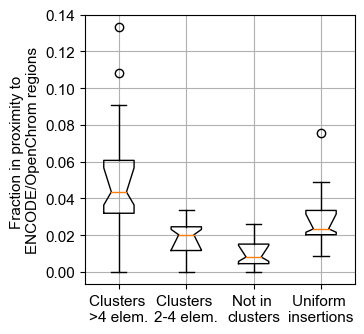

In [57]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_rd_1_mean],labels=["Clusters \n>4 elem.","Clusters \n2-4 elem.","Not in \nclusters", "Uniform \ninsertions"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

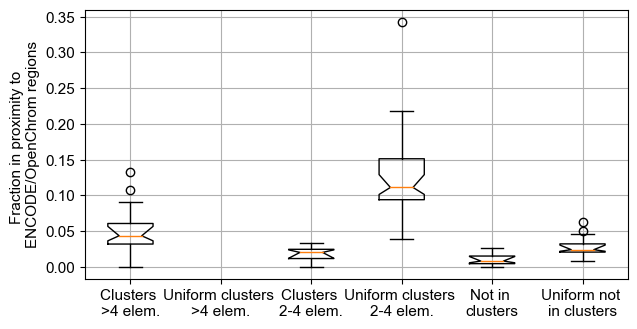

In [58]:
fig=plt.figure(figsize=(7,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Uniform clusters \n>4 elem.","Clusters \n2-4 elem.","Uniform clusters \n2-4 elem.","Not in \nclusters","Uniform not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
#ax1.set_aspect(1./ax1.get_data_ratio())

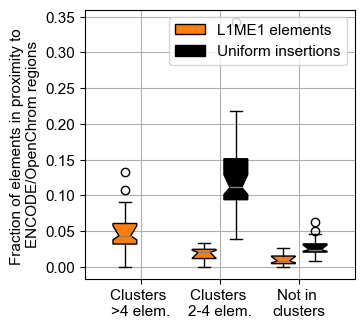

In [59]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([1,2,3])
bp_transposon=[mean_overlap_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean]
bp_hom_pos=[mean_overlap_rd_clusters_range_2_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_rd_1_mean]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(bp_transposon,positions=x_pos-0.2,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
bp2=ax1.boxplot(bp_hom_pos,positions=x_pos+0.2,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["Clusters \n>4 elem.","Clusters \n2-4 elem.","Not in \nclusters"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.legend([bp1['boxes'][0], bp2['boxes'][0]], ['L1ME1 elements', 'Uniform insertions'],prop={'family': 'Arial','size': 11},loc="upper right")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_3.pdf",format="pdf",bbox_inches="tight")


In [60]:
#stat sign. for clusters >4 elem.
#t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_clusters_range_2_mean,y=mean_overlap_rd_clusters_range_2_mean,alternative="two-sided")
#print(">4 elements:",p_value_1)
####################
#stat sign. for clusters 2-4 elem.
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_clusters_range_1_mean,y=mean_overlap_rd_clusters_range_1_mean,alternative="two-sided")
print("2-4 elements:",p_value_1)
####################
#stat sign. not in clusters
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_no_cluster_tr_1_mean,y=mean_overlap_no_cluster_rd_1_mean,alternative="two-sided")
print("not in clusters:",p_value_1)

2-4 elements: 6.6368856429973785e-09
not in clusters: 1.1990901870087094e-06


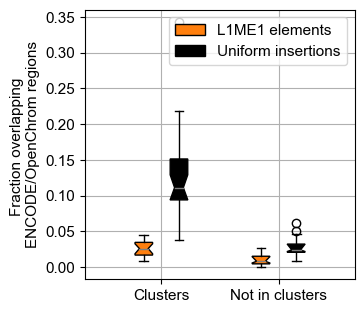

In [61]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([0,1])
bp_transposon=[mean_overlap_cluster_range_all_mean,mean_overlap_no_cluster_tr_1_mean]
bp_hom_pos=[mean_overlap_rd_cluster_range_all_mean,mean_overlap_no_cluster_rd_1_mean]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(bp_transposon,positions=x_pos-0.15,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
bp2=ax1.boxplot(bp_hom_pos,positions=x_pos+0.15,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["Clusters","Not in clusters"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction overlapping \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

plt.legend([bp1['boxes'][0], bp2['boxes'][0]], ['L1ME1 elements', 'Uniform insertions'],prop={'family': 'Arial','size': 11},loc="upper right")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/g_AluSq2_in_prox_ENCODE_4b.pdf",format="pdf",bbox_inches="tight")


In [62]:
#stat sign. for clusters 2-4 elem.
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_cluster_range_all_mean,y=mean_overlap_rd_cluster_range_all_mean,alternative="two-sided")
print("in clusters:",p_value_1)
####################
#stat sign. not in clusters
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_no_cluster_tr_1_mean,y=mean_overlap_no_cluster_rd_1_mean,alternative="two-sided")
print("not in clusters:",p_value_1)

in clusters: 9.185697615029324e-09
not in clusters: 1.1990901870087094e-06


In [63]:
#lengths of transposon clusters (from beginning of first transposon of cluster to end of last transposon -> same result as other method before)
length_cluster_1=[]
for i in range(len(df_cluster_pos_3)):
    for index,row in df_cluster_pos_3[i][0].iterrows():
        length_e=row["STOP"]-row["START"]
        length_cluster_1.append(length_e)
    

 
print("mean length clusters 2-4:",np.mean(length_cluster_1))

length_cluster_2=[]
for i in range(len(df_cluster_pos_3)):
    for index,row in df_cluster_pos_3[i][1].iterrows():
        length_e=row["STOP"]-row["START"]
        length_cluster_2.append(length_e)
 
print("mean length clusters >4:",np.mean(length_cluster_2))

length_cluster_all=np.concatenate((length_cluster_1,length_cluster_2))
print("mean+std length all clusters:",np.mean(length_cluster_all),",",np.std(length_cluster_all))
print("max, min length all clusters:",np.max(length_cluster_all),",",np.min(length_cluster_all))

mean length clusters 2-4: 2492.9958029197082
mean length clusters >4: 7102.226035502958
mean+std length all clusters: 3579.41129707113 , 3461.7441694688323
max, min length all clusters: 31645 , 117


# Visualising distribution of transposons and open chromatin on chromosomes

In [64]:
#save elements and clusters for later use:

#with open ("Transposon_analysis_1/save_elements/AluSp_clusters_eps_e4_min_samples_2_V1.pkl","wb") as f:
    #pickle.dump(df_cluster_pos_3,f)
    
#with open ("Transposon_analysis_1/save_elements/AluSp_elements_V1.pkl","wb") as f:
    #pickle.dump(rmd_list_3,f)    

In [18]:
# load elements for use:

with open('Transposon_analysis_1/save_elements/AluSp_clusters_eps_e4_min_samples_2_V1.pkl', 'rb') as f:
    df_cluster_pos_load = pickle.load(f)
    

with open('Transposon_analysis_1/save_elements/AluSp_elements_V1.pkl', 'rb') as f:
    rmd_list_load = pickle.load(f)
    
with open ("Transposon_analysis_1/save_elements/L1ME1_clusters_eps_e4_min_samples_2_V1.pkl",'rb') as f:
    df_cluster_pos_3 = pickle.load(f)
    
with open ("Transposon_analysis_1/save_elements/L1ME1_elements_V1.pkl",'rb') as f:
    rmd_list_3=pickle.load(f)        

In [19]:
#get acc peaks spilt into chrs
Chr_acc_peaks_sel1_split_by_chr=[Chr_acc_peaks_sel1[Chr_acc_peaks_sel1['chrom'] == chr_sel] for chr_sel in chr_list_3]

Chr_acc_peaks_sel1_split_by_chr

[      chrom  chromStart   chromEnd            name  score strand          6  \
 7      chr1      713850     714460         Valid_1   1000      .     713850   
 13     chr1      761903     763244         Valid_2   1000      .     761903   
 30     chr1      841391     842575         Valid_3   1000      .     841391   
 32     chr1      845956     847166         Valid_4   1000      .     845956   
 37     chr1      853094     853481         Valid_5   1000      .     853094   
 ...     ...         ...        ...             ...    ...    ...        ...   
 25189  chr1   247553370  247553810  OpenChrom_1125   1000      .  247553370   
 25193  chr1   247611316  247611741  OpenChrom_1126   1000      .  247611316   
 25237  chr1   248406521  248406810  OpenChrom_1127   1000      .  248406521   
 25290  chr1   249106366  249106815  OpenChrom_1128   1000      .  249106366   
 25307  chr1   249218884  249219215  OpenChrom_1129   1000      .  249218884   
 
                7        8      9  ...

In [20]:
#if transposon very short, lines in plot might not be visible, therefore use a minimum width
def return_minimum_width(ymin, ymax, min_length):
    
    if ymax - ymin < min_length:
        center = (ymax + ymin) / 2
        ymin = center - min_length / 2
        ymax = center + min_length / 2
    return ymin, ymax   

Chr: chr5 Genomic range: 68900000 - 69200000 BP


<Figure size 600x200 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

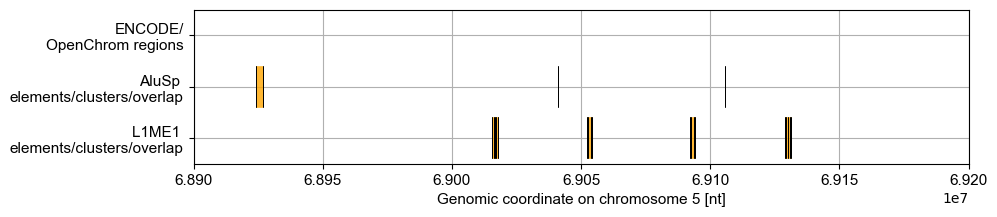

In [53]:
plot_chr=4
min_dist_plot=0

elements_1=rmd_list_3[plot_chr]
clusters_element_1=pd.concat([df_cluster_pos_3[plot_chr][0],df_cluster_pos_3[plot_chr][1]],axis=0)

elements_2=rmd_list_load[plot_chr]
clusters_element_2=pd.concat([df_cluster_pos_load[plot_chr][0],df_cluster_pos_load[plot_chr][1]],axis=0)

chr_acc=Chr_acc_peaks_sel1_split_by_chr[plot_chr]



plot_names=["L1ME1 \nelements/clusters/overlap","AluSp \nelements/clusters/overlap","ENCODE/\nOpenChrom regions"]




plot_range=[5.1*10**7,5.2*10**7]   #[5*10**7,5.5*10**7]

plot_range_start=np.asarray([1,2,3,4,5,6,7,8,9])*10**7
plot_range_stop=np.asarray([2,3,4,5,6,7,8,9,10])*10**7

plot_range_start=np.arange(1,10,0.1)*10**7
plot_range_stop=plot_range_start +0.03*10**7


plot_range_start=  [68900000] #[15920000] #
plot_range_stop= [69200000] #[16220000]   #
chr_acc_start=chr_acc["chromStart"].to_numpy()
chr_acc_stop=chr_acc["chromEnd"].to_numpy()
for k in range(len(plot_range_start)):
    
    fig=plt.figure(figsize=(6,2))
    fig=plt.figure(figsize=(20,5))
    fig=plt.figure(figsize=(10,2))
    
    ax1 = fig.add_subplot(111)

    plot_range=[plot_range_start[k],plot_range_stop[k]]
    
    plot_range_span=plot_range[1]-plot_range[0]
    
    plt.xlim(plot_range_start[k],plot_range_stop[k])
    
    min_width_line=plot_range_span/750
    
    
    print("Chr:",chr_list_3[plot_chr],"Genomic range:",plot_range[0],"-",plot_range[1], "BP")




    #plot clusters element 1
    for index, row in clusters_element_1.iterrows():

        elem_start=row["START"]
        elem_stop=row["STOP"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(1,draw_start,draw_stop, linewidth=30,color="orange",alpha=0.8)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(1,draw_start,draw_stop, linewidth=15,color="lightblue",alpha=1)
                #print("!")

    #plot elements 1
    for index, row in elements_1.iterrows():

        elem_start=row["genoStart"]
        elem_stop=row["genoEnd"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(1,draw_start,draw_stop, linewidth=30,color="black",alpha=1)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(1,draw_start,draw_stop, linewidth=15,color="lightblue",alpha=1)
                #print("!")

    ##########################
    ##########################
    ##########################




    #plot clusters element 2
    for index, row in clusters_element_2.iterrows():

        elem_start=row["START"]
        elem_stop=row["STOP"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(2,draw_start,draw_stop, linewidth=30,color="orange",alpha=0.8)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(2,draw_start,draw_stop, linewidth=15,color="lightblue",alpha=1)
                #print("!")

    #plot elements 2
    for index, row in elements_2.iterrows():

        elem_start=row["genoStart"]
        elem_stop=row["genoEnd"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(2,draw_start,draw_stop, linewidth=30,color="black",alpha=1)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(2,draw_start,draw_stop, linewidth=15,color="lightblue",alpha=1)
                #print("!")


    #plot open chr regions
    for index, row in chr_acc.iterrows():

        elem_start=row["chromStart"]
        elem_stop=row["chromEnd"]
        
        draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span


            ax1.hlines(3,draw_start,draw_stop, linewidth=30,color="black",alpha=1)







    plt.ylim(0.5,3.5)
    plt.yticks([1,2,3],plot_names,fontname = "Arial",fontsize=11)
    plt.xticks(fontname = "Arial",fontsize=11) 
    #plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
    plt.xlabel("Genomic coordinate on chromosome 5 [nt]",fontname = "Arial",fontsize=11)
    plt.grid()
    #plt.savefig("Transposon_analysis_1/figures/chr1_section_15920000_16220000_L1ME1_AluSp_V1.pdf",format="pdf",bbox_inches="tight")
    #plt.savefig("Transposon_analysis_1/figures/chr5_section_68900000_69200000_L1ME1_AluSp_V1.pdf",format="pdf",bbox_inches="tight")
    plt.show()



# Size distribution of Transposons

## Functions

In [69]:
def t_size_distr_1(rmd_list_input):
    #get all sizes of transposons on each chromosome
    size_rmd_list_v1=[]
    for i in range(len(rmd_list_input)):
        size_rmd_list_v1.append( rmd_list_input[i][:]["genoEnd"].to_numpy()-rmd_list_input[i][:]["genoStart"].to_numpy()   )

    #append all sizes from each chromosome into one list
    size_rmd_list_v1_fl=[]
    for i in range(len(size_rmd_list_v1)):
        for j in range(len(size_rmd_list_v1[i])):
            size_rmd_list_v1_fl.append(size_rmd_list_v1[i][j])
            
    return size_rmd_list_v1,size_rmd_list_v1_fl

In [70]:
examples_rmd_3=rmd_3[rmd_3["repFamily"]=="L1"]

In [71]:
examples_rmd_3

genoName  genoStart    genoEnd     repName repClass  \
3                         chr1   50330063   50332153      L1PA10     LINE   
4                         chr1   58720067   58720973       L1PA2     LINE   
5                         chr1   75496180   75498100       L1MB7     LINE   
8                         chr1  117440426  117440514       L1ME1     LINE   
9                         chr1  117440494  117441457       L1ME1     LINE   
...                        ...        ...        ...         ...      ...   
5481309  chr21_gl000210_random       6396       6656       L1MB7     LINE   
5481314  chr21_gl000210_random       9359       9500       L1ME1     LINE   
5481316  chr21_gl000210_random      10059      10200       L1ME1     LINE   
5481339  chr21_gl000210_random      27296      27447  HAL1-2a_MD     LINE   
5481340  chr21_gl000210_random      27468      27682  HAL1-2a_MD     LINE   

        repFamily  
3              L1  
4              L1  
5              L1  
8              L1  
9              L1  
...           ...  
5481309        L1  
5481314        L1  
5481316        L1  
5481339        L1  
5481340        L1  

[987052 rows x 6 columns]

In [72]:
unique_examples_rmd_3 = [examples_rmd_3[col_name].unique() for col_name in examples_rmd_3.columns]

for i in unique_examples_rmd_3[3]:
    print(i)

L1PA10
L1PA2
L1MB7
L1ME1
L1PA7
L1PA3
L1ME2
L1MEc
L1MA9
L1MB3
L1PA8A
L1PA6
L1M2
HAL1
L1PA14
L1MA10
L1M1
L1ME3
L1PBa
L1PA15-16
L1M4
L1MDa
L1MC4
L1ME4a
L1MB8
L1MC
L1M3
L1MC1
L1PA5
L1PA4
L1MC3
L1M5
L1PA15
L1MA1
L1PA17
L1PB4
L1M4b
L1PB1
L1PA13
L1MB1
L1MA7
L1MB2
L1PA8
L1P1
L1MA3
HAL1b
L1MC2
L1MA2
L1MC4a
L1MC5
L1ME3A
L1MCc
L1PA16
L1MCa
L1ME5
L1MEe
L1MEf
L1ME3C
L1MD3
L1P4
L1MEd
L1P5
L1MA5
L1ME3D
L1MD
L1HS
L1MA8
L1PBa1
L1PA11
L1M4c
L1MA4A
L1MA4
L1ME3F
L1PREC2
L1MD1
L1MA6
L1MD2
L1PB3
L1MEg
L1MEg2
L1MB4
L1ME3B
L1M3e
L1M3a
L1MB5
L1PB
L1ME3E
L1M2c
L1M7
HAL1-3A_ME
L1ME2z
L1MEb
HAL1-2a_MD
L1PA12
L1MA5A
L1P2
L1PB2
L1P3
L1M6
L1M
L1MCb
L1P4a
L1M3f
L1M2a
L1P4e
L1M2b
L1MDb
L1M3c
L1MEg1
L1M3de
L1M3d
L1PBb
L1P3b
L1P4d
L1MEa
L1M2a1
L1M3b
L1P4b
L1P
L1P4c
HAL1N1_MD
L1MC5a
L1ME4b
X9_LINE
L1ME3G
L1ME4c
L1ME3Cz
L1MEj
L1M8
L1MEh
L1MEi
HAL1ME
L1M4a1
L1M4a2
HAL1M8
L1M6B


In [73]:
#select two transposons to compare size distribution
#no chrY to compare to HeLa cells
chr_list_size_1=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16",
         "chr17","chr18","chr19","chr20","chr21","chr22","chrX"
         ]

element_sel_size_1="L1ME1" #"MamRep1527"  #"MamRep1527" #"L1ME1" #"AluSp"

element_sel_size_2="AluSp" #"MamRep1527"  #"MamRep1527" #"L1ME1" #"AluSp"   #"FRAM" #"HAL1-3A_ME"

In [74]:
rmd_list_size_1= sel_rep_element_on_chr_2(rmd_1=rmd_3,chr_list=chr_list_size_1,elements_name=element_sel_size_1,chr_col_name="genoName",element_col_name="repName")

In [75]:
rmd_list_size_2= sel_rep_element_on_chr_2(rmd_1=rmd_3,chr_list=chr_list_size_1,elements_name=element_sel_size_2,chr_col_name="genoName",element_col_name="repName")

In [76]:
tr_len_size_1,tr_len_size_1_fl=t_size_distr_1(rmd_list_size_1)

In [77]:
tr_len_size_2,tr_len_size_2_fl=t_size_distr_1(rmd_list_size_2)

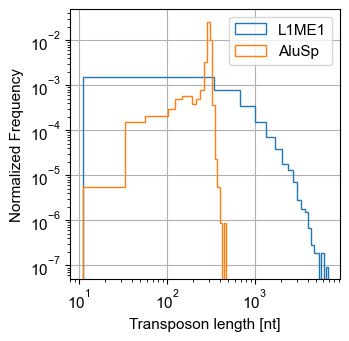

In [80]:


fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

size_hist_v1=plt.hist(tr_len_size_1_fl,density=True,label="L1ME1",histtype="step",bins=20)
size_hist_v2=plt.hist(tr_len_size_2_fl,density=True,label="AluSp",histtype="step",bins=20)

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Normalized Frequency",fontname = "Arial",fontsize=11)
plt.xlabel("Transposon length [nt]",fontname = "Arial",fontsize=11)

plt.xscale("log")
plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

In [79]:
print("Mean, std. transposon length type 1:", np.mean(tr_len_size_1_fl),",",np.std(tr_len_size_1_fl),)
print("Mean, std. transposon length type 2:", np.mean(tr_len_size_2_fl),",",np.std(tr_len_size_2_fl))

Mean, std. transposon length type 1: 480.5730630716767 , 471.1156556669817
Mean, std. transposon length type 2: 288.9286871961102 , 43.1633157680467
